In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import tensorflow as tf
import keras.backend as K


%matplotlib inline

In [3]:
seed_numpy = 0
seed_tensorflow = 0

np.random.seed(seed_numpy)
tf.compat.v1.random.set_random_seed(seed_tensorflow)

In [4]:
f = r'C:\Users\mattk\code\Mkt_Data\all_futures.csv'
df = pd.read_csv(f,index_col=0,parse_dates=[0])
df = df.resample('1B').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13112 entries, 1970-03-30 to 2020-06-30
Freq: B
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AEX      2790 non-null   float64
 1   AUD      8423 non-null   float64
 2   BOBL     3191 non-null   float64
 3   BTP      2680 non-null   float64
 4   BUND     3513 non-null   float64
 5   CAC      2877 non-null   float64
 6   COPPER   6331 non-null   float64
 7   CORN     12248 non-null  float64
 8   CRUDE_W  7868 non-null   float64
 9   EDOLLAR  9262 non-null   float64
 10  EUR      5328 non-null   float64
 11  EUROSTX  1566 non-null   float64
 12  GAS_US   7560 non-null   float64
 13  GBP      11327 non-null  float64
 14  GOLD     11411 non-null  float64
 15  JPY      10932 non-null  float64
 16  KOSPI    1532 non-null   float64
 17  KR10     1520 non-null   float64
 18  KR3      1515 non-null   float64
 19  LEANHOG  11856 non-null  float64
 20  LIVECOW  12537 non-null  

In [5]:
def calc_macd(ser,s=8,l=24):
    '''
    input = series
    
    '''
    x = ser.ewm(span=(2*s-1)).mean() - ser.ewm(span=(2*l-1)).mean()
    y = x/ser.diff().ewm(span=25).std()
    y = y/y.rolling(252).std()
    return y

In [72]:
df2 = df[['GOLD']].iloc[:-1,:]
df2 = df2.loc[df2.first_valid_index():,:]
df2.fillna(method = 'ffill',inplace=True)

df2['dif'] = df2.GOLD.diff()
df2.dropna(inplace=True)

df2['macd1'] = calc_macd(df2.GOLD)
df2['macd2'] = calc_macd(df2.GOLD,16,48)
df2['macd3'] = calc_macd(df2.GOLD,32,96)
df2['trend1'] = (df2.GOLD - df2.GOLD.shift(21))/(df2.GOLD.diff().ewm(span=25).std()*np.sqrt(21)) # 1m
df2['trend2'] = (df2.GOLD - df2.GOLD.shift(63))/(df2.GOLD.diff().ewm(span=25).std()*np.sqrt(63)) # 3m
df2['trend3'] = (df2.GOLD - df2.GOLD.shift(126))/(df2.GOLD.diff().ewm(span=25).std()*np.sqrt(126)) # 6m
df2['trend4'] = (df2.GOLD - df2.GOLD.shift(252))/(df2.GOLD.diff().ewm(span=25).std()*np.sqrt(252)) # 1y

tgt_vol = 1
df2['scaled_return_next'] = (df2.GOLD.diff()).shift(-1) # no vol scaling
# df2['scaled_return_next'] = (df2['dif']*tgt_vol/df2['dif'].ewm(span=25).std()).shift(-1)

In [73]:
df2=df2.dropna()

In [74]:
xdata = df2.iloc[:-1,2:-1]
ydata = df2.iloc[:-1,-1]

print(xdata.shape)
print(ydata.shape)

(11593, 7)
(11593,)


In [75]:
train_size = int(len(xdata)*.8)
test_size = len(xdata)-train_size

#change y's if multiple outputs
xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]

print(len(xtrain),len(xtest))
print(len(ytrain),len(ytest))

9274 2319
9274 2319


In [76]:
scalerX = StandardScaler()
scalerY = StandardScaler()

In [77]:
xtrain_sc = scalerX.fit_transform(xtrain.to_numpy())
xtest_sc = scalerX.transform(xtest.to_numpy())
ytrain_sc = scalerY.fit_transform(ytrain.to_numpy().reshape(-1,1))
ytest_sc = scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [78]:
# first custom loss to miniize is simply defined as negative profits
def customLoss(yTrue,yPred):
    return yTrue*yPred*-1

In [79]:
def customLoss2(yTrue,yPred):
    return K.square(K.abs(yTrue) - (yPred*yTrue))

In [80]:
pr = tf.random.uniform(minval=-1, maxval=1, shape=(2, 1), dtype=tf.float32)
tr = tf.random.uniform(minval=5, maxval=6, shape=(2, 1), dtype=tf.float32)

In [81]:
customLoss(tr,pr)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 4.2951765],
       [-3.2131267]], dtype=float32)>

In [16]:
print(tr,pr)
customLoss2(tr,pr)

tf.Tensor(
[[5.555414]
 [5.221293]], shape=(2, 1), dtype=float32) tf.Tensor(
[[-0.41604972]
 [-0.5868671 ]], shape=(2, 1), dtype=float32)


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[61.88564 ],
       [68.649475]], dtype=float32)>

In [25]:
act = 3
pos = .6
((np.abs(act) - pos*(act))/np.abs(act))**2

0.16000000000000006

In [26]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(1,activation='tanh')
])

model.compile(loss=customLoss2, optimizer=tf.optimizers.Adam(learning_rate=.001))

In [27]:
history = model.fit(xtrain_sc, ytrain_sc, epochs=1000,verbose=2,batch_size=int(len(xtrain_sc)/10))

Epoch 1/1000
11/11 - 0s - loss: 1.0125
Epoch 2/1000
11/11 - 0s - loss: 1.0000
Epoch 3/1000
11/11 - 0s - loss: 0.9898
Epoch 4/1000
11/11 - 0s - loss: 0.9883
Epoch 5/1000
11/11 - 0s - loss: 0.9984
Epoch 6/1000
11/11 - 0s - loss: 0.9869
Epoch 7/1000
11/11 - 0s - loss: 1.0429
Epoch 8/1000
11/11 - 0s - loss: 1.0537
Epoch 9/1000
11/11 - 0s - loss: 1.0843
Epoch 10/1000
11/11 - 0s - loss: 1.1253
Epoch 11/1000
11/11 - 0s - loss: 1.0009
Epoch 12/1000
11/11 - 0s - loss: 0.9995
Epoch 13/1000
11/11 - 0s - loss: 1.0097
Epoch 14/1000
11/11 - 0s - loss: 1.0162
Epoch 15/1000
11/11 - 0s - loss: 1.0069
Epoch 16/1000
11/11 - 0s - loss: 0.9924
Epoch 17/1000
11/11 - 0s - loss: 0.9920
Epoch 18/1000
11/11 - 0s - loss: 0.9866
Epoch 19/1000
11/11 - 0s - loss: 1.0125
Epoch 20/1000
11/11 - 0s - loss: 0.9909
Epoch 21/1000
11/11 - 0s - loss: 0.9843
Epoch 22/1000
11/11 - 0s - loss: 0.9901
Epoch 23/1000
11/11 - 0s - loss: 0.9977
Epoch 24/1000
11/11 - 0s - loss: 0.9914
Epoch 25/1000
11/11 - 0s - loss: 0.9854
Epoch 26/

Epoch 204/1000
11/11 - 0s - loss: 0.9828
Epoch 205/1000
11/11 - 0s - loss: 0.9844
Epoch 206/1000
11/11 - 0s - loss: 0.9855
Epoch 207/1000
11/11 - 0s - loss: 0.9866
Epoch 208/1000
11/11 - 0s - loss: 0.9863
Epoch 209/1000
11/11 - 0s - loss: 0.9858
Epoch 210/1000
11/11 - 0s - loss: 0.9823
Epoch 211/1000
11/11 - 0s - loss: 0.9859
Epoch 212/1000
11/11 - 0s - loss: 0.9879
Epoch 213/1000
11/11 - 0s - loss: 0.9852
Epoch 214/1000
11/11 - 0s - loss: 1.0087
Epoch 215/1000
11/11 - 0s - loss: 0.9934
Epoch 216/1000
11/11 - 0s - loss: 0.9894
Epoch 217/1000
11/11 - 0s - loss: 0.9846
Epoch 218/1000
11/11 - 0s - loss: 0.9820
Epoch 219/1000
11/11 - 0s - loss: 0.9822
Epoch 220/1000
11/11 - 0s - loss: 0.9905
Epoch 221/1000
11/11 - 0s - loss: 0.9949
Epoch 222/1000
11/11 - 0s - loss: 1.0065
Epoch 223/1000
11/11 - 0s - loss: 0.9908
Epoch 224/1000
11/11 - 0s - loss: 0.9952
Epoch 225/1000
11/11 - 0s - loss: 0.9851
Epoch 226/1000
11/11 - 0s - loss: 0.9923
Epoch 227/1000
11/11 - 0s - loss: 0.9847
Epoch 228/1000
1

Epoch 404/1000
11/11 - 0s - loss: 0.9913
Epoch 405/1000
11/11 - 0s - loss: 0.9828
Epoch 406/1000
11/11 - 0s - loss: 0.9853
Epoch 407/1000
11/11 - 0s - loss: 0.9803
Epoch 408/1000
11/11 - 0s - loss: 1.0091
Epoch 409/1000
11/11 - 0s - loss: 0.9944
Epoch 410/1000
11/11 - 0s - loss: 0.9822
Epoch 411/1000
11/11 - 0s - loss: 0.9943
Epoch 412/1000
11/11 - 0s - loss: 0.9964
Epoch 413/1000
11/11 - 0s - loss: 0.9980
Epoch 414/1000
11/11 - 0s - loss: 0.9922
Epoch 415/1000
11/11 - 0s - loss: 0.9837
Epoch 416/1000
11/11 - 0s - loss: 0.9829
Epoch 417/1000
11/11 - 0s - loss: 0.9867
Epoch 418/1000
11/11 - 0s - loss: 0.9837
Epoch 419/1000
11/11 - 0s - loss: 0.9831
Epoch 420/1000
11/11 - 0s - loss: 0.9860
Epoch 421/1000
11/11 - 0s - loss: 0.9860
Epoch 422/1000
11/11 - 0s - loss: 0.9802
Epoch 423/1000
11/11 - 0s - loss: 0.9893
Epoch 424/1000
11/11 - 0s - loss: 0.9906
Epoch 425/1000
11/11 - 0s - loss: 0.9826
Epoch 426/1000
11/11 - 0s - loss: 0.9859
Epoch 427/1000
11/11 - 0s - loss: 0.9853
Epoch 428/1000
1

Epoch 604/1000
11/11 - 0s - loss: 0.9928
Epoch 605/1000
11/11 - 0s - loss: 0.9893
Epoch 606/1000
11/11 - 0s - loss: 0.9875
Epoch 607/1000
11/11 - 0s - loss: 0.9874
Epoch 608/1000
11/11 - 0s - loss: 0.9863
Epoch 609/1000
11/11 - 0s - loss: 0.9892
Epoch 610/1000
11/11 - 0s - loss: 0.9907
Epoch 611/1000
11/11 - 0s - loss: 0.9819
Epoch 612/1000
11/11 - 0s - loss: 0.9806
Epoch 613/1000
11/11 - 0s - loss: 0.9897
Epoch 614/1000
11/11 - 0s - loss: 0.9974
Epoch 615/1000
11/11 - 0s - loss: 0.9839
Epoch 616/1000
11/11 - 0s - loss: 0.9796
Epoch 617/1000
11/11 - 0s - loss: 0.9812
Epoch 618/1000
11/11 - 0s - loss: 0.9815
Epoch 619/1000
11/11 - 0s - loss: 0.9866
Epoch 620/1000
11/11 - 0s - loss: 0.9943
Epoch 621/1000
11/11 - 0s - loss: 0.9946
Epoch 622/1000
11/11 - 0s - loss: 0.9958
Epoch 623/1000
11/11 - 0s - loss: 0.9949
Epoch 624/1000
11/11 - 0s - loss: 0.9977
Epoch 625/1000
11/11 - 0s - loss: 0.9917
Epoch 626/1000
11/11 - 0s - loss: 0.9852
Epoch 627/1000
11/11 - 0s - loss: 0.9848
Epoch 628/1000
1

Epoch 804/1000
11/11 - 0s - loss: 0.9802
Epoch 805/1000
11/11 - 0s - loss: 0.9799
Epoch 806/1000
11/11 - 0s - loss: 0.9794
Epoch 807/1000
11/11 - 0s - loss: 0.9797
Epoch 808/1000
11/11 - 0s - loss: 0.9815
Epoch 809/1000
11/11 - 0s - loss: 0.9815
Epoch 810/1000
11/11 - 0s - loss: 0.9817
Epoch 811/1000
11/11 - 0s - loss: 0.9852
Epoch 812/1000
11/11 - 0s - loss: 0.9861
Epoch 813/1000
11/11 - 0s - loss: 0.9802
Epoch 814/1000
11/11 - 0s - loss: 0.9814
Epoch 815/1000
11/11 - 0s - loss: 0.9797
Epoch 816/1000
11/11 - 0s - loss: 0.9833
Epoch 817/1000
11/11 - 0s - loss: 0.9824
Epoch 818/1000
11/11 - 0s - loss: 0.9806
Epoch 819/1000
11/11 - 0s - loss: 0.9798
Epoch 820/1000
11/11 - 0s - loss: 1.0015
Epoch 821/1000
11/11 - 0s - loss: 1.0032
Epoch 822/1000
11/11 - 0s - loss: 0.9854
Epoch 823/1000
11/11 - 0s - loss: 0.9815
Epoch 824/1000
11/11 - 0s - loss: 0.9809
Epoch 825/1000
11/11 - 0s - loss: 0.9806
Epoch 826/1000
11/11 - 0s - loss: 0.9799
Epoch 827/1000
11/11 - 0s - loss: 0.9823
Epoch 828/1000
1

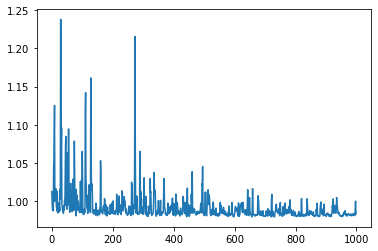

In [28]:
plt.plot(history.history['loss'])

total sharpe: 0.08442433013397256


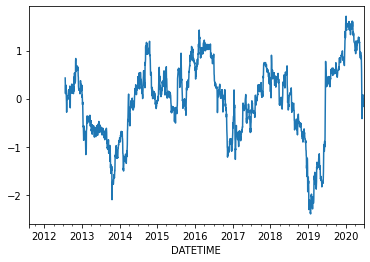

In [29]:
preds = model.predict(xtest_sc)

final = pd.DataFrame(preds,columns=['preds'],index=ytest.index)
final['y'] = scalerY.inverse_transform(ytest_sc)
final['profit'] = final['preds']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

print('total sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
final.rolling_sharpe.plot()

In [30]:
customLoss2(ytest_sc,preds).numpy().mean()

0.9974168738903607

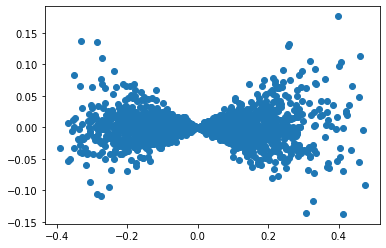

In [31]:
plt.scatter(final.preds,final.profit)

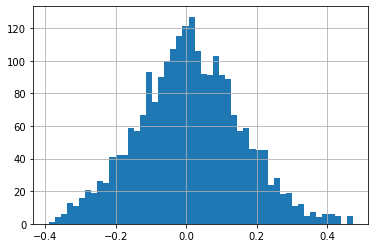

In [32]:
final.preds.hist(bins=50)

# In sample force fit

In [33]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(100,activation = 'relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=tf.optimizers.Adam(learning_rate=.0001))

In [34]:
history = model.fit(xtrain_sc[:10], ytrain_sc[:10], epochs=15000,verbose=2,batch_size=2)

Epoch 1/15000
5/5 - 0s - loss: 0.6706
Epoch 2/15000
5/5 - 0s - loss: 0.6529
Epoch 3/15000
5/5 - 0s - loss: 0.6453
Epoch 4/15000
5/5 - 0s - loss: 0.6416
Epoch 5/15000
5/5 - 0s - loss: 0.6409
Epoch 6/15000
5/5 - 0s - loss: 0.6497
Epoch 7/15000
5/5 - 0s - loss: 0.6370
Epoch 8/15000
5/5 - 0s - loss: 0.6360
Epoch 9/15000
5/5 - 0s - loss: 0.6345
Epoch 10/15000
5/5 - 0s - loss: 0.6317
Epoch 11/15000
5/5 - 0s - loss: 0.6349
Epoch 12/15000
5/5 - 0s - loss: 0.6308
Epoch 13/15000
5/5 - 0s - loss: 0.6335
Epoch 14/15000
5/5 - 0s - loss: 0.6320
Epoch 15/15000
5/5 - 0s - loss: 0.6305
Epoch 16/15000
5/5 - 0s - loss: 0.6294
Epoch 17/15000
5/5 - 0s - loss: 0.6292
Epoch 18/15000
5/5 - 0s - loss: 0.6288
Epoch 19/15000
5/5 - 0s - loss: 0.6341
Epoch 20/15000
5/5 - 0s - loss: 0.6278
Epoch 21/15000
5/5 - 0s - loss: 0.6302
Epoch 22/15000
5/5 - 0s - loss: 0.6407
Epoch 23/15000
5/5 - 0s - loss: 0.6280
Epoch 24/15000
5/5 - 0s - loss: 0.6257
Epoch 25/15000
5/5 - 0s - loss: 0.6289
Epoch 26/15000
5/5 - 0s - loss: 0.

Epoch 209/15000
5/5 - 0s - loss: 0.5740
Epoch 210/15000
5/5 - 0s - loss: 0.5736
Epoch 211/15000
5/5 - 0s - loss: 0.5730
Epoch 212/15000
5/5 - 0s - loss: 0.5779
Epoch 213/15000
5/5 - 0s - loss: 0.5738
Epoch 214/15000
5/5 - 0s - loss: 0.5736
Epoch 215/15000
5/5 - 0s - loss: 0.5708
Epoch 216/15000
5/5 - 0s - loss: 0.5694
Epoch 217/15000
5/5 - 0s - loss: 0.5712
Epoch 218/15000
5/5 - 0s - loss: 0.5743
Epoch 219/15000
5/5 - 0s - loss: 0.5748
Epoch 220/15000
5/5 - 0s - loss: 0.5715
Epoch 221/15000
5/5 - 0s - loss: 0.5735
Epoch 222/15000
5/5 - 0s - loss: 0.5748
Epoch 223/15000
5/5 - 0s - loss: 0.5795
Epoch 224/15000
5/5 - 0s - loss: 0.5752
Epoch 225/15000
5/5 - 0s - loss: 0.5672
Epoch 226/15000
5/5 - 0s - loss: 0.5762
Epoch 227/15000
5/5 - 0s - loss: 0.5714
Epoch 228/15000
5/5 - 0s - loss: 0.5767
Epoch 229/15000
5/5 - 0s - loss: 0.5719
Epoch 230/15000
5/5 - 0s - loss: 0.5752
Epoch 231/15000
5/5 - 0s - loss: 0.5710
Epoch 232/15000
5/5 - 0s - loss: 0.5755
Epoch 233/15000
5/5 - 0s - loss: 0.5729


Epoch 414/15000
5/5 - 0s - loss: 0.5577
Epoch 415/15000
5/5 - 0s - loss: 0.5509
Epoch 416/15000
5/5 - 0s - loss: 0.5588
Epoch 417/15000
5/5 - 0s - loss: 0.5583
Epoch 418/15000
5/5 - 0s - loss: 0.5546
Epoch 419/15000
5/5 - 0s - loss: 0.5495
Epoch 420/15000
5/5 - 0s - loss: 0.5536
Epoch 421/15000
5/5 - 0s - loss: 0.5536
Epoch 422/15000
5/5 - 0s - loss: 0.5571
Epoch 423/15000
5/5 - 0s - loss: 0.5512
Epoch 424/15000
5/5 - 0s - loss: 0.5485
Epoch 425/15000
5/5 - 0s - loss: 0.5522
Epoch 426/15000
5/5 - 0s - loss: 0.5489
Epoch 427/15000
5/5 - 0s - loss: 0.5502
Epoch 428/15000
5/5 - 0s - loss: 0.5488
Epoch 429/15000
5/5 - 0s - loss: 0.5492
Epoch 430/15000
5/5 - 0s - loss: 0.5542
Epoch 431/15000
5/5 - 0s - loss: 0.5514
Epoch 432/15000
5/5 - 0s - loss: 0.5498
Epoch 433/15000
5/5 - 0s - loss: 0.5499
Epoch 434/15000
5/5 - 0s - loss: 0.5532
Epoch 435/15000
5/5 - 0s - loss: 0.5657
Epoch 436/15000
5/5 - 0s - loss: 0.5607
Epoch 437/15000
5/5 - 0s - loss: 0.5468
Epoch 438/15000
5/5 - 0s - loss: 0.5559


Epoch 619/15000
5/5 - 0s - loss: 0.5214
Epoch 620/15000
5/5 - 0s - loss: 0.5442
Epoch 621/15000
5/5 - 0s - loss: 0.5355
Epoch 622/15000
5/5 - 0s - loss: 0.5321
Epoch 623/15000
5/5 - 0s - loss: 0.5209
Epoch 624/15000
5/5 - 0s - loss: 0.5244
Epoch 625/15000
5/5 - 0s - loss: 0.5284
Epoch 626/15000
5/5 - 0s - loss: 0.5173
Epoch 627/15000
5/5 - 0s - loss: 0.5256
Epoch 628/15000
5/5 - 0s - loss: 0.5231
Epoch 629/15000
5/5 - 0s - loss: 0.5221
Epoch 630/15000
5/5 - 0s - loss: 0.5200
Epoch 631/15000
5/5 - 0s - loss: 0.5167
Epoch 632/15000
5/5 - 0s - loss: 0.5212
Epoch 633/15000
5/5 - 0s - loss: 0.5292
Epoch 634/15000
5/5 - 0s - loss: 0.5337
Epoch 635/15000
5/5 - 0s - loss: 0.5304
Epoch 636/15000
5/5 - 0s - loss: 0.5196
Epoch 637/15000
5/5 - 0s - loss: 0.5196
Epoch 638/15000
5/5 - 0s - loss: 0.5440
Epoch 639/15000
5/5 - 0s - loss: 0.5346
Epoch 640/15000
5/5 - 0s - loss: 0.5159
Epoch 641/15000
5/5 - 0s - loss: 0.5345
Epoch 642/15000
5/5 - 0s - loss: 0.5319
Epoch 643/15000
5/5 - 0s - loss: 0.5318


Epoch 824/15000
5/5 - 0s - loss: 0.4809
Epoch 825/15000
5/5 - 0s - loss: 0.4810
Epoch 826/15000
5/5 - 0s - loss: 0.4802
Epoch 827/15000
5/5 - 0s - loss: 0.4813
Epoch 828/15000
5/5 - 0s - loss: 0.4833
Epoch 829/15000
5/5 - 0s - loss: 0.4796
Epoch 830/15000
5/5 - 0s - loss: 0.4835
Epoch 831/15000
5/5 - 0s - loss: 0.4817
Epoch 832/15000
5/5 - 0s - loss: 0.4841
Epoch 833/15000
5/5 - 0s - loss: 0.4884
Epoch 834/15000
5/5 - 0s - loss: 0.4831
Epoch 835/15000
5/5 - 0s - loss: 0.4800
Epoch 836/15000
5/5 - 0s - loss: 0.4805
Epoch 837/15000
5/5 - 0s - loss: 0.4959
Epoch 838/15000
5/5 - 0s - loss: 0.4945
Epoch 839/15000
5/5 - 0s - loss: 0.4885
Epoch 840/15000
5/5 - 0s - loss: 0.4799
Epoch 841/15000
5/5 - 0s - loss: 0.4803
Epoch 842/15000
5/5 - 0s - loss: 0.4745
Epoch 843/15000
5/5 - 0s - loss: 0.4821
Epoch 844/15000
5/5 - 0s - loss: 0.4815
Epoch 845/15000
5/5 - 0s - loss: 0.4760
Epoch 846/15000
5/5 - 0s - loss: 0.4757
Epoch 847/15000
5/5 - 0s - loss: 0.4783
Epoch 848/15000
5/5 - 0s - loss: 0.4740


5/5 - 0s - loss: 0.4434
Epoch 1029/15000
5/5 - 0s - loss: 0.4314
Epoch 1030/15000
5/5 - 0s - loss: 0.4341
Epoch 1031/15000
5/5 - 0s - loss: 0.4339
Epoch 1032/15000
5/5 - 0s - loss: 0.4465
Epoch 1033/15000
5/5 - 0s - loss: 0.4427
Epoch 1034/15000
5/5 - 0s - loss: 0.4347
Epoch 1035/15000
5/5 - 0s - loss: 0.4296
Epoch 1036/15000
5/5 - 0s - loss: 0.4316
Epoch 1037/15000
5/5 - 0s - loss: 0.4303
Epoch 1038/15000
5/5 - 0s - loss: 0.4305
Epoch 1039/15000
5/5 - 0s - loss: 0.4323
Epoch 1040/15000
5/5 - 0s - loss: 0.4349
Epoch 1041/15000
5/5 - 0s - loss: 0.4444
Epoch 1042/15000
5/5 - 0s - loss: 0.4462
Epoch 1043/15000
5/5 - 0s - loss: 0.4358
Epoch 1044/15000
5/5 - 0s - loss: 0.4473
Epoch 1045/15000
5/5 - 0s - loss: 0.4407
Epoch 1046/15000
5/5 - 0s - loss: 0.4301
Epoch 1047/15000
5/5 - 0s - loss: 0.4345
Epoch 1048/15000
5/5 - 0s - loss: 0.4310
Epoch 1049/15000
5/5 - 0s - loss: 0.4257
Epoch 1050/15000
5/5 - 0s - loss: 0.4326
Epoch 1051/15000
5/5 - 0s - loss: 0.4284
Epoch 1052/15000
5/5 - 0s - loss:

Epoch 1229/15000
5/5 - 0s - loss: 0.4182
Epoch 1230/15000
5/5 - 0s - loss: 0.4098
Epoch 1231/15000
5/5 - 0s - loss: 0.4308
Epoch 1232/15000
5/5 - 0s - loss: 0.4211
Epoch 1233/15000
5/5 - 0s - loss: 0.4208
Epoch 1234/15000
5/5 - 0s - loss: 0.4134
Epoch 1235/15000
5/5 - 0s - loss: 0.4186
Epoch 1236/15000
5/5 - 0s - loss: 0.4234
Epoch 1237/15000
5/5 - 0s - loss: 0.4315
Epoch 1238/15000
5/5 - 0s - loss: 0.4153
Epoch 1239/15000
5/5 - 0s - loss: 0.4104
Epoch 1240/15000
5/5 - 0s - loss: 0.4119
Epoch 1241/15000
5/5 - 0s - loss: 0.4169
Epoch 1242/15000
5/5 - 0s - loss: 0.4222
Epoch 1243/15000
5/5 - 0s - loss: 0.4187
Epoch 1244/15000
5/5 - 0s - loss: 0.4140
Epoch 1245/15000
5/5 - 0s - loss: 0.4095
Epoch 1246/15000
5/5 - 0s - loss: 0.4199
Epoch 1247/15000
5/5 - 0s - loss: 0.4253
Epoch 1248/15000
5/5 - 0s - loss: 0.4158
Epoch 1249/15000
5/5 - 0s - loss: 0.4230
Epoch 1250/15000
5/5 - 0s - loss: 0.4259
Epoch 1251/15000
5/5 - 0s - loss: 0.4173
Epoch 1252/15000
5/5 - 0s - loss: 0.4079
Epoch 1253/15000

Epoch 1429/15000
5/5 - 0s - loss: 0.4108
Epoch 1430/15000
5/5 - 0s - loss: 0.3877
Epoch 1431/15000
5/5 - 0s - loss: 0.3880
Epoch 1432/15000
5/5 - 0s - loss: 0.3971
Epoch 1433/15000
5/5 - 0s - loss: 0.3997
Epoch 1434/15000
5/5 - 0s - loss: 0.4284
Epoch 1435/15000
5/5 - 0s - loss: 0.4117
Epoch 1436/15000
5/5 - 0s - loss: 0.4006
Epoch 1437/15000
5/5 - 0s - loss: 0.4041
Epoch 1438/15000
5/5 - 0s - loss: 0.4097
Epoch 1439/15000
5/5 - 0s - loss: 0.3982
Epoch 1440/15000
5/5 - 0s - loss: 0.3989
Epoch 1441/15000
5/5 - 0s - loss: 0.3889
Epoch 1442/15000
5/5 - 0s - loss: 0.3938
Epoch 1443/15000
5/5 - 0s - loss: 0.3856
Epoch 1444/15000
5/5 - 0s - loss: 0.4091
Epoch 1445/15000
5/5 - 0s - loss: 0.3986
Epoch 1446/15000
5/5 - 0s - loss: 0.3981
Epoch 1447/15000
5/5 - 0s - loss: 0.3916
Epoch 1448/15000
5/5 - 0s - loss: 0.3881
Epoch 1449/15000
5/5 - 0s - loss: 0.3915
Epoch 1450/15000
5/5 - 0s - loss: 0.3952
Epoch 1451/15000
5/5 - 0s - loss: 0.4027
Epoch 1452/15000
5/5 - 0s - loss: 0.4017
Epoch 1453/15000

Epoch 1629/15000
5/5 - 0s - loss: 0.3756
Epoch 1630/15000
5/5 - 0s - loss: 0.3843
Epoch 1631/15000
5/5 - 0s - loss: 0.3833
Epoch 1632/15000
5/5 - 0s - loss: 0.3766
Epoch 1633/15000
5/5 - 0s - loss: 0.3790
Epoch 1634/15000
5/5 - 0s - loss: 0.3763
Epoch 1635/15000
5/5 - 0s - loss: 0.3814
Epoch 1636/15000
5/5 - 0s - loss: 0.3829
Epoch 1637/15000
5/5 - 0s - loss: 0.3788
Epoch 1638/15000
5/5 - 0s - loss: 0.3803
Epoch 1639/15000
5/5 - 0s - loss: 0.3855
Epoch 1640/15000
5/5 - 0s - loss: 0.3754
Epoch 1641/15000
5/5 - 0s - loss: 0.3823
Epoch 1642/15000
5/5 - 0s - loss: 0.3835
Epoch 1643/15000
5/5 - 0s - loss: 0.3765
Epoch 1644/15000
5/5 - 0s - loss: 0.3791
Epoch 1645/15000
5/5 - 0s - loss: 0.3811
Epoch 1646/15000
5/5 - 0s - loss: 0.3897
Epoch 1647/15000
5/5 - 0s - loss: 0.3805
Epoch 1648/15000
5/5 - 0s - loss: 0.3987
Epoch 1649/15000
5/5 - 0s - loss: 0.3986
Epoch 1650/15000
5/5 - 0s - loss: 0.3651
Epoch 1651/15000
5/5 - 0s - loss: 0.3862
Epoch 1652/15000
5/5 - 0s - loss: 0.3838
Epoch 1653/15000

Epoch 1829/15000
5/5 - 0s - loss: 0.3663
Epoch 1830/15000
5/5 - 0s - loss: 0.3747
Epoch 1831/15000
5/5 - 0s - loss: 0.3715
Epoch 1832/15000
5/5 - 0s - loss: 0.3742
Epoch 1833/15000
5/5 - 0s - loss: 0.3785
Epoch 1834/15000
5/5 - 0s - loss: 0.3784
Epoch 1835/15000
5/5 - 0s - loss: 0.3757
Epoch 1836/15000
5/5 - 0s - loss: 0.3607
Epoch 1837/15000
5/5 - 0s - loss: 0.3729
Epoch 1838/15000
5/5 - 0s - loss: 0.3676
Epoch 1839/15000
5/5 - 0s - loss: 0.3659
Epoch 1840/15000
5/5 - 0s - loss: 0.3664
Epoch 1841/15000
5/5 - 0s - loss: 0.3689
Epoch 1842/15000
5/5 - 0s - loss: 0.3739
Epoch 1843/15000
5/5 - 0s - loss: 0.3821
Epoch 1844/15000
5/5 - 0s - loss: 0.3659
Epoch 1845/15000
5/5 - 0s - loss: 0.3828
Epoch 1846/15000
5/5 - 0s - loss: 0.3579
Epoch 1847/15000
5/5 - 0s - loss: 0.3763
Epoch 1848/15000
5/5 - 0s - loss: 0.3951
Epoch 1849/15000
5/5 - 0s - loss: 0.3813
Epoch 1850/15000
5/5 - 0s - loss: 0.3672
Epoch 1851/15000
5/5 - 0s - loss: 0.3756
Epoch 1852/15000
5/5 - 0s - loss: 0.3715
Epoch 1853/15000

Epoch 2029/15000
5/5 - 0s - loss: 0.3709
Epoch 2030/15000
5/5 - 0s - loss: 0.3697
Epoch 2031/15000
5/5 - 0s - loss: 0.3583
Epoch 2032/15000
5/5 - 0s - loss: 0.3618
Epoch 2033/15000
5/5 - 0s - loss: 0.3639
Epoch 2034/15000
5/5 - 0s - loss: 0.3502
Epoch 2035/15000
5/5 - 0s - loss: 0.3829
Epoch 2036/15000
5/5 - 0s - loss: 0.3848
Epoch 2037/15000
5/5 - 0s - loss: 0.3574
Epoch 2038/15000
5/5 - 0s - loss: 0.3860
Epoch 2039/15000
5/5 - 0s - loss: 0.3782
Epoch 2040/15000
5/5 - 0s - loss: 0.3569
Epoch 2041/15000
5/5 - 0s - loss: 0.3729
Epoch 2042/15000
5/5 - 0s - loss: 0.3568
Epoch 2043/15000
5/5 - 0s - loss: 0.3608
Epoch 2044/15000
5/5 - 0s - loss: 0.3579
Epoch 2045/15000
5/5 - 0s - loss: 0.3551
Epoch 2046/15000
5/5 - 0s - loss: 0.3519
Epoch 2047/15000
5/5 - 0s - loss: 0.3598
Epoch 2048/15000
5/5 - 0s - loss: 0.3615
Epoch 2049/15000
5/5 - 0s - loss: 0.3561
Epoch 2050/15000
5/5 - 0s - loss: 0.3566
Epoch 2051/15000
5/5 - 0s - loss: 0.3568
Epoch 2052/15000
5/5 - 0s - loss: 0.3566
Epoch 2053/15000

Epoch 2229/15000
5/5 - 0s - loss: 0.3547
Epoch 2230/15000
5/5 - 0s - loss: 0.3574
Epoch 2231/15000
5/5 - 0s - loss: 0.3518
Epoch 2232/15000
5/5 - 0s - loss: 0.3484
Epoch 2233/15000
5/5 - 0s - loss: 0.3515
Epoch 2234/15000
5/5 - 0s - loss: 0.3545
Epoch 2235/15000
5/5 - 0s - loss: 0.3551
Epoch 2236/15000
5/5 - 0s - loss: 0.3456
Epoch 2237/15000
5/5 - 0s - loss: 0.3492
Epoch 2238/15000
5/5 - 0s - loss: 0.3497
Epoch 2239/15000
5/5 - 0s - loss: 0.3524
Epoch 2240/15000
5/5 - 0s - loss: 0.3503
Epoch 2241/15000
5/5 - 0s - loss: 0.3514
Epoch 2242/15000
5/5 - 0s - loss: 0.3485
Epoch 2243/15000
5/5 - 0s - loss: 0.3432
Epoch 2244/15000
5/5 - 0s - loss: 0.3469
Epoch 2245/15000
5/5 - 0s - loss: 0.3483
Epoch 2246/15000
5/5 - 0s - loss: 0.3537
Epoch 2247/15000
5/5 - 0s - loss: 0.3558
Epoch 2248/15000
5/5 - 0s - loss: 0.3725
Epoch 2249/15000
5/5 - 0s - loss: 0.3759
Epoch 2250/15000
5/5 - 0s - loss: 0.3643
Epoch 2251/15000
5/5 - 0s - loss: 0.3788
Epoch 2252/15000
5/5 - 0s - loss: 0.3714
Epoch 2253/15000

Epoch 2429/15000
5/5 - 0s - loss: 0.3552
Epoch 2430/15000
5/5 - 0s - loss: 0.3595
Epoch 2431/15000
5/5 - 0s - loss: 0.3569
Epoch 2432/15000
5/5 - 0s - loss: 0.3390
Epoch 2433/15000
5/5 - 0s - loss: 0.3606
Epoch 2434/15000
5/5 - 0s - loss: 0.3682
Epoch 2435/15000
5/5 - 0s - loss: 0.3742
Epoch 2436/15000
5/5 - 0s - loss: 0.3631
Epoch 2437/15000
5/5 - 0s - loss: 0.3510
Epoch 2438/15000
5/5 - 0s - loss: 0.3413
Epoch 2439/15000
5/5 - 0s - loss: 0.3451
Epoch 2440/15000
5/5 - 0s - loss: 0.3584
Epoch 2441/15000
5/5 - 0s - loss: 0.3426
Epoch 2442/15000
5/5 - 0s - loss: 0.3367
Epoch 2443/15000
5/5 - 0s - loss: 0.3410
Epoch 2444/15000
5/5 - 0s - loss: 0.3500
Epoch 2445/15000
5/5 - 0s - loss: 0.3451
Epoch 2446/15000
5/5 - 0s - loss: 0.3429
Epoch 2447/15000
5/5 - 0s - loss: 0.3521
Epoch 2448/15000
5/5 - 0s - loss: 0.3554
Epoch 2449/15000
5/5 - 0s - loss: 0.3491
Epoch 2450/15000
5/5 - 0s - loss: 0.3478
Epoch 2451/15000
5/5 - 0s - loss: 0.3396
Epoch 2452/15000
5/5 - 0s - loss: 0.3439
Epoch 2453/15000

Epoch 2629/15000
5/5 - 0s - loss: 0.3326
Epoch 2630/15000
5/5 - 0s - loss: 0.3325
Epoch 2631/15000
5/5 - 0s - loss: 0.3318
Epoch 2632/15000
5/5 - 0s - loss: 0.3301
Epoch 2633/15000
5/5 - 0s - loss: 0.3410
Epoch 2634/15000
5/5 - 0s - loss: 0.3420
Epoch 2635/15000
5/5 - 0s - loss: 0.3461
Epoch 2636/15000
5/5 - 0s - loss: 0.3307
Epoch 2637/15000
5/5 - 0s - loss: 0.3266
Epoch 2638/15000
5/5 - 0s - loss: 0.3296
Epoch 2639/15000
5/5 - 0s - loss: 0.3282
Epoch 2640/15000
5/5 - 0s - loss: 0.3579
Epoch 2641/15000
5/5 - 0s - loss: 0.3531
Epoch 2642/15000
5/5 - 0s - loss: 0.3662
Epoch 2643/15000
5/5 - 0s - loss: 0.3770
Epoch 2644/15000
5/5 - 0s - loss: 0.3491
Epoch 2645/15000
5/5 - 0s - loss: 0.3375
Epoch 2646/15000
5/5 - 0s - loss: 0.3430
Epoch 2647/15000
5/5 - 0s - loss: 0.3518
Epoch 2648/15000
5/5 - 0s - loss: 0.3449
Epoch 2649/15000
5/5 - 0s - loss: 0.3629
Epoch 2650/15000
5/5 - 0s - loss: 0.3580
Epoch 2651/15000
5/5 - 0s - loss: 0.3371
Epoch 2652/15000
5/5 - 0s - loss: 0.3457
Epoch 2653/15000

Epoch 2829/15000
5/5 - 0s - loss: 0.3361
Epoch 2830/15000
5/5 - 0s - loss: 0.3383
Epoch 2831/15000
5/5 - 0s - loss: 0.3332
Epoch 2832/15000
5/5 - 0s - loss: 0.3209
Epoch 2833/15000
5/5 - 0s - loss: 0.3357
Epoch 2834/15000
5/5 - 0s - loss: 0.3569
Epoch 2835/15000
5/5 - 0s - loss: 0.3337
Epoch 2836/15000
5/5 - 0s - loss: 0.3385
Epoch 2837/15000
5/5 - 0s - loss: 0.3293
Epoch 2838/15000
5/5 - 0s - loss: 0.3418
Epoch 2839/15000
5/5 - 0s - loss: 0.3312
Epoch 2840/15000
5/5 - 0s - loss: 0.3396
Epoch 2841/15000
5/5 - 0s - loss: 0.3213
Epoch 2842/15000
5/5 - 0s - loss: 0.3275
Epoch 2843/15000
5/5 - 0s - loss: 0.3267
Epoch 2844/15000
5/5 - 0s - loss: 0.3323
Epoch 2845/15000
5/5 - 0s - loss: 0.3279
Epoch 2846/15000
5/5 - 0s - loss: 0.3324
Epoch 2847/15000
5/5 - 0s - loss: 0.3200
Epoch 2848/15000
5/5 - 0s - loss: 0.3432
Epoch 2849/15000
5/5 - 0s - loss: 0.3280
Epoch 2850/15000
5/5 - 0s - loss: 0.3498
Epoch 2851/15000
5/5 - 0s - loss: 0.3477
Epoch 2852/15000
5/5 - 0s - loss: 0.3379
Epoch 2853/15000

Epoch 3029/15000
5/5 - 0s - loss: 0.3194
Epoch 3030/15000
5/5 - 0s - loss: 0.3233
Epoch 3031/15000
5/5 - 0s - loss: 0.3283
Epoch 3032/15000
5/5 - 0s - loss: 0.3226
Epoch 3033/15000
5/5 - 0s - loss: 0.3130
Epoch 3034/15000
5/5 - 0s - loss: 0.3167
Epoch 3035/15000
5/5 - 0s - loss: 0.3205
Epoch 3036/15000
5/5 - 0s - loss: 0.3219
Epoch 3037/15000
5/5 - 0s - loss: 0.3195
Epoch 3038/15000
5/5 - 0s - loss: 0.3356
Epoch 3039/15000
5/5 - 0s - loss: 0.3405
Epoch 3040/15000
5/5 - 0s - loss: 0.3440
Epoch 3041/15000
5/5 - 0s - loss: 0.3349
Epoch 3042/15000
5/5 - 0s - loss: 0.3156
Epoch 3043/15000
5/5 - 0s - loss: 0.3300
Epoch 3044/15000
5/5 - 0s - loss: 0.3187
Epoch 3045/15000
5/5 - 0s - loss: 0.3257
Epoch 3046/15000
5/5 - 0s - loss: 0.3239
Epoch 3047/15000
5/5 - 0s - loss: 0.3222
Epoch 3048/15000
5/5 - 0s - loss: 0.3282
Epoch 3049/15000
5/5 - 0s - loss: 0.3253
Epoch 3050/15000
5/5 - 0s - loss: 0.3204
Epoch 3051/15000
5/5 - 0s - loss: 0.3231
Epoch 3052/15000
5/5 - 0s - loss: 0.3208
Epoch 3053/15000

Epoch 3229/15000
5/5 - 0s - loss: 0.3270
Epoch 3230/15000
5/5 - 0s - loss: 0.3278
Epoch 3231/15000
5/5 - 0s - loss: 0.3094
Epoch 3232/15000
5/5 - 0s - loss: 0.3258
Epoch 3233/15000
5/5 - 0s - loss: 0.3200
Epoch 3234/15000
5/5 - 0s - loss: 0.3230
Epoch 3235/15000
5/5 - 0s - loss: 0.3219
Epoch 3236/15000
5/5 - 0s - loss: 0.3160
Epoch 3237/15000
5/5 - 0s - loss: 0.3202
Epoch 3238/15000
5/5 - 0s - loss: 0.3092
Epoch 3239/15000
5/5 - 0s - loss: 0.3411
Epoch 3240/15000
5/5 - 0s - loss: 0.3143
Epoch 3241/15000
5/5 - 0s - loss: 0.3334
Epoch 3242/15000
5/5 - 0s - loss: 0.3179
Epoch 3243/15000
5/5 - 0s - loss: 0.3128
Epoch 3244/15000
5/5 - 0s - loss: 0.3052
Epoch 3245/15000
5/5 - 0s - loss: 0.3179
Epoch 3246/15000
5/5 - 0s - loss: 0.3149
Epoch 3247/15000
5/5 - 0s - loss: 0.3164
Epoch 3248/15000
5/5 - 0s - loss: 0.3105
Epoch 3249/15000
5/5 - 0s - loss: 0.3219
Epoch 3250/15000
5/5 - 0s - loss: 0.3175
Epoch 3251/15000
5/5 - 0s - loss: 0.3136
Epoch 3252/15000
5/5 - 0s - loss: 0.3281
Epoch 3253/15000

Epoch 3429/15000
5/5 - 0s - loss: 0.3071
Epoch 3430/15000
5/5 - 0s - loss: 0.3289
Epoch 3431/15000
5/5 - 0s - loss: 0.3127
Epoch 3432/15000
5/5 - 0s - loss: 0.3303
Epoch 3433/15000
5/5 - 0s - loss: 0.3112
Epoch 3434/15000
5/5 - 0s - loss: 0.3245
Epoch 3435/15000
5/5 - 0s - loss: 0.3175
Epoch 3436/15000
5/5 - 0s - loss: 0.3075
Epoch 3437/15000
5/5 - 0s - loss: 0.3057
Epoch 3438/15000
5/5 - 0s - loss: 0.3010
Epoch 3439/15000
5/5 - 0s - loss: 0.2994
Epoch 3440/15000
5/5 - 0s - loss: 0.3131
Epoch 3441/15000
5/5 - 0s - loss: 0.3059
Epoch 3442/15000
5/5 - 0s - loss: 0.3039
Epoch 3443/15000
5/5 - 0s - loss: 0.3014
Epoch 3444/15000
5/5 - 0s - loss: 0.2980
Epoch 3445/15000
5/5 - 0s - loss: 0.3143
Epoch 3446/15000
5/5 - 0s - loss: 0.2997
Epoch 3447/15000
5/5 - 0s - loss: 0.3016
Epoch 3448/15000
5/5 - 0s - loss: 0.3106
Epoch 3449/15000
5/5 - 0s - loss: 0.3080
Epoch 3450/15000
5/5 - 0s - loss: 0.3030
Epoch 3451/15000
5/5 - 0s - loss: 0.3099
Epoch 3452/15000
5/5 - 0s - loss: 0.3064
Epoch 3453/15000

Epoch 3629/15000
5/5 - 0s - loss: 0.3095
Epoch 3630/15000
5/5 - 0s - loss: 0.3041
Epoch 3631/15000
5/5 - 0s - loss: 0.3207
Epoch 3632/15000
5/5 - 0s - loss: 0.3039
Epoch 3633/15000
5/5 - 0s - loss: 0.2949
Epoch 3634/15000
5/5 - 0s - loss: 0.3091
Epoch 3635/15000
5/5 - 0s - loss: 0.2947
Epoch 3636/15000
5/5 - 0s - loss: 0.3025
Epoch 3637/15000
5/5 - 0s - loss: 0.3026
Epoch 3638/15000
5/5 - 0s - loss: 0.2908
Epoch 3639/15000
5/5 - 0s - loss: 0.2964
Epoch 3640/15000
5/5 - 0s - loss: 0.2964
Epoch 3641/15000
5/5 - 0s - loss: 0.3015
Epoch 3642/15000
5/5 - 0s - loss: 0.3053
Epoch 3643/15000
5/5 - 0s - loss: 0.3113
Epoch 3644/15000
5/5 - 0s - loss: 0.2982
Epoch 3645/15000
5/5 - 0s - loss: 0.2995
Epoch 3646/15000
5/5 - 0s - loss: 0.3037
Epoch 3647/15000
5/5 - 0s - loss: 0.3072
Epoch 3648/15000
5/5 - 0s - loss: 0.3189
Epoch 3649/15000
5/5 - 0s - loss: 0.2852
Epoch 3650/15000
5/5 - 0s - loss: 0.3126
Epoch 3651/15000
5/5 - 0s - loss: 0.2985
Epoch 3652/15000
5/5 - 0s - loss: 0.3142
Epoch 3653/15000

Epoch 3829/15000
5/5 - 0s - loss: 0.2858
Epoch 3830/15000
5/5 - 0s - loss: 0.2858
Epoch 3831/15000
5/5 - 0s - loss: 0.2786
Epoch 3832/15000
5/5 - 0s - loss: 0.2922
Epoch 3833/15000
5/5 - 0s - loss: 0.2920
Epoch 3834/15000
5/5 - 0s - loss: 0.2856
Epoch 3835/15000
5/5 - 0s - loss: 0.2853
Epoch 3836/15000
5/5 - 0s - loss: 0.2950
Epoch 3837/15000
5/5 - 0s - loss: 0.2922
Epoch 3838/15000
5/5 - 0s - loss: 0.3121
Epoch 3839/15000
5/5 - 0s - loss: 0.2888
Epoch 3840/15000
5/5 - 0s - loss: 0.3202
Epoch 3841/15000
5/5 - 0s - loss: 0.2926
Epoch 3842/15000
5/5 - 0s - loss: 0.2870
Epoch 3843/15000
5/5 - 0s - loss: 0.2836
Epoch 3844/15000
5/5 - 0s - loss: 0.2803
Epoch 3845/15000
5/5 - 0s - loss: 0.2807
Epoch 3846/15000
5/5 - 0s - loss: 0.2884
Epoch 3847/15000
5/5 - 0s - loss: 0.2783
Epoch 3848/15000
5/5 - 0s - loss: 0.2866
Epoch 3849/15000
5/5 - 0s - loss: 0.2886
Epoch 3850/15000
5/5 - 0s - loss: 0.2899
Epoch 3851/15000
5/5 - 0s - loss: 0.2842
Epoch 3852/15000
5/5 - 0s - loss: 0.2872
Epoch 3853/15000

Epoch 4029/15000
5/5 - 0s - loss: 0.2926
Epoch 4030/15000
5/5 - 0s - loss: 0.2873
Epoch 4031/15000
5/5 - 0s - loss: 0.2758
Epoch 4032/15000
5/5 - 0s - loss: 0.2939
Epoch 4033/15000
5/5 - 0s - loss: 0.2666
Epoch 4034/15000
5/5 - 0s - loss: 0.3082
Epoch 4035/15000
5/5 - 0s - loss: 0.2967
Epoch 4036/15000
5/5 - 0s - loss: 0.2944
Epoch 4037/15000
5/5 - 0s - loss: 0.2731
Epoch 4038/15000
5/5 - 0s - loss: 0.2870
Epoch 4039/15000
5/5 - 0s - loss: 0.2961
Epoch 4040/15000
5/5 - 0s - loss: 0.2854
Epoch 4041/15000
5/5 - 0s - loss: 0.2869
Epoch 4042/15000
5/5 - 0s - loss: 0.2954
Epoch 4043/15000
5/5 - 0s - loss: 0.2753
Epoch 4044/15000
5/5 - 0s - loss: 0.2790
Epoch 4045/15000
5/5 - 0s - loss: 0.2729
Epoch 4046/15000
5/5 - 0s - loss: 0.2836
Epoch 4047/15000
5/5 - 0s - loss: 0.2890
Epoch 4048/15000
5/5 - 0s - loss: 0.2784
Epoch 4049/15000
5/5 - 0s - loss: 0.2856
Epoch 4050/15000
5/5 - 0s - loss: 0.2894
Epoch 4051/15000
5/5 - 0s - loss: 0.2902
Epoch 4052/15000
5/5 - 0s - loss: 0.2836
Epoch 4053/15000

Epoch 4229/15000
5/5 - 0s - loss: 0.2743
Epoch 4230/15000
5/5 - 0s - loss: 0.2617
Epoch 4231/15000
5/5 - 0s - loss: 0.2655
Epoch 4232/15000
5/5 - 0s - loss: 0.2660
Epoch 4233/15000
5/5 - 0s - loss: 0.2623
Epoch 4234/15000
5/5 - 0s - loss: 0.2808
Epoch 4235/15000
5/5 - 0s - loss: 0.2680
Epoch 4236/15000
5/5 - 0s - loss: 0.2836
Epoch 4237/15000
5/5 - 0s - loss: 0.2744
Epoch 4238/15000
5/5 - 0s - loss: 0.2627
Epoch 4239/15000
5/5 - 0s - loss: 0.2694
Epoch 4240/15000
5/5 - 0s - loss: 0.2808
Epoch 4241/15000
5/5 - 0s - loss: 0.2859
Epoch 4242/15000
5/5 - 0s - loss: 0.2692
Epoch 4243/15000
5/5 - 0s - loss: 0.2824
Epoch 4244/15000
5/5 - 0s - loss: 0.2706
Epoch 4245/15000
5/5 - 0s - loss: 0.2590
Epoch 4246/15000
5/5 - 0s - loss: 0.2575
Epoch 4247/15000
5/5 - 0s - loss: 0.2595
Epoch 4248/15000
5/5 - 0s - loss: 0.2696
Epoch 4249/15000
5/5 - 0s - loss: 0.2629
Epoch 4250/15000
5/5 - 0s - loss: 0.2634
Epoch 4251/15000
5/5 - 0s - loss: 0.2616
Epoch 4252/15000
5/5 - 0s - loss: 0.2577
Epoch 4253/15000

Epoch 4429/15000
5/5 - 0s - loss: 0.2831
Epoch 4430/15000
5/5 - 0s - loss: 0.2601
Epoch 4431/15000
5/5 - 0s - loss: 0.2546
Epoch 4432/15000
5/5 - 0s - loss: 0.2606
Epoch 4433/15000
5/5 - 0s - loss: 0.2486
Epoch 4434/15000
5/5 - 0s - loss: 0.2434
Epoch 4435/15000
5/5 - 0s - loss: 0.2534
Epoch 4436/15000
5/5 - 0s - loss: 0.2440
Epoch 4437/15000
5/5 - 0s - loss: 0.2520
Epoch 4438/15000
5/5 - 0s - loss: 0.2587
Epoch 4439/15000
5/5 - 0s - loss: 0.2416
Epoch 4440/15000
5/5 - 0s - loss: 0.2583
Epoch 4441/15000
5/5 - 0s - loss: 0.2606
Epoch 4442/15000
5/5 - 0s - loss: 0.2521
Epoch 4443/15000
5/5 - 0s - loss: 0.2525
Epoch 4444/15000
5/5 - 0s - loss: 0.2608
Epoch 4445/15000
5/5 - 0s - loss: 0.2664
Epoch 4446/15000
5/5 - 0s - loss: 0.2586
Epoch 4447/15000
5/5 - 0s - loss: 0.2529
Epoch 4448/15000
5/5 - 0s - loss: 0.2527
Epoch 4449/15000
5/5 - 0s - loss: 0.2531
Epoch 4450/15000
5/5 - 0s - loss: 0.2586
Epoch 4451/15000
5/5 - 0s - loss: 0.2635
Epoch 4452/15000
5/5 - 0s - loss: 0.2538
Epoch 4453/15000

Epoch 4629/15000
5/5 - 0s - loss: 0.2260
Epoch 4630/15000
5/5 - 0s - loss: 0.2417
Epoch 4631/15000
5/5 - 0s - loss: 0.2431
Epoch 4632/15000
5/5 - 0s - loss: 0.2455
Epoch 4633/15000
5/5 - 0s - loss: 0.2523
Epoch 4634/15000
5/5 - 0s - loss: 0.2359
Epoch 4635/15000
5/5 - 0s - loss: 0.2380
Epoch 4636/15000
5/5 - 0s - loss: 0.2351
Epoch 4637/15000
5/5 - 0s - loss: 0.2289
Epoch 4638/15000
5/5 - 0s - loss: 0.2305
Epoch 4639/15000
5/5 - 0s - loss: 0.2364
Epoch 4640/15000
5/5 - 0s - loss: 0.2483
Epoch 4641/15000
5/5 - 0s - loss: 0.2437
Epoch 4642/15000
5/5 - 0s - loss: 0.2379
Epoch 4643/15000
5/5 - 0s - loss: 0.2536
Epoch 4644/15000
5/5 - 0s - loss: 0.2517
Epoch 4645/15000
5/5 - 0s - loss: 0.2446
Epoch 4646/15000
5/5 - 0s - loss: 0.2385
Epoch 4647/15000
5/5 - 0s - loss: 0.2347
Epoch 4648/15000
5/5 - 0s - loss: 0.2334
Epoch 4649/15000
5/5 - 0s - loss: 0.2362
Epoch 4650/15000
5/5 - 0s - loss: 0.2583
Epoch 4651/15000
5/5 - 0s - loss: 0.2496
Epoch 4652/15000
5/5 - 0s - loss: 0.2449
Epoch 4653/15000

Epoch 4829/15000
5/5 - 0s - loss: 0.2201
Epoch 4830/15000
5/5 - 0s - loss: 0.2414
Epoch 4831/15000
5/5 - 0s - loss: 0.2300
Epoch 4832/15000
5/5 - 0s - loss: 0.2261
Epoch 4833/15000
5/5 - 0s - loss: 0.2230
Epoch 4834/15000
5/5 - 0s - loss: 0.2515
Epoch 4835/15000
5/5 - 0s - loss: 0.2387
Epoch 4836/15000
5/5 - 0s - loss: 0.2385
Epoch 4837/15000
5/5 - 0s - loss: 0.2390
Epoch 4838/15000
5/5 - 0s - loss: 0.2144
Epoch 4839/15000
5/5 - 0s - loss: 0.2600
Epoch 4840/15000
5/5 - 0s - loss: 0.2187
Epoch 4841/15000
5/5 - 0s - loss: 0.2189
Epoch 4842/15000
5/5 - 0s - loss: 0.2349
Epoch 4843/15000
5/5 - 0s - loss: 0.2251
Epoch 4844/15000
5/5 - 0s - loss: 0.2192
Epoch 4845/15000
5/5 - 0s - loss: 0.2205
Epoch 4846/15000
5/5 - 0s - loss: 0.2248
Epoch 4847/15000
5/5 - 0s - loss: 0.2424
Epoch 4848/15000
5/5 - 0s - loss: 0.2315
Epoch 4849/15000
5/5 - 0s - loss: 0.2343
Epoch 4850/15000
5/5 - 0s - loss: 0.2235
Epoch 4851/15000
5/5 - 0s - loss: 0.2278
Epoch 4852/15000
5/5 - 0s - loss: 0.2146
Epoch 4853/15000

Epoch 5029/15000
5/5 - 0s - loss: 0.2315
Epoch 5030/15000
5/5 - 0s - loss: 0.2033
Epoch 5031/15000
5/5 - 0s - loss: 0.2183
Epoch 5032/15000
5/5 - 0s - loss: 0.2100
Epoch 5033/15000
5/5 - 0s - loss: 0.2280
Epoch 5034/15000
5/5 - 0s - loss: 0.2101
Epoch 5035/15000
5/5 - 0s - loss: 0.2055
Epoch 5036/15000
5/5 - 0s - loss: 0.2092
Epoch 5037/15000
5/5 - 0s - loss: 0.2107
Epoch 5038/15000
5/5 - 0s - loss: 0.2068
Epoch 5039/15000
5/5 - 0s - loss: 0.2003
Epoch 5040/15000
5/5 - 0s - loss: 0.2302
Epoch 5041/15000
5/5 - 0s - loss: 0.2467
Epoch 5042/15000
5/5 - 0s - loss: 0.1988
Epoch 5043/15000
5/5 - 0s - loss: 0.2122
Epoch 5044/15000
5/5 - 0s - loss: 0.2116
Epoch 5045/15000
5/5 - 0s - loss: 0.2281
Epoch 5046/15000
5/5 - 0s - loss: 0.2002
Epoch 5047/15000
5/5 - 0s - loss: 0.2033
Epoch 5048/15000
5/5 - 0s - loss: 0.1975
Epoch 5049/15000
5/5 - 0s - loss: 0.1947
Epoch 5050/15000
5/5 - 0s - loss: 0.2106
Epoch 5051/15000
5/5 - 0s - loss: 0.2273
Epoch 5052/15000
5/5 - 0s - loss: 0.1966
Epoch 5053/15000

Epoch 5229/15000
5/5 - 0s - loss: 0.1853
Epoch 5230/15000
5/5 - 0s - loss: 0.2097
Epoch 5231/15000
5/5 - 0s - loss: 0.2107
Epoch 5232/15000
5/5 - 0s - loss: 0.2079
Epoch 5233/15000
5/5 - 0s - loss: 0.1832
Epoch 5234/15000
5/5 - 0s - loss: 0.2052
Epoch 5235/15000
5/5 - 0s - loss: 0.1980
Epoch 5236/15000
5/5 - 0s - loss: 0.1818
Epoch 5237/15000
5/5 - 0s - loss: 0.1804
Epoch 5238/15000
5/5 - 0s - loss: 0.1844
Epoch 5239/15000
5/5 - 0s - loss: 0.1771
Epoch 5240/15000
5/5 - 0s - loss: 0.1874
Epoch 5241/15000
5/5 - 0s - loss: 0.2123
Epoch 5242/15000
5/5 - 0s - loss: 0.1970
Epoch 5243/15000
5/5 - 0s - loss: 0.1868
Epoch 5244/15000
5/5 - 0s - loss: 0.2155
Epoch 5245/15000
5/5 - 0s - loss: 0.2021
Epoch 5246/15000
5/5 - 0s - loss: 0.1960
Epoch 5247/15000
5/5 - 0s - loss: 0.2094
Epoch 5248/15000
5/5 - 0s - loss: 0.1892
Epoch 5249/15000
5/5 - 0s - loss: 0.1932
Epoch 5250/15000
5/5 - 0s - loss: 0.1858
Epoch 5251/15000
5/5 - 0s - loss: 0.2023
Epoch 5252/15000
5/5 - 0s - loss: 0.2107
Epoch 5253/15000

Epoch 5429/15000
5/5 - 0s - loss: 0.1752
Epoch 5430/15000
5/5 - 0s - loss: 0.1980
Epoch 5431/15000
5/5 - 0s - loss: 0.2182
Epoch 5432/15000
5/5 - 0s - loss: 0.1637
Epoch 5433/15000
5/5 - 0s - loss: 0.2160
Epoch 5434/15000
5/5 - 0s - loss: 0.2283
Epoch 5435/15000
5/5 - 0s - loss: 0.2121
Epoch 5436/15000
5/5 - 0s - loss: 0.1703
Epoch 5437/15000
5/5 - 0s - loss: 0.2358
Epoch 5438/15000
5/5 - 0s - loss: 0.2025
Epoch 5439/15000
5/5 - 0s - loss: 0.2189
Epoch 5440/15000
5/5 - 0s - loss: 0.1947
Epoch 5441/15000
5/5 - 0s - loss: 0.2114
Epoch 5442/15000
5/5 - 0s - loss: 0.1829
Epoch 5443/15000
5/5 - 0s - loss: 0.1840
Epoch 5444/15000
5/5 - 0s - loss: 0.1801
Epoch 5445/15000
5/5 - 0s - loss: 0.1695
Epoch 5446/15000
5/5 - 0s - loss: 0.1694
Epoch 5447/15000
5/5 - 0s - loss: 0.1717
Epoch 5448/15000
5/5 - 0s - loss: 0.1648
Epoch 5449/15000
5/5 - 0s - loss: 0.1665
Epoch 5450/15000
5/5 - 0s - loss: 0.1790
Epoch 5451/15000
5/5 - 0s - loss: 0.1903
Epoch 5452/15000
5/5 - 0s - loss: 0.1897
Epoch 5453/15000

Epoch 5629/15000
5/5 - 0s - loss: 0.1530
Epoch 5630/15000
5/5 - 0s - loss: 0.1462
Epoch 5631/15000
5/5 - 0s - loss: 0.1370
Epoch 5632/15000
5/5 - 0s - loss: 0.1455
Epoch 5633/15000
5/5 - 0s - loss: 0.1641
Epoch 5634/15000
5/5 - 0s - loss: 0.1389
Epoch 5635/15000
5/5 - 0s - loss: 0.1545
Epoch 5636/15000
5/5 - 0s - loss: 0.1396
Epoch 5637/15000
5/5 - 0s - loss: 0.1396
Epoch 5638/15000
5/5 - 0s - loss: 0.1577
Epoch 5639/15000
5/5 - 0s - loss: 0.1797
Epoch 5640/15000
5/5 - 0s - loss: 0.2240
Epoch 5641/15000
5/5 - 0s - loss: 0.1553
Epoch 5642/15000
5/5 - 0s - loss: 0.1603
Epoch 5643/15000
5/5 - 0s - loss: 0.1813
Epoch 5644/15000
5/5 - 0s - loss: 0.1884
Epoch 5645/15000
5/5 - 0s - loss: 0.1602
Epoch 5646/15000
5/5 - 0s - loss: 0.1525
Epoch 5647/15000
5/5 - 0s - loss: 0.1486
Epoch 5648/15000
5/5 - 0s - loss: 0.1574
Epoch 5649/15000
5/5 - 0s - loss: 0.1424
Epoch 5650/15000
5/5 - 0s - loss: 0.1422
Epoch 5651/15000
5/5 - 0s - loss: 0.1556
Epoch 5652/15000
5/5 - 0s - loss: 0.1550
Epoch 5653/15000

Epoch 5829/15000
5/5 - 0s - loss: 0.1277
Epoch 5830/15000
5/5 - 0s - loss: 0.1320
Epoch 5831/15000
5/5 - 0s - loss: 0.1410
Epoch 5832/15000
5/5 - 0s - loss: 0.1171
Epoch 5833/15000
5/5 - 0s - loss: 0.1373
Epoch 5834/15000
5/5 - 0s - loss: 0.1347
Epoch 5835/15000
5/5 - 0s - loss: 0.1442
Epoch 5836/15000
5/5 - 0s - loss: 0.1400
Epoch 5837/15000
5/5 - 0s - loss: 0.1436
Epoch 5838/15000
5/5 - 0s - loss: 0.1265
Epoch 5839/15000
5/5 - 0s - loss: 0.1301
Epoch 5840/15000
5/5 - 0s - loss: 0.1151
Epoch 5841/15000
5/5 - 0s - loss: 0.1324
Epoch 5842/15000
5/5 - 0s - loss: 0.1306
Epoch 5843/15000
5/5 - 0s - loss: 0.1140
Epoch 5844/15000
5/5 - 0s - loss: 0.1246
Epoch 5845/15000
5/5 - 0s - loss: 0.1270
Epoch 5846/15000
5/5 - 0s - loss: 0.1290
Epoch 5847/15000
5/5 - 0s - loss: 0.1420
Epoch 5848/15000
5/5 - 0s - loss: 0.1151
Epoch 5849/15000
5/5 - 0s - loss: 0.1166
Epoch 5850/15000
5/5 - 0s - loss: 0.1262
Epoch 5851/15000
5/5 - 0s - loss: 0.1222
Epoch 5852/15000
5/5 - 0s - loss: 0.1152
Epoch 5853/15000

Epoch 6029/15000
5/5 - 0s - loss: 0.1308
Epoch 6030/15000
5/5 - 0s - loss: 0.1383
Epoch 6031/15000
5/5 - 0s - loss: 0.1144
Epoch 6032/15000
5/5 - 0s - loss: 0.1155
Epoch 6033/15000
5/5 - 0s - loss: 0.1014
Epoch 6034/15000
5/5 - 0s - loss: 0.1164
Epoch 6035/15000
5/5 - 0s - loss: 0.1074
Epoch 6036/15000
5/5 - 0s - loss: 0.1133
Epoch 6037/15000
5/5 - 0s - loss: 0.1194
Epoch 6038/15000
5/5 - 0s - loss: 0.1234
Epoch 6039/15000
5/5 - 0s - loss: 0.0969
Epoch 6040/15000
5/5 - 0s - loss: 0.1176
Epoch 6041/15000
5/5 - 0s - loss: 0.1227
Epoch 6042/15000
5/5 - 0s - loss: 0.1071
Epoch 6043/15000
5/5 - 0s - loss: 0.1225
Epoch 6044/15000
5/5 - 0s - loss: 0.1318
Epoch 6045/15000
5/5 - 0s - loss: 0.1320
Epoch 6046/15000
5/5 - 0s - loss: 0.0983
Epoch 6047/15000
5/5 - 0s - loss: 0.1068
Epoch 6048/15000
5/5 - 0s - loss: 0.1069
Epoch 6049/15000
5/5 - 0s - loss: 0.0950
Epoch 6050/15000
5/5 - 0s - loss: 0.1082
Epoch 6051/15000
5/5 - 0s - loss: 0.1316
Epoch 6052/15000
5/5 - 0s - loss: 0.1142
Epoch 6053/15000

Epoch 6229/15000
5/5 - 0s - loss: 0.0969
Epoch 6230/15000
5/5 - 0s - loss: 0.0866
Epoch 6231/15000
5/5 - 0s - loss: 0.0849
Epoch 6232/15000
5/5 - 0s - loss: 0.0929
Epoch 6233/15000
5/5 - 0s - loss: 0.0841
Epoch 6234/15000
5/5 - 0s - loss: 0.1170
Epoch 6235/15000
5/5 - 0s - loss: 0.1179
Epoch 6236/15000
5/5 - 0s - loss: 0.0795
Epoch 6237/15000
5/5 - 0s - loss: 0.0861
Epoch 6238/15000
5/5 - 0s - loss: 0.0864
Epoch 6239/15000
5/5 - 0s - loss: 0.1014
Epoch 6240/15000
5/5 - 0s - loss: 0.1014
Epoch 6241/15000
5/5 - 0s - loss: 0.0936
Epoch 6242/15000
5/5 - 0s - loss: 0.0936
Epoch 6243/15000
5/5 - 0s - loss: 0.0992
Epoch 6244/15000
5/5 - 0s - loss: 0.0919
Epoch 6245/15000
5/5 - 0s - loss: 0.1316
Epoch 6246/15000
5/5 - 0s - loss: 0.0882
Epoch 6247/15000
5/5 - 0s - loss: 0.0936
Epoch 6248/15000
5/5 - 0s - loss: 0.0863
Epoch 6249/15000
5/5 - 0s - loss: 0.1106
Epoch 6250/15000
5/5 - 0s - loss: 0.0965
Epoch 6251/15000
5/5 - 0s - loss: 0.1215
Epoch 6252/15000
5/5 - 0s - loss: 0.0873
Epoch 6253/15000

Epoch 6429/15000
5/5 - 0s - loss: 0.0678
Epoch 6430/15000
5/5 - 0s - loss: 0.0713
Epoch 6431/15000
5/5 - 0s - loss: 0.0753
Epoch 6432/15000
5/5 - 0s - loss: 0.0852
Epoch 6433/15000
5/5 - 0s - loss: 0.1019
Epoch 6434/15000
5/5 - 0s - loss: 0.0820
Epoch 6435/15000
5/5 - 0s - loss: 0.1048
Epoch 6436/15000
5/5 - 0s - loss: 0.0956
Epoch 6437/15000
5/5 - 0s - loss: 0.0752
Epoch 6438/15000
5/5 - 0s - loss: 0.0965
Epoch 6439/15000
5/5 - 0s - loss: 0.1015
Epoch 6440/15000
5/5 - 0s - loss: 0.0783
Epoch 6441/15000
5/5 - 0s - loss: 0.0940
Epoch 6442/15000
5/5 - 0s - loss: 0.0778
Epoch 6443/15000
5/5 - 0s - loss: 0.1490
Epoch 6444/15000
5/5 - 0s - loss: 0.1003
Epoch 6445/15000
5/5 - 0s - loss: 0.1047
Epoch 6446/15000
5/5 - 0s - loss: 0.0831
Epoch 6447/15000
5/5 - 0s - loss: 0.0843
Epoch 6448/15000
5/5 - 0s - loss: 0.0894
Epoch 6449/15000
5/5 - 0s - loss: 0.0735
Epoch 6450/15000
5/5 - 0s - loss: 0.0877
Epoch 6451/15000
5/5 - 0s - loss: 0.0739
Epoch 6452/15000
5/5 - 0s - loss: 0.0705
Epoch 6453/15000

Epoch 6629/15000
5/5 - 0s - loss: 0.0636
Epoch 6630/15000
5/5 - 0s - loss: 0.0973
Epoch 6631/15000
5/5 - 0s - loss: 0.1131
Epoch 6632/15000
5/5 - 0s - loss: 0.0732
Epoch 6633/15000
5/5 - 0s - loss: 0.0776
Epoch 6634/15000
5/5 - 0s - loss: 0.0704
Epoch 6635/15000
5/5 - 0s - loss: 0.0878
Epoch 6636/15000
5/5 - 0s - loss: 0.0829
Epoch 6637/15000
5/5 - 0s - loss: 0.0781
Epoch 6638/15000
5/5 - 0s - loss: 0.1121
Epoch 6639/15000
5/5 - 0s - loss: 0.0973
Epoch 6640/15000
5/5 - 0s - loss: 0.1223
Epoch 6641/15000
5/5 - 0s - loss: 0.0972
Epoch 6642/15000
5/5 - 0s - loss: 0.0660
Epoch 6643/15000
5/5 - 0s - loss: 0.1143
Epoch 6644/15000
5/5 - 0s - loss: 0.0551
Epoch 6645/15000
5/5 - 0s - loss: 0.0787
Epoch 6646/15000
5/5 - 0s - loss: 0.0931
Epoch 6647/15000
5/5 - 0s - loss: 0.1058
Epoch 6648/15000
5/5 - 0s - loss: 0.0934
Epoch 6649/15000
5/5 - 0s - loss: 0.0844
Epoch 6650/15000
5/5 - 0s - loss: 0.0932
Epoch 6651/15000
5/5 - 0s - loss: 0.1067
Epoch 6652/15000
5/5 - 0s - loss: 0.0803
Epoch 6653/15000

Epoch 6829/15000
5/5 - 0s - loss: 0.0670
Epoch 6830/15000
5/5 - 0s - loss: 0.0689
Epoch 6831/15000
5/5 - 0s - loss: 0.0634
Epoch 6832/15000
5/5 - 0s - loss: 0.0615
Epoch 6833/15000
5/5 - 0s - loss: 0.0743
Epoch 6834/15000
5/5 - 0s - loss: 0.0605
Epoch 6835/15000
5/5 - 0s - loss: 0.0708
Epoch 6836/15000
5/5 - 0s - loss: 0.0692
Epoch 6837/15000
5/5 - 0s - loss: 0.0705
Epoch 6838/15000
5/5 - 0s - loss: 0.0976
Epoch 6839/15000
5/5 - 0s - loss: 0.1091
Epoch 6840/15000
5/5 - 0s - loss: 0.0713
Epoch 6841/15000
5/5 - 0s - loss: 0.0832
Epoch 6842/15000
5/5 - 0s - loss: 0.1038
Epoch 6843/15000
5/5 - 0s - loss: 0.0936
Epoch 6844/15000
5/5 - 0s - loss: 0.0818
Epoch 6845/15000
5/5 - 0s - loss: 0.0832
Epoch 6846/15000
5/5 - 0s - loss: 0.0769
Epoch 6847/15000
5/5 - 0s - loss: 0.0724
Epoch 6848/15000
5/5 - 0s - loss: 0.0699
Epoch 6849/15000
5/5 - 0s - loss: 0.0702
Epoch 6850/15000
5/5 - 0s - loss: 0.0703
Epoch 6851/15000
5/5 - 0s - loss: 0.0779
Epoch 6852/15000
5/5 - 0s - loss: 0.0649
Epoch 6853/15000

Epoch 7029/15000
5/5 - 0s - loss: 0.0807
Epoch 7030/15000
5/5 - 0s - loss: 0.0747
Epoch 7031/15000
5/5 - 0s - loss: 0.0906
Epoch 7032/15000
5/5 - 0s - loss: 0.1088
Epoch 7033/15000
5/5 - 0s - loss: 0.0533
Epoch 7034/15000
5/5 - 0s - loss: 0.0684
Epoch 7035/15000
5/5 - 0s - loss: 0.0693
Epoch 7036/15000
5/5 - 0s - loss: 0.0897
Epoch 7037/15000
5/5 - 0s - loss: 0.0606
Epoch 7038/15000
5/5 - 0s - loss: 0.0634
Epoch 7039/15000
5/5 - 0s - loss: 0.0842
Epoch 7040/15000
5/5 - 0s - loss: 0.0721
Epoch 7041/15000
5/5 - 0s - loss: 0.0891
Epoch 7042/15000
5/5 - 0s - loss: 0.1172
Epoch 7043/15000
5/5 - 0s - loss: 0.1096
Epoch 7044/15000
5/5 - 0s - loss: 0.1261
Epoch 7045/15000
5/5 - 0s - loss: 0.1145
Epoch 7046/15000
5/5 - 0s - loss: 0.0995
Epoch 7047/15000
5/5 - 0s - loss: 0.0982
Epoch 7048/15000
5/5 - 0s - loss: 0.1161
Epoch 7049/15000
5/5 - 0s - loss: 0.0789
Epoch 7050/15000
5/5 - 0s - loss: 0.0679
Epoch 7051/15000
5/5 - 0s - loss: 0.0574
Epoch 7052/15000
5/5 - 0s - loss: 0.0624
Epoch 7053/15000

Epoch 7229/15000
5/5 - 0s - loss: 0.0666
Epoch 7230/15000
5/5 - 0s - loss: 0.0641
Epoch 7231/15000
5/5 - 0s - loss: 0.0621
Epoch 7232/15000
5/5 - 0s - loss: 0.0647
Epoch 7233/15000
5/5 - 0s - loss: 0.0754
Epoch 7234/15000
5/5 - 0s - loss: 0.0557
Epoch 7235/15000
5/5 - 0s - loss: 0.0462
Epoch 7236/15000
5/5 - 0s - loss: 0.0660
Epoch 7237/15000
5/5 - 0s - loss: 0.0612
Epoch 7238/15000
5/5 - 0s - loss: 0.0667
Epoch 7239/15000
5/5 - 0s - loss: 0.0963
Epoch 7240/15000
5/5 - 0s - loss: 0.0799
Epoch 7241/15000
5/5 - 0s - loss: 0.0753
Epoch 7242/15000
5/5 - 0s - loss: 0.0555
Epoch 7243/15000
5/5 - 0s - loss: 0.0937
Epoch 7244/15000
5/5 - 0s - loss: 0.0754
Epoch 7245/15000
5/5 - 0s - loss: 0.0517
Epoch 7246/15000
5/5 - 0s - loss: 0.0516
Epoch 7247/15000
5/5 - 0s - loss: 0.0518
Epoch 7248/15000
5/5 - 0s - loss: 0.0531
Epoch 7249/15000
5/5 - 0s - loss: 0.0784
Epoch 7250/15000
5/5 - 0s - loss: 0.1375
Epoch 7251/15000
5/5 - 0s - loss: 0.1216
Epoch 7252/15000
5/5 - 0s - loss: 0.0958
Epoch 7253/15000

Epoch 7429/15000
5/5 - 0s - loss: 0.0767
Epoch 7430/15000
5/5 - 0s - loss: 0.0562
Epoch 7431/15000
5/5 - 0s - loss: 0.0543
Epoch 7432/15000
5/5 - 0s - loss: 0.0502
Epoch 7433/15000
5/5 - 0s - loss: 0.0530
Epoch 7434/15000
5/5 - 0s - loss: 0.0505
Epoch 7435/15000
5/5 - 0s - loss: 0.0690
Epoch 7436/15000
5/5 - 0s - loss: 0.0475
Epoch 7437/15000
5/5 - 0s - loss: 0.0696
Epoch 7438/15000
5/5 - 0s - loss: 0.0597
Epoch 7439/15000
5/5 - 0s - loss: 0.0575
Epoch 7440/15000
5/5 - 0s - loss: 0.0710
Epoch 7441/15000
5/5 - 0s - loss: 0.0784
Epoch 7442/15000
5/5 - 0s - loss: 0.0864
Epoch 7443/15000
5/5 - 0s - loss: 0.0680
Epoch 7444/15000
5/5 - 0s - loss: 0.0763
Epoch 7445/15000
5/5 - 0s - loss: 0.0592
Epoch 7446/15000
5/5 - 0s - loss: 0.0515
Epoch 7447/15000
5/5 - 0s - loss: 0.0598
Epoch 7448/15000
5/5 - 0s - loss: 0.0542
Epoch 7449/15000
5/5 - 0s - loss: 0.0949
Epoch 7450/15000
5/5 - 0s - loss: 0.0791
Epoch 7451/15000
5/5 - 0s - loss: 0.0692
Epoch 7452/15000
5/5 - 0s - loss: 0.0510
Epoch 7453/15000

Epoch 7629/15000
5/5 - 0s - loss: 0.0500
Epoch 7630/15000
5/5 - 0s - loss: 0.0565
Epoch 7631/15000
5/5 - 0s - loss: 0.1236
Epoch 7632/15000
5/5 - 0s - loss: 0.0617
Epoch 7633/15000
5/5 - 0s - loss: 0.0613
Epoch 7634/15000
5/5 - 0s - loss: 0.0509
Epoch 7635/15000
5/5 - 0s - loss: 0.0729
Epoch 7636/15000
5/5 - 0s - loss: 0.1007
Epoch 7637/15000
5/5 - 0s - loss: 0.1138
Epoch 7638/15000
5/5 - 0s - loss: 0.0751
Epoch 7639/15000
5/5 - 0s - loss: 0.0641
Epoch 7640/15000
5/5 - 0s - loss: 0.1187
Epoch 7641/15000
5/5 - 0s - loss: 0.0495
Epoch 7642/15000
5/5 - 0s - loss: 0.0643
Epoch 7643/15000
5/5 - 0s - loss: 0.0533
Epoch 7644/15000
5/5 - 0s - loss: 0.0474
Epoch 7645/15000
5/5 - 0s - loss: 0.0566
Epoch 7646/15000
5/5 - 0s - loss: 0.0532
Epoch 7647/15000
5/5 - 0s - loss: 0.0580
Epoch 7648/15000
5/5 - 0s - loss: 0.0590
Epoch 7649/15000
5/5 - 0s - loss: 0.0808
Epoch 7650/15000
5/5 - 0s - loss: 0.0789
Epoch 7651/15000
5/5 - 0s - loss: 0.0783
Epoch 7652/15000
5/5 - 0s - loss: 0.0809
Epoch 7653/15000

Epoch 7829/15000
5/5 - 0s - loss: 0.0535
Epoch 7830/15000
5/5 - 0s - loss: 0.0521
Epoch 7831/15000
5/5 - 0s - loss: 0.0525
Epoch 7832/15000
5/5 - 0s - loss: 0.0510
Epoch 7833/15000
5/5 - 0s - loss: 0.0561
Epoch 7834/15000
5/5 - 0s - loss: 0.0499
Epoch 7835/15000
5/5 - 0s - loss: 0.0802
Epoch 7836/15000
5/5 - 0s - loss: 0.0818
Epoch 7837/15000
5/5 - 0s - loss: 0.0656
Epoch 7838/15000
5/5 - 0s - loss: 0.0634
Epoch 7839/15000
5/5 - 0s - loss: 0.0696
Epoch 7840/15000
5/5 - 0s - loss: 0.0887
Epoch 7841/15000
5/5 - 0s - loss: 0.0607
Epoch 7842/15000
5/5 - 0s - loss: 0.0729
Epoch 7843/15000
5/5 - 0s - loss: 0.0943
Epoch 7844/15000
5/5 - 0s - loss: 0.0657
Epoch 7845/15000
5/5 - 0s - loss: 0.0602
Epoch 7846/15000
5/5 - 0s - loss: 0.0879
Epoch 7847/15000
5/5 - 0s - loss: 0.0607
Epoch 7848/15000
5/5 - 0s - loss: 0.0555
Epoch 7849/15000
5/5 - 0s - loss: 0.0916
Epoch 7850/15000
5/5 - 0s - loss: 0.0779
Epoch 7851/15000
5/5 - 0s - loss: 0.0544
Epoch 7852/15000
5/5 - 0s - loss: 0.0649
Epoch 7853/15000

Epoch 8029/15000
5/5 - 0s - loss: 0.0531
Epoch 8030/15000
5/5 - 0s - loss: 0.0623
Epoch 8031/15000
5/5 - 0s - loss: 0.0527
Epoch 8032/15000
5/5 - 0s - loss: 0.1018
Epoch 8033/15000
5/5 - 0s - loss: 0.0771
Epoch 8034/15000
5/5 - 0s - loss: 0.0742
Epoch 8035/15000
5/5 - 0s - loss: 0.0599
Epoch 8036/15000
5/5 - 0s - loss: 0.0971
Epoch 8037/15000
5/5 - 0s - loss: 0.0713
Epoch 8038/15000
5/5 - 0s - loss: 0.0830
Epoch 8039/15000
5/5 - 0s - loss: 0.1217
Epoch 8040/15000
5/5 - 0s - loss: 0.0933
Epoch 8041/15000
5/5 - 0s - loss: 0.0682
Epoch 8042/15000
5/5 - 0s - loss: 0.0631
Epoch 8043/15000
5/5 - 0s - loss: 0.0842
Epoch 8044/15000
5/5 - 0s - loss: 0.0749
Epoch 8045/15000
5/5 - 0s - loss: 0.0622
Epoch 8046/15000
5/5 - 0s - loss: 0.0596
Epoch 8047/15000
5/5 - 0s - loss: 0.0519
Epoch 8048/15000
5/5 - 0s - loss: 0.0524
Epoch 8049/15000
5/5 - 0s - loss: 0.0595
Epoch 8050/15000
5/5 - 0s - loss: 0.0683
Epoch 8051/15000
5/5 - 0s - loss: 0.0843
Epoch 8052/15000
5/5 - 0s - loss: 0.0686
Epoch 8053/15000

Epoch 8229/15000
5/5 - 0s - loss: 0.0980
Epoch 8230/15000
5/5 - 0s - loss: 0.0682
Epoch 8231/15000
5/5 - 0s - loss: 0.0748
Epoch 8232/15000
5/5 - 0s - loss: 0.0612
Epoch 8233/15000
5/5 - 0s - loss: 0.0775
Epoch 8234/15000
5/5 - 0s - loss: 0.0738
Epoch 8235/15000
5/5 - 0s - loss: 0.0700
Epoch 8236/15000
5/5 - 0s - loss: 0.0826
Epoch 8237/15000
5/5 - 0s - loss: 0.0588
Epoch 8238/15000
5/5 - 0s - loss: 0.0737
Epoch 8239/15000
5/5 - 0s - loss: 0.0808
Epoch 8240/15000
5/5 - 0s - loss: 0.0660
Epoch 8241/15000
5/5 - 0s - loss: 0.0564
Epoch 8242/15000
5/5 - 0s - loss: 0.0778
Epoch 8243/15000
5/5 - 0s - loss: 0.0621
Epoch 8244/15000
5/5 - 0s - loss: 0.1396
Epoch 8245/15000
5/5 - 0s - loss: 0.1164
Epoch 8246/15000
5/5 - 0s - loss: 0.1027
Epoch 8247/15000
5/5 - 0s - loss: 0.1240
Epoch 8248/15000
5/5 - 0s - loss: 0.0794
Epoch 8249/15000
5/5 - 0s - loss: 0.0630
Epoch 8250/15000
5/5 - 0s - loss: 0.0671
Epoch 8251/15000
5/5 - 0s - loss: 0.0560
Epoch 8252/15000
5/5 - 0s - loss: 0.0519
Epoch 8253/15000

Epoch 8429/15000
5/5 - 0s - loss: 0.0520
Epoch 8430/15000
5/5 - 0s - loss: 0.0616
Epoch 8431/15000
5/5 - 0s - loss: 0.0635
Epoch 8432/15000
5/5 - 0s - loss: 0.0726
Epoch 8433/15000
5/5 - 0s - loss: 0.0622
Epoch 8434/15000
5/5 - 0s - loss: 0.0426
Epoch 8435/15000
5/5 - 0s - loss: 0.0509
Epoch 8436/15000
5/5 - 0s - loss: 0.0470
Epoch 8437/15000
5/5 - 0s - loss: 0.0483
Epoch 8438/15000
5/5 - 0s - loss: 0.0499
Epoch 8439/15000
5/5 - 0s - loss: 0.0524
Epoch 8440/15000
5/5 - 0s - loss: 0.0744
Epoch 8441/15000
5/5 - 0s - loss: 0.0513
Epoch 8442/15000
5/5 - 0s - loss: 0.0496
Epoch 8443/15000
5/5 - 0s - loss: 0.0414
Epoch 8444/15000
5/5 - 0s - loss: 0.0454
Epoch 8445/15000
5/5 - 0s - loss: 0.0735
Epoch 8446/15000
5/5 - 0s - loss: 0.0973
Epoch 8447/15000
5/5 - 0s - loss: 0.0761
Epoch 8448/15000
5/5 - 0s - loss: 0.1113
Epoch 8449/15000
5/5 - 0s - loss: 0.1180
Epoch 8450/15000
5/5 - 0s - loss: 0.0574
Epoch 8451/15000
5/5 - 0s - loss: 0.0620
Epoch 8452/15000
5/5 - 0s - loss: 0.1085
Epoch 8453/15000

Epoch 8629/15000
5/5 - 0s - loss: 0.1359
Epoch 8630/15000
5/5 - 0s - loss: 0.0831
Epoch 8631/15000
5/5 - 0s - loss: 0.0527
Epoch 8632/15000
5/5 - 0s - loss: 0.0705
Epoch 8633/15000
5/5 - 0s - loss: 0.1017
Epoch 8634/15000
5/5 - 0s - loss: 0.0783
Epoch 8635/15000
5/5 - 0s - loss: 0.0853
Epoch 8636/15000
5/5 - 0s - loss: 0.0634
Epoch 8637/15000
5/5 - 0s - loss: 0.0832
Epoch 8638/15000
5/5 - 0s - loss: 0.0528
Epoch 8639/15000
5/5 - 0s - loss: 0.0720
Epoch 8640/15000
5/5 - 0s - loss: 0.0594
Epoch 8641/15000
5/5 - 0s - loss: 0.0448
Epoch 8642/15000
5/5 - 0s - loss: 0.0572
Epoch 8643/15000
5/5 - 0s - loss: 0.1178
Epoch 8644/15000
5/5 - 0s - loss: 0.0928
Epoch 8645/15000
5/5 - 0s - loss: 0.0567
Epoch 8646/15000
5/5 - 0s - loss: 0.0786
Epoch 8647/15000
5/5 - 0s - loss: 0.0990
Epoch 8648/15000
5/5 - 0s - loss: 0.1411
Epoch 8649/15000
5/5 - 0s - loss: 0.0756
Epoch 8650/15000
5/5 - 0s - loss: 0.1099
Epoch 8651/15000
5/5 - 0s - loss: 0.0652
Epoch 8652/15000
5/5 - 0s - loss: 0.0548
Epoch 8653/15000

Epoch 8829/15000
5/5 - 0s - loss: 0.0896
Epoch 8830/15000
5/5 - 0s - loss: 0.0876
Epoch 8831/15000
5/5 - 0s - loss: 0.0949
Epoch 8832/15000
5/5 - 0s - loss: 0.0830
Epoch 8833/15000
5/5 - 0s - loss: 0.1160
Epoch 8834/15000
5/5 - 0s - loss: 0.0528
Epoch 8835/15000
5/5 - 0s - loss: 0.0556
Epoch 8836/15000
5/5 - 0s - loss: 0.0405
Epoch 8837/15000
5/5 - 0s - loss: 0.0530
Epoch 8838/15000
5/5 - 0s - loss: 0.0645
Epoch 8839/15000
5/5 - 0s - loss: 0.0662
Epoch 8840/15000
5/5 - 0s - loss: 0.0471
Epoch 8841/15000
5/5 - 0s - loss: 0.0374
Epoch 8842/15000
5/5 - 0s - loss: 0.0755
Epoch 8843/15000
5/5 - 0s - loss: 0.0726
Epoch 8844/15000
5/5 - 0s - loss: 0.0738
Epoch 8845/15000
5/5 - 0s - loss: 0.0715
Epoch 8846/15000
5/5 - 0s - loss: 0.0643
Epoch 8847/15000
5/5 - 0s - loss: 0.0569
Epoch 8848/15000
5/5 - 0s - loss: 0.0844
Epoch 8849/15000
5/5 - 0s - loss: 0.0742
Epoch 8850/15000
5/5 - 0s - loss: 0.0478
Epoch 8851/15000
5/5 - 0s - loss: 0.0594
Epoch 8852/15000
5/5 - 0s - loss: 0.0406
Epoch 8853/15000

Epoch 9029/15000
5/5 - 0s - loss: 0.0648
Epoch 9030/15000
5/5 - 0s - loss: 0.0577
Epoch 9031/15000
5/5 - 0s - loss: 0.0631
Epoch 9032/15000
5/5 - 0s - loss: 0.0620
Epoch 9033/15000
5/5 - 0s - loss: 0.1211
Epoch 9034/15000
5/5 - 0s - loss: 0.0982
Epoch 9035/15000
5/5 - 0s - loss: 0.0954
Epoch 9036/15000
5/5 - 0s - loss: 0.1228
Epoch 9037/15000
5/5 - 0s - loss: 0.0479
Epoch 9038/15000
5/5 - 0s - loss: 0.0519
Epoch 9039/15000
5/5 - 0s - loss: 0.0548
Epoch 9040/15000
5/5 - 0s - loss: 0.0669
Epoch 9041/15000
5/5 - 0s - loss: 0.0480
Epoch 9042/15000
5/5 - 0s - loss: 0.0399
Epoch 9043/15000
5/5 - 0s - loss: 0.0594
Epoch 9044/15000
5/5 - 0s - loss: 0.0485
Epoch 9045/15000
5/5 - 0s - loss: 0.0409
Epoch 9046/15000
5/5 - 0s - loss: 0.1060
Epoch 9047/15000
5/5 - 0s - loss: 0.0735
Epoch 9048/15000
5/5 - 0s - loss: 0.0613
Epoch 9049/15000
5/5 - 0s - loss: 0.0780
Epoch 9050/15000
5/5 - 0s - loss: 0.0941
Epoch 9051/15000
5/5 - 0s - loss: 0.0637
Epoch 9052/15000
5/5 - 0s - loss: 0.0685
Epoch 9053/15000

Epoch 9229/15000
5/5 - 0s - loss: 0.0475
Epoch 9230/15000
5/5 - 0s - loss: 0.0402
Epoch 9231/15000
5/5 - 0s - loss: 0.0520
Epoch 9232/15000
5/5 - 0s - loss: 0.0698
Epoch 9233/15000
5/5 - 0s - loss: 0.0627
Epoch 9234/15000
5/5 - 0s - loss: 0.0415
Epoch 9235/15000
5/5 - 0s - loss: 0.0491
Epoch 9236/15000
5/5 - 0s - loss: 0.0541
Epoch 9237/15000
5/5 - 0s - loss: 0.0446
Epoch 9238/15000
5/5 - 0s - loss: 0.0507
Epoch 9239/15000
5/5 - 0s - loss: 0.0595
Epoch 9240/15000
5/5 - 0s - loss: 0.0584
Epoch 9241/15000
5/5 - 0s - loss: 0.0456
Epoch 9242/15000
5/5 - 0s - loss: 0.0521
Epoch 9243/15000
5/5 - 0s - loss: 0.0508
Epoch 9244/15000
5/5 - 0s - loss: 0.0449
Epoch 9245/15000
5/5 - 0s - loss: 0.0432
Epoch 9246/15000
5/5 - 0s - loss: 0.0669
Epoch 9247/15000
5/5 - 0s - loss: 0.0811
Epoch 9248/15000
5/5 - 0s - loss: 0.0498
Epoch 9249/15000
5/5 - 0s - loss: 0.0965
Epoch 9250/15000
5/5 - 0s - loss: 0.0725
Epoch 9251/15000
5/5 - 0s - loss: 0.0587
Epoch 9252/15000
5/5 - 0s - loss: 0.0438
Epoch 9253/15000

Epoch 9429/15000
5/5 - 0s - loss: 0.0385
Epoch 9430/15000
5/5 - 0s - loss: 0.0396
Epoch 9431/15000
5/5 - 0s - loss: 0.0429
Epoch 9432/15000
5/5 - 0s - loss: 0.0406
Epoch 9433/15000
5/5 - 0s - loss: 0.0550
Epoch 9434/15000
5/5 - 0s - loss: 0.1001
Epoch 9435/15000
5/5 - 0s - loss: 0.1119
Epoch 9436/15000
5/5 - 0s - loss: 0.0902
Epoch 9437/15000
5/5 - 0s - loss: 0.0773
Epoch 9438/15000
5/5 - 0s - loss: 0.0605
Epoch 9439/15000
5/5 - 0s - loss: 0.0704
Epoch 9440/15000
5/5 - 0s - loss: 0.0580
Epoch 9441/15000
5/5 - 0s - loss: 0.0449
Epoch 9442/15000
5/5 - 0s - loss: 0.0454
Epoch 9443/15000
5/5 - 0s - loss: 0.0690
Epoch 9444/15000
5/5 - 0s - loss: 0.0697
Epoch 9445/15000
5/5 - 0s - loss: 0.0650
Epoch 9446/15000
5/5 - 0s - loss: 0.0460
Epoch 9447/15000
5/5 - 0s - loss: 0.0518
Epoch 9448/15000
5/5 - 0s - loss: 0.0635
Epoch 9449/15000
5/5 - 0s - loss: 0.0733
Epoch 9450/15000
5/5 - 0s - loss: 0.0526
Epoch 9451/15000
5/5 - 0s - loss: 0.0364
Epoch 9452/15000
5/5 - 0s - loss: 0.0375
Epoch 9453/15000

Epoch 9629/15000
5/5 - 0s - loss: 0.0727
Epoch 9630/15000
5/5 - 0s - loss: 0.0608
Epoch 9631/15000
5/5 - 0s - loss: 0.0466
Epoch 9632/15000
5/5 - 0s - loss: 0.0343
Epoch 9633/15000
5/5 - 0s - loss: 0.0605
Epoch 9634/15000
5/5 - 0s - loss: 0.0365
Epoch 9635/15000
5/5 - 0s - loss: 0.0461
Epoch 9636/15000
5/5 - 0s - loss: 0.0466
Epoch 9637/15000
5/5 - 0s - loss: 0.0543
Epoch 9638/15000
5/5 - 0s - loss: 0.0655
Epoch 9639/15000
5/5 - 0s - loss: 0.0428
Epoch 9640/15000
5/5 - 0s - loss: 0.0715
Epoch 9641/15000
5/5 - 0s - loss: 0.0459
Epoch 9642/15000
5/5 - 0s - loss: 0.0532
Epoch 9643/15000
5/5 - 0s - loss: 0.0475
Epoch 9644/15000
5/5 - 0s - loss: 0.0374
Epoch 9645/15000
5/5 - 0s - loss: 0.0499
Epoch 9646/15000
5/5 - 0s - loss: 0.0530
Epoch 9647/15000
5/5 - 0s - loss: 0.0883
Epoch 9648/15000
5/5 - 0s - loss: 0.0918
Epoch 9649/15000
5/5 - 0s - loss: 0.0850
Epoch 9650/15000
5/5 - 0s - loss: 0.1009
Epoch 9651/15000
5/5 - 0s - loss: 0.0581
Epoch 9652/15000
5/5 - 0s - loss: 0.0582
Epoch 9653/15000

Epoch 9829/15000
5/5 - 0s - loss: 0.0518
Epoch 9830/15000
5/5 - 0s - loss: 0.0774
Epoch 9831/15000
5/5 - 0s - loss: 0.1112
Epoch 9832/15000
5/5 - 0s - loss: 0.0778
Epoch 9833/15000
5/5 - 0s - loss: 0.0601
Epoch 9834/15000
5/5 - 0s - loss: 0.0373
Epoch 9835/15000
5/5 - 0s - loss: 0.0513
Epoch 9836/15000
5/5 - 0s - loss: 0.0504
Epoch 9837/15000
5/5 - 0s - loss: 0.0547
Epoch 9838/15000
5/5 - 0s - loss: 0.0534
Epoch 9839/15000
5/5 - 0s - loss: 0.0491
Epoch 9840/15000
5/5 - 0s - loss: 0.0422
Epoch 9841/15000
5/5 - 0s - loss: 0.0589
Epoch 9842/15000
5/5 - 0s - loss: 0.0607
Epoch 9843/15000
5/5 - 0s - loss: 0.0542
Epoch 9844/15000
5/5 - 0s - loss: 0.0876
Epoch 9845/15000
5/5 - 0s - loss: 0.0647
Epoch 9846/15000
5/5 - 0s - loss: 0.0815
Epoch 9847/15000
5/5 - 0s - loss: 0.1422
Epoch 9848/15000
5/5 - 0s - loss: 0.0583
Epoch 9849/15000
5/5 - 0s - loss: 0.0639
Epoch 9850/15000
5/5 - 0s - loss: 0.0479
Epoch 9851/15000
5/5 - 0s - loss: 0.0667
Epoch 9852/15000
5/5 - 0s - loss: 0.0529
Epoch 9853/15000

Epoch 10029/15000
5/5 - 0s - loss: 0.0422
Epoch 10030/15000
5/5 - 0s - loss: 0.0537
Epoch 10031/15000
5/5 - 0s - loss: 0.0635
Epoch 10032/15000
5/5 - 0s - loss: 0.0751
Epoch 10033/15000
5/5 - 0s - loss: 0.0418
Epoch 10034/15000
5/5 - 0s - loss: 0.0723
Epoch 10035/15000
5/5 - 0s - loss: 0.0674
Epoch 10036/15000
5/5 - 0s - loss: 0.0689
Epoch 10037/15000
5/5 - 0s - loss: 0.0976
Epoch 10038/15000
5/5 - 0s - loss: 0.0543
Epoch 10039/15000
5/5 - 0s - loss: 0.0413
Epoch 10040/15000
5/5 - 0s - loss: 0.0431
Epoch 10041/15000
5/5 - 0s - loss: 0.0508
Epoch 10042/15000
5/5 - 0s - loss: 0.0834
Epoch 10043/15000
5/5 - 0s - loss: 0.0456
Epoch 10044/15000
5/5 - 0s - loss: 0.0549
Epoch 10045/15000
5/5 - 0s - loss: 0.0471
Epoch 10046/15000
5/5 - 0s - loss: 0.0673
Epoch 10047/15000
5/5 - 0s - loss: 0.0603
Epoch 10048/15000
5/5 - 0s - loss: 0.0559
Epoch 10049/15000
5/5 - 0s - loss: 0.0391
Epoch 10050/15000
5/5 - 0s - loss: 0.0545
Epoch 10051/15000
5/5 - 0s - loss: 0.0666
Epoch 10052/15000
5/5 - 0s - loss:

Epoch 10225/15000
5/5 - 0s - loss: 0.0500
Epoch 10226/15000
5/5 - 0s - loss: 0.0480
Epoch 10227/15000
5/5 - 0s - loss: 0.0507
Epoch 10228/15000
5/5 - 0s - loss: 0.0299
Epoch 10229/15000
5/5 - 0s - loss: 0.0376
Epoch 10230/15000
5/5 - 0s - loss: 0.0399
Epoch 10231/15000
5/5 - 0s - loss: 0.0543
Epoch 10232/15000
5/5 - 0s - loss: 0.0730
Epoch 10233/15000
5/5 - 0s - loss: 0.0500
Epoch 10234/15000
5/5 - 0s - loss: 0.0734
Epoch 10235/15000
5/5 - 0s - loss: 0.0501
Epoch 10236/15000
5/5 - 0s - loss: 0.0383
Epoch 10237/15000
5/5 - 0s - loss: 0.0391
Epoch 10238/15000
5/5 - 0s - loss: 0.0417
Epoch 10239/15000
5/5 - 0s - loss: 0.0410
Epoch 10240/15000
5/5 - 0s - loss: 0.0419
Epoch 10241/15000
5/5 - 0s - loss: 0.0526
Epoch 10242/15000
5/5 - 0s - loss: 0.0388
Epoch 10243/15000
5/5 - 0s - loss: 0.0357
Epoch 10244/15000
5/5 - 0s - loss: 0.0365
Epoch 10245/15000
5/5 - 0s - loss: 0.0455
Epoch 10246/15000
5/5 - 0s - loss: 0.0721
Epoch 10247/15000
5/5 - 0s - loss: 0.0658
Epoch 10248/15000
5/5 - 0s - loss:

Epoch 10421/15000
5/5 - 0s - loss: 0.0496
Epoch 10422/15000
5/5 - 0s - loss: 0.0534
Epoch 10423/15000
5/5 - 0s - loss: 0.0654
Epoch 10424/15000
5/5 - 0s - loss: 0.0656
Epoch 10425/15000
5/5 - 0s - loss: 0.0519
Epoch 10426/15000
5/5 - 0s - loss: 0.0470
Epoch 10427/15000
5/5 - 0s - loss: 0.0422
Epoch 10428/15000
5/5 - 0s - loss: 0.0435
Epoch 10429/15000
5/5 - 0s - loss: 0.0536
Epoch 10430/15000
5/5 - 0s - loss: 0.0698
Epoch 10431/15000
5/5 - 0s - loss: 0.0597
Epoch 10432/15000
5/5 - 0s - loss: 0.0705
Epoch 10433/15000
5/5 - 0s - loss: 0.0548
Epoch 10434/15000
5/5 - 0s - loss: 0.0972
Epoch 10435/15000
5/5 - 0s - loss: 0.0389
Epoch 10436/15000
5/5 - 0s - loss: 0.0371
Epoch 10437/15000
5/5 - 0s - loss: 0.0755
Epoch 10438/15000
5/5 - 0s - loss: 0.0873
Epoch 10439/15000
5/5 - 0s - loss: 0.0844
Epoch 10440/15000
5/5 - 0s - loss: 0.0883
Epoch 10441/15000
5/5 - 0s - loss: 0.0854
Epoch 10442/15000
5/5 - 0s - loss: 0.0441
Epoch 10443/15000
5/5 - 0s - loss: 0.0379
Epoch 10444/15000
5/5 - 0s - loss:

Epoch 10617/15000
5/5 - 0s - loss: 0.0654
Epoch 10618/15000
5/5 - 0s - loss: 0.0622
Epoch 10619/15000
5/5 - 0s - loss: 0.1055
Epoch 10620/15000
5/5 - 0s - loss: 0.0672
Epoch 10621/15000
5/5 - 0s - loss: 0.0414
Epoch 10622/15000
5/5 - 0s - loss: 0.0565
Epoch 10623/15000
5/5 - 0s - loss: 0.0526
Epoch 10624/15000
5/5 - 0s - loss: 0.0526
Epoch 10625/15000
5/5 - 0s - loss: 0.0452
Epoch 10626/15000
5/5 - 0s - loss: 0.0773
Epoch 10627/15000
5/5 - 0s - loss: 0.0386
Epoch 10628/15000
5/5 - 0s - loss: 0.0692
Epoch 10629/15000
5/5 - 0s - loss: 0.0510
Epoch 10630/15000
5/5 - 0s - loss: 0.0426
Epoch 10631/15000
5/5 - 0s - loss: 0.0331
Epoch 10632/15000
5/5 - 0s - loss: 0.0663
Epoch 10633/15000
5/5 - 0s - loss: 0.0422
Epoch 10634/15000
5/5 - 0s - loss: 0.1021
Epoch 10635/15000
5/5 - 0s - loss: 0.0454
Epoch 10636/15000
5/5 - 0s - loss: 0.0447
Epoch 10637/15000
5/5 - 0s - loss: 0.0461
Epoch 10638/15000
5/5 - 0s - loss: 0.0501
Epoch 10639/15000
5/5 - 0s - loss: 0.0863
Epoch 10640/15000
5/5 - 0s - loss:

Epoch 10813/15000
5/5 - 0s - loss: 0.0393
Epoch 10814/15000
5/5 - 0s - loss: 0.0571
Epoch 10815/15000
5/5 - 0s - loss: 0.0355
Epoch 10816/15000
5/5 - 0s - loss: 0.0462
Epoch 10817/15000
5/5 - 0s - loss: 0.0501
Epoch 10818/15000
5/5 - 0s - loss: 0.0509
Epoch 10819/15000
5/5 - 0s - loss: 0.0286
Epoch 10820/15000
5/5 - 0s - loss: 0.0567
Epoch 10821/15000
5/5 - 0s - loss: 0.0530
Epoch 10822/15000
5/5 - 0s - loss: 0.0363
Epoch 10823/15000
5/5 - 0s - loss: 0.0524
Epoch 10824/15000
5/5 - 0s - loss: 0.0539
Epoch 10825/15000
5/5 - 0s - loss: 0.1109
Epoch 10826/15000
5/5 - 0s - loss: 0.0797
Epoch 10827/15000
5/5 - 0s - loss: 0.0639
Epoch 10828/15000
5/5 - 0s - loss: 0.0455
Epoch 10829/15000
5/5 - 0s - loss: 0.0443
Epoch 10830/15000
5/5 - 0s - loss: 0.0506
Epoch 10831/15000
5/5 - 0s - loss: 0.0540
Epoch 10832/15000
5/5 - 0s - loss: 0.0634
Epoch 10833/15000
5/5 - 0s - loss: 0.0495
Epoch 10834/15000
5/5 - 0s - loss: 0.0686
Epoch 10835/15000
5/5 - 0s - loss: 0.0421
Epoch 10836/15000
5/5 - 0s - loss:

Epoch 11009/15000
5/5 - 0s - loss: 0.0800
Epoch 11010/15000
5/5 - 0s - loss: 0.0550
Epoch 11011/15000
5/5 - 0s - loss: 0.0326
Epoch 11012/15000
5/5 - 0s - loss: 0.0364
Epoch 11013/15000
5/5 - 0s - loss: 0.0304
Epoch 11014/15000
5/5 - 0s - loss: 0.0344
Epoch 11015/15000
5/5 - 0s - loss: 0.0376
Epoch 11016/15000
5/5 - 0s - loss: 0.0319
Epoch 11017/15000
5/5 - 0s - loss: 0.0344
Epoch 11018/15000
5/5 - 0s - loss: 0.0340
Epoch 11019/15000
5/5 - 0s - loss: 0.0551
Epoch 11020/15000
5/5 - 0s - loss: 0.0476
Epoch 11021/15000
5/5 - 0s - loss: 0.0371
Epoch 11022/15000
5/5 - 0s - loss: 0.0404
Epoch 11023/15000
5/5 - 0s - loss: 0.0299
Epoch 11024/15000
5/5 - 0s - loss: 0.0571
Epoch 11025/15000
5/5 - 0s - loss: 0.0417
Epoch 11026/15000
5/5 - 0s - loss: 0.0410
Epoch 11027/15000
5/5 - 0s - loss: 0.0329
Epoch 11028/15000
5/5 - 0s - loss: 0.0385
Epoch 11029/15000
5/5 - 0s - loss: 0.0400
Epoch 11030/15000
5/5 - 0s - loss: 0.0590
Epoch 11031/15000
5/5 - 0s - loss: 0.0616
Epoch 11032/15000
5/5 - 0s - loss:

Epoch 11205/15000
5/5 - 0s - loss: 0.0458
Epoch 11206/15000
5/5 - 0s - loss: 0.0737
Epoch 11207/15000
5/5 - 0s - loss: 0.0584
Epoch 11208/15000
5/5 - 0s - loss: 0.0353
Epoch 11209/15000
5/5 - 0s - loss: 0.0437
Epoch 11210/15000
5/5 - 0s - loss: 0.0471
Epoch 11211/15000
5/5 - 0s - loss: 0.0920
Epoch 11212/15000
5/5 - 0s - loss: 0.0724
Epoch 11213/15000
5/5 - 0s - loss: 0.0517
Epoch 11214/15000
5/5 - 0s - loss: 0.0752
Epoch 11215/15000
5/5 - 0s - loss: 0.0814
Epoch 11216/15000
5/5 - 0s - loss: 0.1001
Epoch 11217/15000
5/5 - 0s - loss: 0.0739
Epoch 11218/15000
5/5 - 0s - loss: 0.0343
Epoch 11219/15000
5/5 - 0s - loss: 0.0370
Epoch 11220/15000
5/5 - 0s - loss: 0.0459
Epoch 11221/15000
5/5 - 0s - loss: 0.0426
Epoch 11222/15000
5/5 - 0s - loss: 0.0432
Epoch 11223/15000
5/5 - 0s - loss: 0.0476
Epoch 11224/15000
5/5 - 0s - loss: 0.0449
Epoch 11225/15000
5/5 - 0s - loss: 0.0541
Epoch 11226/15000
5/5 - 0s - loss: 0.0544
Epoch 11227/15000
5/5 - 0s - loss: 0.0711
Epoch 11228/15000
5/5 - 0s - loss:

Epoch 11401/15000
5/5 - 0s - loss: 0.0892
Epoch 11402/15000
5/5 - 0s - loss: 0.0852
Epoch 11403/15000
5/5 - 0s - loss: 0.0578
Epoch 11404/15000
5/5 - 0s - loss: 0.0516
Epoch 11405/15000
5/5 - 0s - loss: 0.0493
Epoch 11406/15000
5/5 - 0s - loss: 0.0296
Epoch 11407/15000
5/5 - 0s - loss: 0.0481
Epoch 11408/15000
5/5 - 0s - loss: 0.0413
Epoch 11409/15000
5/5 - 0s - loss: 0.0382
Epoch 11410/15000
5/5 - 0s - loss: 0.0815
Epoch 11411/15000
5/5 - 0s - loss: 0.0898
Epoch 11412/15000
5/5 - 0s - loss: 0.0849
Epoch 11413/15000
5/5 - 0s - loss: 0.0488
Epoch 11414/15000
5/5 - 0s - loss: 0.0401
Epoch 11415/15000
5/5 - 0s - loss: 0.0706
Epoch 11416/15000
5/5 - 0s - loss: 0.0688
Epoch 11417/15000
5/5 - 0s - loss: 0.0462
Epoch 11418/15000
5/5 - 0s - loss: 0.0961
Epoch 11419/15000
5/5 - 0s - loss: 0.0378
Epoch 11420/15000
5/5 - 0s - loss: 0.0459
Epoch 11421/15000
5/5 - 0s - loss: 0.0331
Epoch 11422/15000
5/5 - 0s - loss: 0.0425
Epoch 11423/15000
5/5 - 0s - loss: 0.0639
Epoch 11424/15000
5/5 - 0s - loss:

Epoch 11597/15000
5/5 - 0s - loss: 0.0584
Epoch 11598/15000
5/5 - 0s - loss: 0.0867
Epoch 11599/15000
5/5 - 0s - loss: 0.0456
Epoch 11600/15000
5/5 - 0s - loss: 0.0466
Epoch 11601/15000
5/5 - 0s - loss: 0.0264
Epoch 11602/15000
5/5 - 0s - loss: 0.0633
Epoch 11603/15000
5/5 - 0s - loss: 0.0729
Epoch 11604/15000
5/5 - 0s - loss: 0.0632
Epoch 11605/15000
5/5 - 0s - loss: 0.0933
Epoch 11606/15000
5/5 - 0s - loss: 0.0859
Epoch 11607/15000
5/5 - 0s - loss: 0.0507
Epoch 11608/15000
5/5 - 0s - loss: 0.0583
Epoch 11609/15000
5/5 - 0s - loss: 0.1077
Epoch 11610/15000
5/5 - 0s - loss: 0.0877
Epoch 11611/15000
5/5 - 0s - loss: 0.0759
Epoch 11612/15000
5/5 - 0s - loss: 0.1214
Epoch 11613/15000
5/5 - 0s - loss: 0.0956
Epoch 11614/15000
5/5 - 0s - loss: 0.0588
Epoch 11615/15000
5/5 - 0s - loss: 0.0980
Epoch 11616/15000
5/5 - 0s - loss: 0.0951
Epoch 11617/15000
5/5 - 0s - loss: 0.0527
Epoch 11618/15000
5/5 - 0s - loss: 0.0686
Epoch 11619/15000
5/5 - 0s - loss: 0.0713
Epoch 11620/15000
5/5 - 0s - loss:

Epoch 11793/15000
5/5 - 0s - loss: 0.0634
Epoch 11794/15000
5/5 - 0s - loss: 0.0702
Epoch 11795/15000
5/5 - 0s - loss: 0.0635
Epoch 11796/15000
5/5 - 0s - loss: 0.0605
Epoch 11797/15000
5/5 - 0s - loss: 0.0524
Epoch 11798/15000
5/5 - 0s - loss: 0.0513
Epoch 11799/15000
5/5 - 0s - loss: 0.1062
Epoch 11800/15000
5/5 - 0s - loss: 0.0717
Epoch 11801/15000
5/5 - 0s - loss: 0.0332
Epoch 11802/15000
5/5 - 0s - loss: 0.0487
Epoch 11803/15000
5/5 - 0s - loss: 0.0400
Epoch 11804/15000
5/5 - 0s - loss: 0.0445
Epoch 11805/15000
5/5 - 0s - loss: 0.0374
Epoch 11806/15000
5/5 - 0s - loss: 0.0337
Epoch 11807/15000
5/5 - 0s - loss: 0.0353
Epoch 11808/15000
5/5 - 0s - loss: 0.0506
Epoch 11809/15000
5/5 - 0s - loss: 0.0703
Epoch 11810/15000
5/5 - 0s - loss: 0.0413
Epoch 11811/15000
5/5 - 0s - loss: 0.0308
Epoch 11812/15000
5/5 - 0s - loss: 0.0522
Epoch 11813/15000
5/5 - 0s - loss: 0.0528
Epoch 11814/15000
5/5 - 0s - loss: 0.0419
Epoch 11815/15000
5/5 - 0s - loss: 0.0614
Epoch 11816/15000
5/5 - 0s - loss:

Epoch 11989/15000
5/5 - 0s - loss: 0.0345
Epoch 11990/15000
5/5 - 0s - loss: 0.0425
Epoch 11991/15000
5/5 - 0s - loss: 0.0396
Epoch 11992/15000
5/5 - 0s - loss: 0.0682
Epoch 11993/15000
5/5 - 0s - loss: 0.0664
Epoch 11994/15000
5/5 - 0s - loss: 0.0641
Epoch 11995/15000
5/5 - 0s - loss: 0.0411
Epoch 11996/15000
5/5 - 0s - loss: 0.0563
Epoch 11997/15000
5/5 - 0s - loss: 0.0430
Epoch 11998/15000
5/5 - 0s - loss: 0.0546
Epoch 11999/15000
5/5 - 0s - loss: 0.0991
Epoch 12000/15000
5/5 - 0s - loss: 0.0450
Epoch 12001/15000
5/5 - 0s - loss: 0.0534
Epoch 12002/15000
5/5 - 0s - loss: 0.0286
Epoch 12003/15000
5/5 - 0s - loss: 0.0444
Epoch 12004/15000
5/5 - 0s - loss: 0.0396
Epoch 12005/15000
5/5 - 0s - loss: 0.0369
Epoch 12006/15000
5/5 - 0s - loss: 0.0313
Epoch 12007/15000
5/5 - 0s - loss: 0.0581
Epoch 12008/15000
5/5 - 0s - loss: 0.0402
Epoch 12009/15000
5/5 - 0s - loss: 0.0349
Epoch 12010/15000
5/5 - 0s - loss: 0.0405
Epoch 12011/15000
5/5 - 0s - loss: 0.0357
Epoch 12012/15000
5/5 - 0s - loss:

Epoch 12185/15000
5/5 - 0s - loss: 0.0403
Epoch 12186/15000
5/5 - 0s - loss: 0.0701
Epoch 12187/15000
5/5 - 0s - loss: 0.0447
Epoch 12188/15000
5/5 - 0s - loss: 0.0385
Epoch 12189/15000
5/5 - 0s - loss: 0.0445
Epoch 12190/15000
5/5 - 0s - loss: 0.0432
Epoch 12191/15000
5/5 - 0s - loss: 0.0497
Epoch 12192/15000
5/5 - 0s - loss: 0.0502
Epoch 12193/15000
5/5 - 0s - loss: 0.0352
Epoch 12194/15000
5/5 - 0s - loss: 0.0410
Epoch 12195/15000
5/5 - 0s - loss: 0.0334
Epoch 12196/15000
5/5 - 0s - loss: 0.0546
Epoch 12197/15000
5/5 - 0s - loss: 0.0562
Epoch 12198/15000
5/5 - 0s - loss: 0.0273
Epoch 12199/15000
5/5 - 0s - loss: 0.0992
Epoch 12200/15000
5/5 - 0s - loss: 0.0702
Epoch 12201/15000
5/5 - 0s - loss: 0.0574
Epoch 12202/15000
5/5 - 0s - loss: 0.1180
Epoch 12203/15000
5/5 - 0s - loss: 0.0790
Epoch 12204/15000
5/5 - 0s - loss: 0.0727
Epoch 12205/15000
5/5 - 0s - loss: 0.0747
Epoch 12206/15000
5/5 - 0s - loss: 0.0520
Epoch 12207/15000
5/5 - 0s - loss: 0.1500
Epoch 12208/15000
5/5 - 0s - loss:

Epoch 12381/15000
5/5 - 0s - loss: 0.0676
Epoch 12382/15000
5/5 - 0s - loss: 0.0529
Epoch 12383/15000
5/5 - 0s - loss: 0.0535
Epoch 12384/15000
5/5 - 0s - loss: 0.0580
Epoch 12385/15000
5/5 - 0s - loss: 0.0985
Epoch 12386/15000
5/5 - 0s - loss: 0.0777
Epoch 12387/15000
5/5 - 0s - loss: 0.0655
Epoch 12388/15000
5/5 - 0s - loss: 0.0641
Epoch 12389/15000
5/5 - 0s - loss: 0.0443
Epoch 12390/15000
5/5 - 0s - loss: 0.0680
Epoch 12391/15000
5/5 - 0s - loss: 0.0792
Epoch 12392/15000
5/5 - 0s - loss: 0.0593
Epoch 12393/15000
5/5 - 0s - loss: 0.0562
Epoch 12394/15000
5/5 - 0s - loss: 0.0481
Epoch 12395/15000
5/5 - 0s - loss: 0.0612
Epoch 12396/15000
5/5 - 0s - loss: 0.0422
Epoch 12397/15000
5/5 - 0s - loss: 0.0410
Epoch 12398/15000
5/5 - 0s - loss: 0.0434
Epoch 12399/15000
5/5 - 0s - loss: 0.0365
Epoch 12400/15000
5/5 - 0s - loss: 0.0398
Epoch 12401/15000
5/5 - 0s - loss: 0.0310
Epoch 12402/15000
5/5 - 0s - loss: 0.0473
Epoch 12403/15000
5/5 - 0s - loss: 0.0609
Epoch 12404/15000
5/5 - 0s - loss:

Epoch 12577/15000
5/5 - 0s - loss: 0.0341
Epoch 12578/15000
5/5 - 0s - loss: 0.0305
Epoch 12579/15000
5/5 - 0s - loss: 0.0426
Epoch 12580/15000
5/5 - 0s - loss: 0.0388
Epoch 12581/15000
5/5 - 0s - loss: 0.0466
Epoch 12582/15000
5/5 - 0s - loss: 0.0723
Epoch 12583/15000
5/5 - 0s - loss: 0.0506
Epoch 12584/15000
5/5 - 0s - loss: 0.0635
Epoch 12585/15000
5/5 - 0s - loss: 0.0497
Epoch 12586/15000
5/5 - 0s - loss: 0.0570
Epoch 12587/15000
5/5 - 0s - loss: 0.0474
Epoch 12588/15000
5/5 - 0s - loss: 0.0283
Epoch 12589/15000
5/5 - 0s - loss: 0.0292
Epoch 12590/15000
5/5 - 0s - loss: 0.0374
Epoch 12591/15000
5/5 - 0s - loss: 0.0439
Epoch 12592/15000
5/5 - 0s - loss: 0.0742
Epoch 12593/15000
5/5 - 0s - loss: 0.0945
Epoch 12594/15000
5/5 - 0s - loss: 0.0710
Epoch 12595/15000
5/5 - 0s - loss: 0.0349
Epoch 12596/15000
5/5 - 0s - loss: 0.0372
Epoch 12597/15000
5/5 - 0s - loss: 0.0457
Epoch 12598/15000
5/5 - 0s - loss: 0.0527
Epoch 12599/15000
5/5 - 0s - loss: 0.0492
Epoch 12600/15000
5/5 - 0s - loss:

Epoch 12773/15000
5/5 - 0s - loss: 0.0399
Epoch 12774/15000
5/5 - 0s - loss: 0.0420
Epoch 12775/15000
5/5 - 0s - loss: 0.0331
Epoch 12776/15000
5/5 - 0s - loss: 0.0272
Epoch 12777/15000
5/5 - 0s - loss: 0.0444
Epoch 12778/15000
5/5 - 0s - loss: 0.0383
Epoch 12779/15000
5/5 - 0s - loss: 0.0363
Epoch 12780/15000
5/5 - 0s - loss: 0.0419
Epoch 12781/15000
5/5 - 0s - loss: 0.0278
Epoch 12782/15000
5/5 - 0s - loss: 0.0278
Epoch 12783/15000
5/5 - 0s - loss: 0.0301
Epoch 12784/15000
5/5 - 0s - loss: 0.0297
Epoch 12785/15000
5/5 - 0s - loss: 0.0321
Epoch 12786/15000
5/5 - 0s - loss: 0.0500
Epoch 12787/15000
5/5 - 0s - loss: 0.0480
Epoch 12788/15000
5/5 - 0s - loss: 0.0294
Epoch 12789/15000
5/5 - 0s - loss: 0.0390
Epoch 12790/15000
5/5 - 0s - loss: 0.0410
Epoch 12791/15000
5/5 - 0s - loss: 0.0556
Epoch 12792/15000
5/5 - 0s - loss: 0.0616
Epoch 12793/15000
5/5 - 0s - loss: 0.0426
Epoch 12794/15000
5/5 - 0s - loss: 0.0403
Epoch 12795/15000
5/5 - 0s - loss: 0.0287
Epoch 12796/15000
5/5 - 0s - loss:

Epoch 12969/15000
5/5 - 0s - loss: 0.0619
Epoch 12970/15000
5/5 - 0s - loss: 0.0534
Epoch 12971/15000
5/5 - 0s - loss: 0.0327
Epoch 12972/15000
5/5 - 0s - loss: 0.0324
Epoch 12973/15000
5/5 - 0s - loss: 0.0558
Epoch 12974/15000
5/5 - 0s - loss: 0.0501
Epoch 12975/15000
5/5 - 0s - loss: 0.0426
Epoch 12976/15000
5/5 - 0s - loss: 0.0562
Epoch 12977/15000
5/5 - 0s - loss: 0.0533
Epoch 12978/15000
5/5 - 0s - loss: 0.0306
Epoch 12979/15000
5/5 - 0s - loss: 0.0435
Epoch 12980/15000
5/5 - 0s - loss: 0.0383
Epoch 12981/15000
5/5 - 0s - loss: 0.0591
Epoch 12982/15000
5/5 - 0s - loss: 0.0802
Epoch 12983/15000
5/5 - 0s - loss: 0.0513
Epoch 12984/15000
5/5 - 0s - loss: 0.0429
Epoch 12985/15000
5/5 - 0s - loss: 0.0318
Epoch 12986/15000
5/5 - 0s - loss: 0.0479
Epoch 12987/15000
5/5 - 0s - loss: 0.0650
Epoch 12988/15000
5/5 - 0s - loss: 0.0413
Epoch 12989/15000
5/5 - 0s - loss: 0.0303
Epoch 12990/15000
5/5 - 0s - loss: 0.0414
Epoch 12991/15000
5/5 - 0s - loss: 0.0755
Epoch 12992/15000
5/5 - 0s - loss:

Epoch 13165/15000
5/5 - 0s - loss: 0.0482
Epoch 13166/15000
5/5 - 0s - loss: 0.0689
Epoch 13167/15000
5/5 - 0s - loss: 0.0592
Epoch 13168/15000
5/5 - 0s - loss: 0.0523
Epoch 13169/15000
5/5 - 0s - loss: 0.0408
Epoch 13170/15000
5/5 - 0s - loss: 0.0440
Epoch 13171/15000
5/5 - 0s - loss: 0.0618
Epoch 13172/15000
5/5 - 0s - loss: 0.0658
Epoch 13173/15000
5/5 - 0s - loss: 0.0413
Epoch 13174/15000
5/5 - 0s - loss: 0.0531
Epoch 13175/15000
5/5 - 0s - loss: 0.0540
Epoch 13176/15000
5/5 - 0s - loss: 0.0427
Epoch 13177/15000
5/5 - 0s - loss: 0.0247
Epoch 13178/15000
5/5 - 0s - loss: 0.0331
Epoch 13179/15000
5/5 - 0s - loss: 0.0478
Epoch 13180/15000
5/5 - 0s - loss: 0.0896
Epoch 13181/15000
5/5 - 0s - loss: 0.0632
Epoch 13182/15000
5/5 - 0s - loss: 0.0532
Epoch 13183/15000
5/5 - 0s - loss: 0.0681
Epoch 13184/15000
5/5 - 0s - loss: 0.0657
Epoch 13185/15000
5/5 - 0s - loss: 0.0587
Epoch 13186/15000
5/5 - 0s - loss: 0.0772
Epoch 13187/15000
5/5 - 0s - loss: 0.0960
Epoch 13188/15000
5/5 - 0s - loss:

Epoch 13361/15000
5/5 - 0s - loss: 0.0483
Epoch 13362/15000
5/5 - 0s - loss: 0.0528
Epoch 13363/15000
5/5 - 0s - loss: 0.0616
Epoch 13364/15000
5/5 - 0s - loss: 0.0832
Epoch 13365/15000
5/5 - 0s - loss: 0.0804
Epoch 13366/15000
5/5 - 0s - loss: 0.0528
Epoch 13367/15000
5/5 - 0s - loss: 0.0480
Epoch 13368/15000
5/5 - 0s - loss: 0.0250
Epoch 13369/15000
5/5 - 0s - loss: 0.0339
Epoch 13370/15000
5/5 - 0s - loss: 0.0411
Epoch 13371/15000
5/5 - 0s - loss: 0.0440
Epoch 13372/15000
5/5 - 0s - loss: 0.0488
Epoch 13373/15000
5/5 - 0s - loss: 0.0720
Epoch 13374/15000
5/5 - 0s - loss: 0.1390
Epoch 13375/15000
5/5 - 0s - loss: 0.0838
Epoch 13376/15000
5/5 - 0s - loss: 0.0661
Epoch 13377/15000
5/5 - 0s - loss: 0.0679
Epoch 13378/15000
5/5 - 0s - loss: 0.0385
Epoch 13379/15000
5/5 - 0s - loss: 0.0335
Epoch 13380/15000
5/5 - 0s - loss: 0.0350
Epoch 13381/15000
5/5 - 0s - loss: 0.0370
Epoch 13382/15000
5/5 - 0s - loss: 0.0367
Epoch 13383/15000
5/5 - 0s - loss: 0.0354
Epoch 13384/15000
5/5 - 0s - loss:

5/5 - 0s - loss: 0.0399
Epoch 13557/15000
5/5 - 0s - loss: 0.0378
Epoch 13558/15000
5/5 - 0s - loss: 0.0497
Epoch 13559/15000
5/5 - 0s - loss: 0.0703
Epoch 13560/15000
5/5 - 0s - loss: 0.0474
Epoch 13561/15000
5/5 - 0s - loss: 0.0539
Epoch 13562/15000
5/5 - 0s - loss: 0.0303
Epoch 13563/15000
5/5 - 0s - loss: 0.0376
Epoch 13564/15000
5/5 - 0s - loss: 0.0504
Epoch 13565/15000
5/5 - 0s - loss: 0.0391
Epoch 13566/15000
5/5 - 0s - loss: 0.0571
Epoch 13567/15000
5/5 - 0s - loss: 0.0562
Epoch 13568/15000
5/5 - 0s - loss: 0.0322
Epoch 13569/15000
5/5 - 0s - loss: 0.0301
Epoch 13570/15000
5/5 - 0s - loss: 0.0412
Epoch 13571/15000
5/5 - 0s - loss: 0.0671
Epoch 13572/15000
5/5 - 0s - loss: 0.0315
Epoch 13573/15000
5/5 - 0s - loss: 0.0441
Epoch 13574/15000
5/5 - 0s - loss: 0.0321
Epoch 13575/15000
5/5 - 0s - loss: 0.0259
Epoch 13576/15000
5/5 - 0s - loss: 0.0316
Epoch 13577/15000
5/5 - 0s - loss: 0.0287
Epoch 13578/15000
5/5 - 0s - loss: 0.0289
Epoch 13579/15000
5/5 - 0s - loss: 0.0652
Epoch 1358

Epoch 13752/15000
5/5 - 0s - loss: 0.0290
Epoch 13753/15000
5/5 - 0s - loss: 0.0313
Epoch 13754/15000
5/5 - 0s - loss: 0.0359
Epoch 13755/15000
5/5 - 0s - loss: 0.0254
Epoch 13756/15000
5/5 - 0s - loss: 0.0325
Epoch 13757/15000
5/5 - 0s - loss: 0.0304
Epoch 13758/15000
5/5 - 0s - loss: 0.0361
Epoch 13759/15000
5/5 - 0s - loss: 0.0561
Epoch 13760/15000
5/5 - 0s - loss: 0.0306
Epoch 13761/15000
5/5 - 0s - loss: 0.0322
Epoch 13762/15000
5/5 - 0s - loss: 0.0299
Epoch 13763/15000
5/5 - 0s - loss: 0.0256
Epoch 13764/15000
5/5 - 0s - loss: 0.0345
Epoch 13765/15000
5/5 - 0s - loss: 0.0539
Epoch 13766/15000
5/5 - 0s - loss: 0.0389
Epoch 13767/15000
5/5 - 0s - loss: 0.0447
Epoch 13768/15000
5/5 - 0s - loss: 0.0257
Epoch 13769/15000
5/5 - 0s - loss: 0.0478
Epoch 13770/15000
5/5 - 0s - loss: 0.0750
Epoch 13771/15000
5/5 - 0s - loss: 0.0732
Epoch 13772/15000
5/5 - 0s - loss: 0.0554
Epoch 13773/15000
5/5 - 0s - loss: 0.0640
Epoch 13774/15000
5/5 - 0s - loss: 0.0483
Epoch 13775/15000
5/5 - 0s - loss:

Epoch 13948/15000
5/5 - 0s - loss: 0.0626
Epoch 13949/15000
5/5 - 0s - loss: 0.0586
Epoch 13950/15000
5/5 - 0s - loss: 0.0902
Epoch 13951/15000
5/5 - 0s - loss: 0.0785
Epoch 13952/15000
5/5 - 0s - loss: 0.0736
Epoch 13953/15000
5/5 - 0s - loss: 0.1181
Epoch 13954/15000
5/5 - 0s - loss: 0.1107
Epoch 13955/15000
5/5 - 0s - loss: 0.0719
Epoch 13956/15000
5/5 - 0s - loss: 0.0723
Epoch 13957/15000
5/5 - 0s - loss: 0.1069
Epoch 13958/15000
5/5 - 0s - loss: 0.0883
Epoch 13959/15000
5/5 - 0s - loss: 0.0594
Epoch 13960/15000
5/5 - 0s - loss: 0.0574
Epoch 13961/15000
5/5 - 0s - loss: 0.0723
Epoch 13962/15000
5/5 - 0s - loss: 0.0769
Epoch 13963/15000
5/5 - 0s - loss: 0.0380
Epoch 13964/15000
5/5 - 0s - loss: 0.0396
Epoch 13965/15000
5/5 - 0s - loss: 0.0674
Epoch 13966/15000
5/5 - 0s - loss: 0.0499
Epoch 13967/15000
5/5 - 0s - loss: 0.0305
Epoch 13968/15000
5/5 - 0s - loss: 0.0543
Epoch 13969/15000
5/5 - 0s - loss: 0.0821
Epoch 13970/15000
5/5 - 0s - loss: 0.0615
Epoch 13971/15000
5/5 - 0s - loss:

Epoch 14144/15000
5/5 - 0s - loss: 0.0435
Epoch 14145/15000
5/5 - 0s - loss: 0.0330
Epoch 14146/15000
5/5 - 0s - loss: 0.0374
Epoch 14147/15000
5/5 - 0s - loss: 0.0374
Epoch 14148/15000
5/5 - 0s - loss: 0.0322
Epoch 14149/15000
5/5 - 0s - loss: 0.0451
Epoch 14150/15000
5/5 - 0s - loss: 0.0263
Epoch 14151/15000
5/5 - 0s - loss: 0.0522
Epoch 14152/15000
5/5 - 0s - loss: 0.0514
Epoch 14153/15000
5/5 - 0s - loss: 0.0592
Epoch 14154/15000
5/5 - 0s - loss: 0.0833
Epoch 14155/15000
5/5 - 0s - loss: 0.0479
Epoch 14156/15000
5/5 - 0s - loss: 0.0300
Epoch 14157/15000
5/5 - 0s - loss: 0.0323
Epoch 14158/15000
5/5 - 0s - loss: 0.0281
Epoch 14159/15000
5/5 - 0s - loss: 0.0437
Epoch 14160/15000
5/5 - 0s - loss: 0.0539
Epoch 14161/15000
5/5 - 0s - loss: 0.0864
Epoch 14162/15000
5/5 - 0s - loss: 0.0512
Epoch 14163/15000
5/5 - 0s - loss: 0.0421
Epoch 14164/15000
5/5 - 0s - loss: 0.0666
Epoch 14165/15000
5/5 - 0s - loss: 0.0577
Epoch 14166/15000
5/5 - 0s - loss: 0.0540
Epoch 14167/15000
5/5 - 0s - loss:

Epoch 14340/15000
5/5 - 0s - loss: 0.0362
Epoch 14341/15000
5/5 - 0s - loss: 0.0513
Epoch 14342/15000
5/5 - 0s - loss: 0.0381
Epoch 14343/15000
5/5 - 0s - loss: 0.0321
Epoch 14344/15000
5/5 - 0s - loss: 0.0430
Epoch 14345/15000
5/5 - 0s - loss: 0.0386
Epoch 14346/15000
5/5 - 0s - loss: 0.0437
Epoch 14347/15000
5/5 - 0s - loss: 0.0436
Epoch 14348/15000
5/5 - 0s - loss: 0.0398
Epoch 14349/15000
5/5 - 0s - loss: 0.0331
Epoch 14350/15000
5/5 - 0s - loss: 0.0419
Epoch 14351/15000
5/5 - 0s - loss: 0.0389
Epoch 14352/15000
5/5 - 0s - loss: 0.0308
Epoch 14353/15000
5/5 - 0s - loss: 0.0355
Epoch 14354/15000
5/5 - 0s - loss: 0.0592
Epoch 14355/15000
5/5 - 0s - loss: 0.0720
Epoch 14356/15000
5/5 - 0s - loss: 0.0443
Epoch 14357/15000
5/5 - 0s - loss: 0.0332
Epoch 14358/15000
5/5 - 0s - loss: 0.0632
Epoch 14359/15000
5/5 - 0s - loss: 0.0661
Epoch 14360/15000
5/5 - 0s - loss: 0.0636
Epoch 14361/15000
5/5 - 0s - loss: 0.0704
Epoch 14362/15000
5/5 - 0s - loss: 0.1111
Epoch 14363/15000
5/5 - 0s - loss:

Epoch 14536/15000
5/5 - 0s - loss: 0.0795
Epoch 14537/15000
5/5 - 0s - loss: 0.1067
Epoch 14538/15000
5/5 - 0s - loss: 0.0764
Epoch 14539/15000
5/5 - 0s - loss: 0.0270
Epoch 14540/15000
5/5 - 0s - loss: 0.0337
Epoch 14541/15000
5/5 - 0s - loss: 0.0329
Epoch 14542/15000
5/5 - 0s - loss: 0.0607
Epoch 14543/15000
5/5 - 0s - loss: 0.0531
Epoch 14544/15000
5/5 - 0s - loss: 0.0476
Epoch 14545/15000
5/5 - 0s - loss: 0.0657
Epoch 14546/15000
5/5 - 0s - loss: 0.0490
Epoch 14547/15000
5/5 - 0s - loss: 0.0341
Epoch 14548/15000
5/5 - 0s - loss: 0.0280
Epoch 14549/15000
5/5 - 0s - loss: 0.0576
Epoch 14550/15000
5/5 - 0s - loss: 0.0666
Epoch 14551/15000
5/5 - 0s - loss: 0.0415
Epoch 14552/15000
5/5 - 0s - loss: 0.0401
Epoch 14553/15000
5/5 - 0s - loss: 0.0356
Epoch 14554/15000
5/5 - 0s - loss: 0.0342
Epoch 14555/15000
5/5 - 0s - loss: 0.0256
Epoch 14556/15000
5/5 - 0s - loss: 0.0410
Epoch 14557/15000
5/5 - 0s - loss: 0.0787
Epoch 14558/15000
5/5 - 0s - loss: 0.0586
Epoch 14559/15000
5/5 - 0s - loss:

Epoch 14732/15000
5/5 - 0s - loss: 0.0968
Epoch 14733/15000
5/5 - 0s - loss: 0.0924
Epoch 14734/15000
5/5 - 0s - loss: 0.0856
Epoch 14735/15000
5/5 - 0s - loss: 0.0638
Epoch 14736/15000
5/5 - 0s - loss: 0.0406
Epoch 14737/15000
5/5 - 0s - loss: 0.0340
Epoch 14738/15000
5/5 - 0s - loss: 0.0309
Epoch 14739/15000
5/5 - 0s - loss: 0.0410
Epoch 14740/15000
5/5 - 0s - loss: 0.0330
Epoch 14741/15000
5/5 - 0s - loss: 0.0335
Epoch 14742/15000
5/5 - 0s - loss: 0.0391
Epoch 14743/15000
5/5 - 0s - loss: 0.0456
Epoch 14744/15000
5/5 - 0s - loss: 0.0341
Epoch 14745/15000
5/5 - 0s - loss: 0.0530
Epoch 14746/15000
5/5 - 0s - loss: 0.0400
Epoch 14747/15000
5/5 - 0s - loss: 0.0444
Epoch 14748/15000
5/5 - 0s - loss: 0.0417
Epoch 14749/15000
5/5 - 0s - loss: 0.0411
Epoch 14750/15000
5/5 - 0s - loss: 0.0347
Epoch 14751/15000
5/5 - 0s - loss: 0.0450
Epoch 14752/15000
5/5 - 0s - loss: 0.0451
Epoch 14753/15000
5/5 - 0s - loss: 0.0525
Epoch 14754/15000
5/5 - 0s - loss: 0.0378
Epoch 14755/15000
5/5 - 0s - loss:

Epoch 14928/15000
5/5 - 0s - loss: 0.0283
Epoch 14929/15000
5/5 - 0s - loss: 0.0323
Epoch 14930/15000
5/5 - 0s - loss: 0.0369
Epoch 14931/15000
5/5 - 0s - loss: 0.0390
Epoch 14932/15000
5/5 - 0s - loss: 0.0367
Epoch 14933/15000
5/5 - 0s - loss: 0.0526
Epoch 14934/15000
5/5 - 0s - loss: 0.0447
Epoch 14935/15000
5/5 - 0s - loss: 0.0802
Epoch 14936/15000
5/5 - 0s - loss: 0.0363
Epoch 14937/15000
5/5 - 0s - loss: 0.0962
Epoch 14938/15000
5/5 - 0s - loss: 0.0557
Epoch 14939/15000
5/5 - 0s - loss: 0.0821
Epoch 14940/15000
5/5 - 0s - loss: 0.0850
Epoch 14941/15000
5/5 - 0s - loss: 0.0868
Epoch 14942/15000
5/5 - 0s - loss: 0.0940
Epoch 14943/15000
5/5 - 0s - loss: 0.0743
Epoch 14944/15000
5/5 - 0s - loss: 0.0290
Epoch 14945/15000
5/5 - 0s - loss: 0.0313
Epoch 14946/15000
5/5 - 0s - loss: 0.0377
Epoch 14947/15000
5/5 - 0s - loss: 0.0454
Epoch 14948/15000
5/5 - 0s - loss: 0.0370
Epoch 14949/15000
5/5 - 0s - loss: 0.0664
Epoch 14950/15000
5/5 - 0s - loss: 0.0373
Epoch 14951/15000
5/5 - 0s - loss:

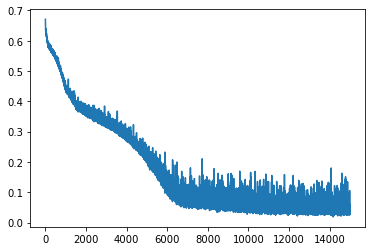

In [35]:
plt.plot(history.history['loss'])

In [ ]:
# force fit with custom loss

In [36]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(100,activation = 'relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

model.compile(loss=customLoss2, optimizer=tf.optimizers.Adam(learning_rate=.001))

In [37]:
history = model.fit(xtrain_sc[:10], ytrain_sc[:10], epochs=1000,verbose=2,batch_size=2)

Epoch 1/1000
5/5 - 0s - loss: 0.8034
Epoch 2/1000
5/5 - 0s - loss: 0.6027
Epoch 3/1000
5/5 - 0s - loss: 0.6080
Epoch 4/1000
5/5 - 0s - loss: 0.6077
Epoch 5/1000
5/5 - 0s - loss: 0.5997
Epoch 6/1000
5/5 - 0s - loss: 0.5800
Epoch 7/1000
5/5 - 0s - loss: 0.5520
Epoch 8/1000
5/5 - 0s - loss: 0.5097
Epoch 9/1000
5/5 - 0s - loss: 0.4792
Epoch 10/1000
5/5 - 0s - loss: 0.5501
Epoch 11/1000
5/5 - 0s - loss: 0.4698
Epoch 12/1000
5/5 - 0s - loss: 0.4712
Epoch 13/1000
5/5 - 0s - loss: 0.4745
Epoch 14/1000
5/5 - 0s - loss: 0.4871
Epoch 15/1000
5/5 - 0s - loss: 0.4857
Epoch 16/1000
5/5 - 0s - loss: 0.4705
Epoch 17/1000
5/5 - 0s - loss: 0.4763
Epoch 18/1000
5/5 - 0s - loss: 0.4648
Epoch 19/1000
5/5 - 0s - loss: 0.4738
Epoch 20/1000
5/5 - 0s - loss: 0.4924
Epoch 21/1000
5/5 - 0s - loss: 0.4604
Epoch 22/1000
5/5 - 0s - loss: 0.5048
Epoch 23/1000
5/5 - 0s - loss: 0.4768
Epoch 24/1000
5/5 - 0s - loss: 0.4699
Epoch 25/1000
5/5 - 0s - loss: 0.4577
Epoch 26/1000
5/5 - 0s - loss: 0.4550
Epoch 27/1000
5/5 - 0

Epoch 214/1000
5/5 - 0s - loss: 0.1533
Epoch 215/1000
5/5 - 0s - loss: 0.1877
Epoch 216/1000
5/5 - 0s - loss: 0.1537
Epoch 217/1000
5/5 - 0s - loss: 0.1686
Epoch 218/1000
5/5 - 0s - loss: 0.3681
Epoch 219/1000
5/5 - 0s - loss: 0.2793
Epoch 220/1000
5/5 - 0s - loss: 0.2356
Epoch 221/1000
5/5 - 0s - loss: 0.1137
Epoch 222/1000
5/5 - 0s - loss: 0.2236
Epoch 223/1000
5/5 - 0s - loss: 0.1272
Epoch 224/1000
5/5 - 0s - loss: 0.1558
Epoch 225/1000
5/5 - 0s - loss: 0.1867
Epoch 226/1000
5/5 - 0s - loss: 0.1229
Epoch 227/1000
5/5 - 0s - loss: 0.1842
Epoch 228/1000
5/5 - 0s - loss: 0.1584
Epoch 229/1000
5/5 - 0s - loss: 0.1840
Epoch 230/1000
5/5 - 0s - loss: 0.1511
Epoch 231/1000
5/5 - 0s - loss: 0.1177
Epoch 232/1000
5/5 - 0s - loss: 0.2162
Epoch 233/1000
5/5 - 0s - loss: 0.1404
Epoch 234/1000
5/5 - 0s - loss: 0.1055
Epoch 235/1000
5/5 - 0s - loss: 0.2064
Epoch 236/1000
5/5 - 0s - loss: 0.1449
Epoch 237/1000
5/5 - 0s - loss: 0.1162
Epoch 238/1000
5/5 - 0s - loss: 0.1434
Epoch 239/1000
5/5 - 0s -

Epoch 425/1000
5/5 - 0s - loss: 0.0305
Epoch 426/1000
5/5 - 0s - loss: 0.0312
Epoch 427/1000
5/5 - 0s - loss: 0.0306
Epoch 428/1000
5/5 - 0s - loss: 0.0307
Epoch 429/1000
5/5 - 0s - loss: 0.0305
Epoch 430/1000
5/5 - 0s - loss: 0.0307
Epoch 431/1000
5/5 - 0s - loss: 0.0306
Epoch 432/1000
5/5 - 0s - loss: 0.0306
Epoch 433/1000
5/5 - 0s - loss: 0.0305
Epoch 434/1000
5/5 - 0s - loss: 0.0307
Epoch 435/1000
5/5 - 0s - loss: 0.0312
Epoch 436/1000
5/5 - 0s - loss: 0.0308
Epoch 437/1000
5/5 - 0s - loss: 0.0302
Epoch 438/1000
5/5 - 0s - loss: 0.0304
Epoch 439/1000
5/5 - 0s - loss: 0.0302
Epoch 440/1000
5/5 - 0s - loss: 0.0305
Epoch 441/1000
5/5 - 0s - loss: 0.0307
Epoch 442/1000
5/5 - 0s - loss: 0.0301
Epoch 443/1000
5/5 - 0s - loss: 0.0302
Epoch 444/1000
5/5 - 0s - loss: 0.0303
Epoch 445/1000
5/5 - 0s - loss: 0.0304
Epoch 446/1000
5/5 - 0s - loss: 0.0299
Epoch 447/1000
5/5 - 0s - loss: 0.0305
Epoch 448/1000
5/5 - 0s - loss: 0.0302
Epoch 449/1000
5/5 - 0s - loss: 0.0305
Epoch 450/1000
5/5 - 0s -

Epoch 636/1000
5/5 - 0s - loss: 0.0279
Epoch 637/1000
5/5 - 0s - loss: 0.0279
Epoch 638/1000
5/5 - 0s - loss: 0.0280
Epoch 639/1000
5/5 - 0s - loss: 0.0279
Epoch 640/1000
5/5 - 0s - loss: 0.0279
Epoch 641/1000
5/5 - 0s - loss: 0.0280
Epoch 642/1000
5/5 - 0s - loss: 0.0279
Epoch 643/1000
5/5 - 0s - loss: 0.0279
Epoch 644/1000
5/5 - 0s - loss: 0.0279
Epoch 645/1000
5/5 - 0s - loss: 0.0279
Epoch 646/1000
5/5 - 0s - loss: 0.0279
Epoch 647/1000
5/5 - 0s - loss: 0.0278
Epoch 648/1000
5/5 - 0s - loss: 0.0279
Epoch 649/1000
5/5 - 0s - loss: 0.0278
Epoch 650/1000
5/5 - 0s - loss: 0.0278
Epoch 651/1000
5/5 - 0s - loss: 0.0278
Epoch 652/1000
5/5 - 0s - loss: 0.0279
Epoch 653/1000
5/5 - 0s - loss: 0.0279
Epoch 654/1000
5/5 - 0s - loss: 0.0279
Epoch 655/1000
5/5 - 0s - loss: 0.0279
Epoch 656/1000
5/5 - 0s - loss: 0.0278
Epoch 657/1000
5/5 - 0s - loss: 0.0279
Epoch 658/1000
5/5 - 0s - loss: 0.0278
Epoch 659/1000
5/5 - 0s - loss: 0.0278
Epoch 660/1000
5/5 - 0s - loss: 0.0278
Epoch 661/1000
5/5 - 0s -

5/5 - 0s - loss: 0.0274
Epoch 847/1000
5/5 - 0s - loss: 0.0274
Epoch 848/1000
5/5 - 0s - loss: 0.0274
Epoch 849/1000
5/5 - 0s - loss: 0.0274
Epoch 850/1000
5/5 - 0s - loss: 0.0274
Epoch 851/1000
5/5 - 0s - loss: 0.0274
Epoch 852/1000
5/5 - 0s - loss: 0.0274
Epoch 853/1000
5/5 - 0s - loss: 0.0274
Epoch 854/1000
5/5 - 0s - loss: 0.0274
Epoch 855/1000
5/5 - 0s - loss: 0.0274
Epoch 856/1000
5/5 - 0s - loss: 0.0274
Epoch 857/1000
5/5 - 0s - loss: 0.0274
Epoch 858/1000
5/5 - 0s - loss: 0.0274
Epoch 859/1000
5/5 - 0s - loss: 0.0274
Epoch 860/1000
5/5 - 0s - loss: 0.0274
Epoch 861/1000
5/5 - 0s - loss: 0.0274
Epoch 862/1000
5/5 - 0s - loss: 0.0274
Epoch 863/1000
5/5 - 0s - loss: 0.0274
Epoch 864/1000
5/5 - 0s - loss: 0.0274
Epoch 865/1000
5/5 - 0s - loss: 0.0274
Epoch 866/1000
5/5 - 0s - loss: 0.0274
Epoch 867/1000
5/5 - 0s - loss: 0.0274
Epoch 868/1000
5/5 - 0s - loss: 0.0274
Epoch 869/1000
5/5 - 0s - loss: 0.0274
Epoch 870/1000
5/5 - 0s - loss: 0.0274
Epoch 871/1000
5/5 - 0s - loss: 0.0274
E

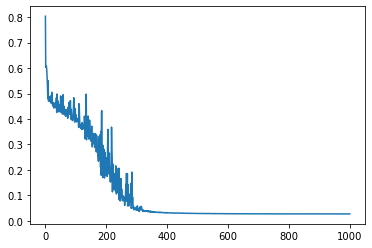

In [38]:
plt.plot(history.history['loss'])

In [39]:
preds = model.predict(xtrain_sc[:10])

In [40]:
preds

array([[ 1.       ],
       [ 1.       ],
       [ 0.992085 ],
       [-0.9868753],
       [ 0.996006 ],
       [ 0.9966773],
       [-0.9321893],
       [ 0.6068166],
       [ 0.9840063],
       [ 0.999999 ]], dtype=float32)

In [41]:
ytrain_sc[:10]

array([[-0.23024617],
       [ 0.93313522],
       [ 1.18659966],
       [-1.22128758],
       [ 0.19510173],
       [ 1.14080908],
       [-0.16909149],
       [-0.01251731],
       [ 1.20068527],
       [-0.12231202]])

In [42]:
customLoss2(ytrain_sc[:10],preds)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[2.12053204e-01],
       [0.00000000e+00],
       [8.82089127e-05],
       [2.56930075e-04],
       [6.07205620e-07],
       [1.43685707e-05],
       [1.31474075e-04],
       [4.04533763e-04],
       [3.68771233e-04],
       [5.98408554e-02]])>

In [ ]:
######## try on entire training set

In [43]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(100,activation = 'relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

model.compile(loss=customLoss2, optimizer=tf.optimizers.Adam(learning_rate=.001))

In [44]:
history = model.fit(xtrain_sc, ytrain_sc, epochs=5000,verbose=2,batch_size=int(len(xtrain_sc)/5))

Epoch 1/5000
6/6 - 0s - loss: 1.0035
Epoch 2/5000
6/6 - 0s - loss: 0.9941
Epoch 3/5000
6/6 - 0s - loss: 1.0023
Epoch 4/5000
6/6 - 0s - loss: 0.9917
Epoch 5/5000
6/6 - 0s - loss: 1.0374
Epoch 6/5000
6/6 - 0s - loss: 1.0383
Epoch 7/5000
6/6 - 0s - loss: 1.0892
Epoch 8/5000
6/6 - 0s - loss: 1.1063
Epoch 9/5000
6/6 - 0s - loss: 1.1157
Epoch 10/5000
6/6 - 0s - loss: 1.2613
Epoch 11/5000
6/6 - 0s - loss: 1.2834
Epoch 12/5000
6/6 - 0s - loss: 1.2465
Epoch 13/5000
6/6 - 0s - loss: 1.2115
Epoch 14/5000
6/6 - 0s - loss: 1.1606
Epoch 15/5000
6/6 - 0s - loss: 1.0935
Epoch 16/5000
6/6 - 0s - loss: 1.0976
Epoch 17/5000
6/6 - 0s - loss: 1.0468
Epoch 18/5000
6/6 - 0s - loss: 1.0383
Epoch 19/5000
6/6 - 0s - loss: 1.0266
Epoch 20/5000
6/6 - 0s - loss: 1.0394
Epoch 21/5000
6/6 - 0s - loss: 1.0422
Epoch 22/5000
6/6 - 0s - loss: 1.0057
Epoch 23/5000
6/6 - 0s - loss: 1.0064
Epoch 24/5000
6/6 - 0s - loss: 1.0287
Epoch 25/5000
6/6 - 0s - loss: 1.0171
Epoch 26/5000
6/6 - 0s - loss: 1.0023
Epoch 27/5000
6/6 - 0

Epoch 214/5000
6/6 - 0s - loss: 0.9857
Epoch 215/5000
6/6 - 0s - loss: 0.9901
Epoch 216/5000
6/6 - 0s - loss: 0.9886
Epoch 217/5000
6/6 - 0s - loss: 0.9817
Epoch 218/5000
6/6 - 0s - loss: 0.9766
Epoch 219/5000
6/6 - 0s - loss: 0.9726
Epoch 220/5000
6/6 - 0s - loss: 0.9729
Epoch 221/5000
6/6 - 0s - loss: 0.9782
Epoch 222/5000
6/6 - 0s - loss: 0.9808
Epoch 223/5000
6/6 - 0s - loss: 0.9852
Epoch 224/5000
6/6 - 0s - loss: 0.9808
Epoch 225/5000
6/6 - 0s - loss: 0.9783
Epoch 226/5000
6/6 - 0s - loss: 0.9797
Epoch 227/5000
6/6 - 0s - loss: 0.9812
Epoch 228/5000
6/6 - 0s - loss: 0.9779
Epoch 229/5000
6/6 - 0s - loss: 0.9733
Epoch 230/5000
6/6 - 0s - loss: 0.9729
Epoch 231/5000
6/6 - 0s - loss: 0.9824
Epoch 232/5000
6/6 - 0s - loss: 1.0019
Epoch 233/5000
6/6 - 0s - loss: 1.0209
Epoch 234/5000
6/6 - 0s - loss: 1.0220
Epoch 235/5000
6/6 - 0s - loss: 1.0093
Epoch 236/5000
6/6 - 0s - loss: 1.0003
Epoch 237/5000
6/6 - 0s - loss: 1.0077
Epoch 238/5000
6/6 - 0s - loss: 1.0054
Epoch 239/5000
6/6 - 0s -

Epoch 425/5000
6/6 - 0s - loss: 0.9725
Epoch 426/5000
6/6 - 0s - loss: 0.9790
Epoch 427/5000
6/6 - 0s - loss: 0.9845
Epoch 428/5000
6/6 - 0s - loss: 0.9842
Epoch 429/5000
6/6 - 0s - loss: 0.9821
Epoch 430/5000
6/6 - 0s - loss: 0.9784
Epoch 431/5000
6/6 - 0s - loss: 0.9821
Epoch 432/5000
6/6 - 0s - loss: 0.9898
Epoch 433/5000
6/6 - 0s - loss: 0.9990
Epoch 434/5000
6/6 - 0s - loss: 0.9967
Epoch 435/5000
6/6 - 0s - loss: 0.9897
Epoch 436/5000
6/6 - 0s - loss: 0.9823
Epoch 437/5000
6/6 - 0s - loss: 0.9774
Epoch 438/5000
6/6 - 0s - loss: 0.9755
Epoch 439/5000
6/6 - 0s - loss: 0.9785
Epoch 440/5000
6/6 - 0s - loss: 0.9790
Epoch 441/5000
6/6 - 0s - loss: 0.9781
Epoch 442/5000
6/6 - 0s - loss: 0.9758
Epoch 443/5000
6/6 - 0s - loss: 0.9735
Epoch 444/5000
6/6 - 0s - loss: 0.9711
Epoch 445/5000
6/6 - 0s - loss: 0.9694
Epoch 446/5000
6/6 - 0s - loss: 0.9721
Epoch 447/5000
6/6 - 0s - loss: 0.9745
Epoch 448/5000
6/6 - 0s - loss: 0.9723
Epoch 449/5000
6/6 - 0s - loss: 0.9726
Epoch 450/5000
6/6 - 0s -

Epoch 636/5000
6/6 - 0s - loss: 0.9869
Epoch 637/5000
6/6 - 0s - loss: 0.9809
Epoch 638/5000
6/6 - 0s - loss: 0.9732
Epoch 639/5000
6/6 - 0s - loss: 0.9709
Epoch 640/5000
6/6 - 0s - loss: 0.9708
Epoch 641/5000
6/6 - 0s - loss: 0.9712
Epoch 642/5000
6/6 - 0s - loss: 0.9717
Epoch 643/5000
6/6 - 0s - loss: 0.9710
Epoch 644/5000
6/6 - 0s - loss: 0.9758
Epoch 645/5000
6/6 - 0s - loss: 0.9779
Epoch 646/5000
6/6 - 0s - loss: 0.9784
Epoch 647/5000
6/6 - 0s - loss: 0.9775
Epoch 648/5000
6/6 - 0s - loss: 0.9757
Epoch 649/5000
6/6 - 0s - loss: 0.9760
Epoch 650/5000
6/6 - 0s - loss: 0.9780
Epoch 651/5000
6/6 - 0s - loss: 0.9788
Epoch 652/5000
6/6 - 0s - loss: 0.9777
Epoch 653/5000
6/6 - 0s - loss: 0.9756
Epoch 654/5000
6/6 - 0s - loss: 0.9735
Epoch 655/5000
6/6 - 0s - loss: 0.9701
Epoch 656/5000
6/6 - 0s - loss: 0.9681
Epoch 657/5000
6/6 - 0s - loss: 0.9670
Epoch 658/5000
6/6 - 0s - loss: 0.9658
Epoch 659/5000
6/6 - 0s - loss: 0.9645
Epoch 660/5000
6/6 - 0s - loss: 0.9677
Epoch 661/5000
6/6 - 0s -

Epoch 847/5000
6/6 - 0s - loss: 0.9665
Epoch 848/5000
6/6 - 0s - loss: 0.9681
Epoch 849/5000
6/6 - 0s - loss: 0.9697
Epoch 850/5000
6/6 - 0s - loss: 0.9697
Epoch 851/5000
6/6 - 0s - loss: 0.9720
Epoch 852/5000
6/6 - 0s - loss: 0.9759
Epoch 853/5000
6/6 - 0s - loss: 0.9753
Epoch 854/5000
6/6 - 0s - loss: 0.9725
Epoch 855/5000
6/6 - 0s - loss: 0.9703
Epoch 856/5000
6/6 - 0s - loss: 0.9738
Epoch 857/5000
6/6 - 0s - loss: 0.9754
Epoch 858/5000
6/6 - 0s - loss: 0.9729
Epoch 859/5000
6/6 - 0s - loss: 0.9694
Epoch 860/5000
6/6 - 0s - loss: 0.9681
Epoch 861/5000
6/6 - 0s - loss: 0.9673
Epoch 862/5000
6/6 - 0s - loss: 0.9663
Epoch 863/5000
6/6 - 0s - loss: 0.9655
Epoch 864/5000
6/6 - 0s - loss: 0.9651
Epoch 865/5000
6/6 - 0s - loss: 0.9648
Epoch 866/5000
6/6 - 0s - loss: 0.9643
Epoch 867/5000
6/6 - 0s - loss: 0.9640
Epoch 868/5000
6/6 - 0s - loss: 0.9639
Epoch 869/5000
6/6 - 0s - loss: 0.9652
Epoch 870/5000
6/6 - 0s - loss: 0.9648
Epoch 871/5000
6/6 - 0s - loss: 0.9708
Epoch 872/5000
6/6 - 0s -

Epoch 1056/5000
6/6 - 0s - loss: 0.9682
Epoch 1057/5000
6/6 - 0s - loss: 0.9739
Epoch 1058/5000
6/6 - 0s - loss: 0.9767
Epoch 1059/5000
6/6 - 0s - loss: 0.9749
Epoch 1060/5000
6/6 - 0s - loss: 0.9707
Epoch 1061/5000
6/6 - 0s - loss: 0.9718
Epoch 1062/5000
6/6 - 0s - loss: 0.9729
Epoch 1063/5000
6/6 - 0s - loss: 0.9716
Epoch 1064/5000
6/6 - 0s - loss: 0.9699
Epoch 1065/5000
6/6 - 0s - loss: 0.9683
Epoch 1066/5000
6/6 - 0s - loss: 0.9665
Epoch 1067/5000
6/6 - 0s - loss: 0.9699
Epoch 1068/5000
6/6 - 0s - loss: 0.9740
Epoch 1069/5000
6/6 - 0s - loss: 0.9737
Epoch 1070/5000
6/6 - 0s - loss: 0.9710
Epoch 1071/5000
6/6 - 0s - loss: 0.9694
Epoch 1072/5000
6/6 - 0s - loss: 0.9689
Epoch 1073/5000
6/6 - 0s - loss: 0.9705
Epoch 1074/5000
6/6 - 0s - loss: 0.9713
Epoch 1075/5000
6/6 - 0s - loss: 0.9675
Epoch 1076/5000
6/6 - 0s - loss: 0.9708
Epoch 1077/5000
6/6 - 0s - loss: 0.9758
Epoch 1078/5000
6/6 - 0s - loss: 0.9781
Epoch 1079/5000
6/6 - 0s - loss: 0.9746
Epoch 1080/5000
6/6 - 0s - loss: 0.9723


Epoch 1261/5000
6/6 - 0s - loss: 0.9650
Epoch 1262/5000
6/6 - 0s - loss: 0.9629
Epoch 1263/5000
6/6 - 0s - loss: 0.9602
Epoch 1264/5000
6/6 - 0s - loss: 0.9585
Epoch 1265/5000
6/6 - 0s - loss: 0.9577
Epoch 1266/5000
6/6 - 0s - loss: 0.9585
Epoch 1267/5000
6/6 - 0s - loss: 0.9618
Epoch 1268/5000
6/6 - 0s - loss: 0.9662
Epoch 1269/5000
6/6 - 0s - loss: 0.9693
Epoch 1270/5000
6/6 - 0s - loss: 0.9717
Epoch 1271/5000
6/6 - 0s - loss: 0.9740
Epoch 1272/5000
6/6 - 0s - loss: 0.9777
Epoch 1273/5000
6/6 - 0s - loss: 0.9776
Epoch 1274/5000
6/6 - 0s - loss: 0.9758
Epoch 1275/5000
6/6 - 0s - loss: 0.9762
Epoch 1276/5000
6/6 - 0s - loss: 0.9852
Epoch 1277/5000
6/6 - 0s - loss: 1.0004
Epoch 1278/5000
6/6 - 0s - loss: 1.0095
Epoch 1279/5000
6/6 - 0s - loss: 1.0017
Epoch 1280/5000
6/6 - 0s - loss: 0.9874
Epoch 1281/5000
6/6 - 0s - loss: 0.9786
Epoch 1282/5000
6/6 - 0s - loss: 0.9727
Epoch 1283/5000
6/6 - 0s - loss: 0.9641
Epoch 1284/5000
6/6 - 0s - loss: 0.9605
Epoch 1285/5000
6/6 - 0s - loss: 0.9598


Epoch 1466/5000
6/6 - 0s - loss: 0.9586
Epoch 1467/5000
6/6 - 0s - loss: 0.9540
Epoch 1468/5000
6/6 - 0s - loss: 0.9511
Epoch 1469/5000
6/6 - 0s - loss: 0.9528
Epoch 1470/5000
6/6 - 0s - loss: 0.9693
Epoch 1471/5000
6/6 - 0s - loss: 0.9826
Epoch 1472/5000
6/6 - 0s - loss: 0.9890
Epoch 1473/5000
6/6 - 0s - loss: 0.9907
Epoch 1474/5000
6/6 - 0s - loss: 0.9884
Epoch 1475/5000
6/6 - 0s - loss: 0.9806
Epoch 1476/5000
6/6 - 0s - loss: 0.9849
Epoch 1477/5000
6/6 - 0s - loss: 1.0010
Epoch 1478/5000
6/6 - 0s - loss: 0.9914
Epoch 1479/5000
6/6 - 0s - loss: 0.9922
Epoch 1480/5000
6/6 - 0s - loss: 0.9968
Epoch 1481/5000
6/6 - 0s - loss: 1.0048
Epoch 1482/5000
6/6 - 0s - loss: 1.0119
Epoch 1483/5000
6/6 - 0s - loss: 1.0083
Epoch 1484/5000
6/6 - 0s - loss: 1.0000
Epoch 1485/5000
6/6 - 0s - loss: 0.9894
Epoch 1486/5000
6/6 - 0s - loss: 0.9788
Epoch 1487/5000
6/6 - 0s - loss: 0.9685
Epoch 1488/5000
6/6 - 0s - loss: 0.9647
Epoch 1489/5000
6/6 - 0s - loss: 0.9661
Epoch 1490/5000
6/6 - 0s - loss: 0.9738


Epoch 1671/5000
6/6 - 0s - loss: 0.9529
Epoch 1672/5000
6/6 - 0s - loss: 0.9506
Epoch 1673/5000
6/6 - 0s - loss: 0.9487
Epoch 1674/5000
6/6 - 0s - loss: 0.9471
Epoch 1675/5000
6/6 - 0s - loss: 0.9481
Epoch 1676/5000
6/6 - 0s - loss: 0.9522
Epoch 1677/5000
6/6 - 0s - loss: 0.9522
Epoch 1678/5000
6/6 - 0s - loss: 0.9502
Epoch 1679/5000
6/6 - 0s - loss: 0.9490
Epoch 1680/5000
6/6 - 0s - loss: 0.9482
Epoch 1681/5000
6/6 - 0s - loss: 0.9482
Epoch 1682/5000
6/6 - 0s - loss: 0.9492
Epoch 1683/5000
6/6 - 0s - loss: 0.9511
Epoch 1684/5000
6/6 - 0s - loss: 0.9580
Epoch 1685/5000
6/6 - 0s - loss: 0.9713
Epoch 1686/5000
6/6 - 0s - loss: 0.9736
Epoch 1687/5000
6/6 - 0s - loss: 0.9715
Epoch 1688/5000
6/6 - 0s - loss: 0.9663
Epoch 1689/5000
6/6 - 0s - loss: 0.9630
Epoch 1690/5000
6/6 - 0s - loss: 0.9606
Epoch 1691/5000
6/6 - 0s - loss: 0.9593
Epoch 1692/5000
6/6 - 0s - loss: 0.9591
Epoch 1693/5000
6/6 - 0s - loss: 0.9582
Epoch 1694/5000
6/6 - 0s - loss: 0.9527
Epoch 1695/5000
6/6 - 0s - loss: 0.9548


Epoch 1876/5000
6/6 - 0s - loss: 0.9534
Epoch 1877/5000
6/6 - 0s - loss: 0.9671
Epoch 1878/5000
6/6 - 0s - loss: 1.0052
Epoch 1879/5000
6/6 - 0s - loss: 1.0490
Epoch 1880/5000
6/6 - 0s - loss: 1.0600
Epoch 1881/5000
6/6 - 0s - loss: 1.0451
Epoch 1882/5000
6/6 - 0s - loss: 1.0123
Epoch 1883/5000
6/6 - 0s - loss: 0.9922
Epoch 1884/5000
6/6 - 0s - loss: 0.9873
Epoch 1885/5000
6/6 - 0s - loss: 0.9775
Epoch 1886/5000
6/6 - 0s - loss: 0.9708
Epoch 1887/5000
6/6 - 0s - loss: 0.9682
Epoch 1888/5000
6/6 - 0s - loss: 0.9652
Epoch 1889/5000
6/6 - 0s - loss: 0.9622
Epoch 1890/5000
6/6 - 0s - loss: 0.9597
Epoch 1891/5000
6/6 - 0s - loss: 0.9597
Epoch 1892/5000
6/6 - 0s - loss: 0.9613
Epoch 1893/5000
6/6 - 0s - loss: 0.9613
Epoch 1894/5000
6/6 - 0s - loss: 0.9618
Epoch 1895/5000
6/6 - 0s - loss: 0.9626
Epoch 1896/5000
6/6 - 0s - loss: 0.9639
Epoch 1897/5000
6/6 - 0s - loss: 0.9639
Epoch 1898/5000
6/6 - 0s - loss: 0.9668
Epoch 1899/5000
6/6 - 0s - loss: 0.9804
Epoch 1900/5000
6/6 - 0s - loss: 0.9763


Epoch 2081/5000
6/6 - 0s - loss: 0.9903
Epoch 2082/5000
6/6 - 0s - loss: 0.9935
Epoch 2083/5000
6/6 - 0s - loss: 0.9872
Epoch 2084/5000
6/6 - 0s - loss: 0.9782
Epoch 2085/5000
6/6 - 0s - loss: 0.9702
Epoch 2086/5000
6/6 - 0s - loss: 0.9662
Epoch 2087/5000
6/6 - 0s - loss: 0.9606
Epoch 2088/5000
6/6 - 0s - loss: 0.9596
Epoch 2089/5000
6/6 - 0s - loss: 0.9572
Epoch 2090/5000
6/6 - 0s - loss: 0.9546
Epoch 2091/5000
6/6 - 0s - loss: 0.9537
Epoch 2092/5000
6/6 - 0s - loss: 0.9567
Epoch 2093/5000
6/6 - 0s - loss: 0.9569
Epoch 2094/5000
6/6 - 0s - loss: 0.9594
Epoch 2095/5000
6/6 - 0s - loss: 0.9646
Epoch 2096/5000
6/6 - 0s - loss: 0.9698
Epoch 2097/5000
6/6 - 0s - loss: 0.9692
Epoch 2098/5000
6/6 - 0s - loss: 0.9625
Epoch 2099/5000
6/6 - 0s - loss: 0.9574
Epoch 2100/5000
6/6 - 0s - loss: 0.9534
Epoch 2101/5000
6/6 - 0s - loss: 0.9503
Epoch 2102/5000
6/6 - 0s - loss: 0.9489
Epoch 2103/5000
6/6 - 0s - loss: 0.9485
Epoch 2104/5000
6/6 - 0s - loss: 0.9484
Epoch 2105/5000
6/6 - 0s - loss: 0.9474


Epoch 2286/5000
6/6 - 0s - loss: 0.9436
Epoch 2287/5000
6/6 - 0s - loss: 0.9421
Epoch 2288/5000
6/6 - 0s - loss: 0.9412
Epoch 2289/5000
6/6 - 0s - loss: 0.9409
Epoch 2290/5000
6/6 - 0s - loss: 0.9403
Epoch 2291/5000
6/6 - 0s - loss: 0.9546
Epoch 2292/5000
6/6 - 0s - loss: 0.9863
Epoch 2293/5000
6/6 - 0s - loss: 0.9919
Epoch 2294/5000
6/6 - 0s - loss: 0.9828
Epoch 2295/5000
6/6 - 0s - loss: 0.9712
Epoch 2296/5000
6/6 - 0s - loss: 0.9731
Epoch 2297/5000
6/6 - 0s - loss: 0.9853
Epoch 2298/5000
6/6 - 0s - loss: 0.9781
Epoch 2299/5000
6/6 - 0s - loss: 0.9657
Epoch 2300/5000
6/6 - 0s - loss: 0.9803
Epoch 2301/5000
6/6 - 0s - loss: 1.0012
Epoch 2302/5000
6/6 - 0s - loss: 0.9902
Epoch 2303/5000
6/6 - 0s - loss: 0.9742
Epoch 2304/5000
6/6 - 0s - loss: 0.9633
Epoch 2305/5000
6/6 - 0s - loss: 0.9581
Epoch 2306/5000
6/6 - 0s - loss: 0.9546
Epoch 2307/5000
6/6 - 0s - loss: 0.9525
Epoch 2308/5000
6/6 - 0s - loss: 0.9515
Epoch 2309/5000
6/6 - 0s - loss: 0.9510
Epoch 2310/5000
6/6 - 0s - loss: 0.9512


Epoch 2491/5000
6/6 - 0s - loss: 0.9585
Epoch 2492/5000
6/6 - 0s - loss: 0.9509
Epoch 2493/5000
6/6 - 0s - loss: 0.9451
Epoch 2494/5000
6/6 - 0s - loss: 0.9411
Epoch 2495/5000
6/6 - 0s - loss: 0.9392
Epoch 2496/5000
6/6 - 0s - loss: 0.9373
Epoch 2497/5000
6/6 - 0s - loss: 0.9362
Epoch 2498/5000
6/6 - 0s - loss: 0.9374
Epoch 2499/5000
6/6 - 0s - loss: 0.9408
Epoch 2500/5000
6/6 - 0s - loss: 0.9437
Epoch 2501/5000
6/6 - 0s - loss: 0.9379
Epoch 2502/5000
6/6 - 0s - loss: 0.9394
Epoch 2503/5000
6/6 - 0s - loss: 0.9443
Epoch 2504/5000
6/6 - 0s - loss: 0.9482
Epoch 2505/5000
6/6 - 0s - loss: 0.9514
Epoch 2506/5000
6/6 - 0s - loss: 0.9621
Epoch 2507/5000
6/6 - 0s - loss: 0.9731
Epoch 2508/5000
6/6 - 0s - loss: 0.9664
Epoch 2509/5000
6/6 - 0s - loss: 0.9562
Epoch 2510/5000
6/6 - 0s - loss: 0.9507
Epoch 2511/5000
6/6 - 0s - loss: 0.9469
Epoch 2512/5000
6/6 - 0s - loss: 0.9445
Epoch 2513/5000
6/6 - 0s - loss: 0.9409
Epoch 2514/5000
6/6 - 0s - loss: 0.9398
Epoch 2515/5000
6/6 - 0s - loss: 0.9386


Epoch 2696/5000
6/6 - 0s - loss: 0.9349
Epoch 2697/5000
6/6 - 0s - loss: 0.9332
Epoch 2698/5000
6/6 - 0s - loss: 0.9328
Epoch 2699/5000
6/6 - 0s - loss: 0.9456
Epoch 2700/5000
6/6 - 0s - loss: 0.9517
Epoch 2701/5000
6/6 - 0s - loss: 0.9480
Epoch 2702/5000
6/6 - 0s - loss: 0.9426
Epoch 2703/5000
6/6 - 0s - loss: 0.9410
Epoch 2704/5000
6/6 - 0s - loss: 0.9405
Epoch 2705/5000
6/6 - 0s - loss: 0.9421
Epoch 2706/5000
6/6 - 0s - loss: 0.9420
Epoch 2707/5000
6/6 - 0s - loss: 0.9397
Epoch 2708/5000
6/6 - 0s - loss: 0.9477
Epoch 2709/5000
6/6 - 0s - loss: 0.9775
Epoch 2710/5000
6/6 - 0s - loss: 0.9842
Epoch 2711/5000
6/6 - 0s - loss: 0.9770
Epoch 2712/5000
6/6 - 0s - loss: 0.9649
Epoch 2713/5000
6/6 - 0s - loss: 0.9553
Epoch 2714/5000
6/6 - 0s - loss: 0.9503
Epoch 2715/5000
6/6 - 0s - loss: 0.9436
Epoch 2716/5000
6/6 - 0s - loss: 0.9413
Epoch 2717/5000
6/6 - 0s - loss: 0.9424
Epoch 2718/5000
6/6 - 0s - loss: 0.9407
Epoch 2719/5000
6/6 - 0s - loss: 0.9377
Epoch 2720/5000
6/6 - 0s - loss: 0.9356


Epoch 2901/5000
6/6 - 0s - loss: 0.9562
Epoch 2902/5000
6/6 - 0s - loss: 0.9564
Epoch 2903/5000
6/6 - 0s - loss: 0.9536
Epoch 2904/5000
6/6 - 0s - loss: 0.9515
Epoch 2905/5000
6/6 - 0s - loss: 0.9502
Epoch 2906/5000
6/6 - 0s - loss: 0.9484
Epoch 2907/5000
6/6 - 0s - loss: 0.9468
Epoch 2908/5000
6/6 - 0s - loss: 0.9461
Epoch 2909/5000
6/6 - 0s - loss: 0.9453
Epoch 2910/5000
6/6 - 0s - loss: 0.9442
Epoch 2911/5000
6/6 - 0s - loss: 0.9439
Epoch 2912/5000
6/6 - 0s - loss: 0.9436
Epoch 2913/5000
6/6 - 0s - loss: 0.9429
Epoch 2914/5000
6/6 - 0s - loss: 0.9439
Epoch 2915/5000
6/6 - 0s - loss: 0.9517
Epoch 2916/5000
6/6 - 0s - loss: 0.9585
Epoch 2917/5000
6/6 - 0s - loss: 0.9645
Epoch 2918/5000
6/6 - 0s - loss: 0.9658
Epoch 2919/5000
6/6 - 0s - loss: 0.9680
Epoch 2920/5000
6/6 - 0s - loss: 0.9666
Epoch 2921/5000
6/6 - 0s - loss: 0.9631
Epoch 2922/5000
6/6 - 0s - loss: 0.9597
Epoch 2923/5000
6/6 - 0s - loss: 0.9567
Epoch 2924/5000
6/6 - 0s - loss: 0.9535
Epoch 2925/5000
6/6 - 0s - loss: 0.9527


Epoch 3106/5000
6/6 - 0s - loss: 0.9479
Epoch 3107/5000
6/6 - 0s - loss: 0.9446
Epoch 3108/5000
6/6 - 0s - loss: 0.9466
Epoch 3109/5000
6/6 - 0s - loss: 0.9483
Epoch 3110/5000
6/6 - 0s - loss: 0.9486
Epoch 3111/5000
6/6 - 0s - loss: 0.9440
Epoch 3112/5000
6/6 - 0s - loss: 0.9394
Epoch 3113/5000
6/6 - 0s - loss: 0.9369
Epoch 3114/5000
6/6 - 0s - loss: 0.9357
Epoch 3115/5000
6/6 - 0s - loss: 0.9359
Epoch 3116/5000
6/6 - 0s - loss: 0.9377
Epoch 3117/5000
6/6 - 0s - loss: 0.9375
Epoch 3118/5000
6/6 - 0s - loss: 0.9342
Epoch 3119/5000
6/6 - 0s - loss: 0.9321
Epoch 3120/5000
6/6 - 0s - loss: 0.9316
Epoch 3121/5000
6/6 - 0s - loss: 0.9312
Epoch 3122/5000
6/6 - 0s - loss: 0.9303
Epoch 3123/5000
6/6 - 0s - loss: 0.9305
Epoch 3124/5000
6/6 - 0s - loss: 0.9329
Epoch 3125/5000
6/6 - 0s - loss: 0.9338
Epoch 3126/5000
6/6 - 0s - loss: 0.9313
Epoch 3127/5000
6/6 - 0s - loss: 0.9300
Epoch 3128/5000
6/6 - 0s - loss: 0.9302
Epoch 3129/5000
6/6 - 0s - loss: 0.9276
Epoch 3130/5000
6/6 - 0s - loss: 0.9263


Epoch 3311/5000
6/6 - 0s - loss: 0.9445
Epoch 3312/5000
6/6 - 0s - loss: 0.9442
Epoch 3313/5000
6/6 - 0s - loss: 0.9444
Epoch 3314/5000
6/6 - 0s - loss: 0.9465
Epoch 3315/5000
6/6 - 0s - loss: 0.9516
Epoch 3316/5000
6/6 - 0s - loss: 0.9535
Epoch 3317/5000
6/6 - 0s - loss: 0.9535
Epoch 3318/5000
6/6 - 0s - loss: 0.9545
Epoch 3319/5000
6/6 - 0s - loss: 0.9447
Epoch 3320/5000
6/6 - 0s - loss: 0.9430
Epoch 3321/5000
6/6 - 0s - loss: 0.9433
Epoch 3322/5000
6/6 - 0s - loss: 0.9433
Epoch 3323/5000
6/6 - 0s - loss: 0.9417
Epoch 3324/5000
6/6 - 0s - loss: 0.9405
Epoch 3325/5000
6/6 - 0s - loss: 0.9399
Epoch 3326/5000
6/6 - 0s - loss: 0.9404
Epoch 3327/5000
6/6 - 0s - loss: 0.9384
Epoch 3328/5000
6/6 - 0s - loss: 0.9389
Epoch 3329/5000
6/6 - 0s - loss: 0.9397
Epoch 3330/5000
6/6 - 0s - loss: 0.9401
Epoch 3331/5000
6/6 - 0s - loss: 0.9389
Epoch 3332/5000
6/6 - 0s - loss: 0.9374
Epoch 3333/5000
6/6 - 0s - loss: 0.9366
Epoch 3334/5000
6/6 - 0s - loss: 0.9386
Epoch 3335/5000
6/6 - 0s - loss: 0.9428


Epoch 3516/5000
6/6 - 0s - loss: 0.9420
Epoch 3517/5000
6/6 - 0s - loss: 0.9441
Epoch 3518/5000
6/6 - 0s - loss: 0.9472
Epoch 3519/5000
6/6 - 0s - loss: 0.9510
Epoch 3520/5000
6/6 - 0s - loss: 0.9526
Epoch 3521/5000
6/6 - 0s - loss: 0.9472
Epoch 3522/5000
6/6 - 0s - loss: 0.9396
Epoch 3523/5000
6/6 - 0s - loss: 0.9323
Epoch 3524/5000
6/6 - 0s - loss: 0.9303
Epoch 3525/5000
6/6 - 0s - loss: 0.9329
Epoch 3526/5000
6/6 - 0s - loss: 0.9305
Epoch 3527/5000
6/6 - 0s - loss: 0.9258
Epoch 3528/5000
6/6 - 0s - loss: 0.9220
Epoch 3529/5000
6/6 - 0s - loss: 0.9190
Epoch 3530/5000
6/6 - 0s - loss: 0.9164
Epoch 3531/5000
6/6 - 0s - loss: 0.9150
Epoch 3532/5000
6/6 - 0s - loss: 0.9140
Epoch 3533/5000
6/6 - 0s - loss: 0.9155
Epoch 3534/5000
6/6 - 0s - loss: 0.9260
Epoch 3535/5000
6/6 - 0s - loss: 0.9337
Epoch 3536/5000
6/6 - 0s - loss: 0.9332
Epoch 3537/5000
6/6 - 0s - loss: 0.9285
Epoch 3538/5000
6/6 - 0s - loss: 0.9234
Epoch 3539/5000
6/6 - 0s - loss: 0.9198
Epoch 3540/5000
6/6 - 0s - loss: 0.9192


Epoch 3721/5000
6/6 - 0s - loss: 0.9209
Epoch 3722/5000
6/6 - 0s - loss: 0.9215
Epoch 3723/5000
6/6 - 0s - loss: 0.9203
Epoch 3724/5000
6/6 - 0s - loss: 0.9190
Epoch 3725/5000
6/6 - 0s - loss: 0.9195
Epoch 3726/5000
6/6 - 0s - loss: 0.9197
Epoch 3727/5000
6/6 - 0s - loss: 0.9190
Epoch 3728/5000
6/6 - 0s - loss: 0.9186
Epoch 3729/5000
6/6 - 0s - loss: 0.9321
Epoch 3730/5000
6/6 - 0s - loss: 0.9347
Epoch 3731/5000
6/6 - 0s - loss: 0.9275
Epoch 3732/5000
6/6 - 0s - loss: 0.9224
Epoch 3733/5000
6/6 - 0s - loss: 0.9237
Epoch 3734/5000
6/6 - 0s - loss: 0.9237
Epoch 3735/5000
6/6 - 0s - loss: 0.9218
Epoch 3736/5000
6/6 - 0s - loss: 0.9220
Epoch 3737/5000
6/6 - 0s - loss: 0.9202
Epoch 3738/5000
6/6 - 0s - loss: 0.9245
Epoch 3739/5000
6/6 - 0s - loss: 0.9435
Epoch 3740/5000
6/6 - 0s - loss: 0.9527
Epoch 3741/5000
6/6 - 0s - loss: 0.9558
Epoch 3742/5000
6/6 - 0s - loss: 0.9547
Epoch 3743/5000
6/6 - 0s - loss: 0.9526
Epoch 3744/5000
6/6 - 0s - loss: 0.9476
Epoch 3745/5000
6/6 - 0s - loss: 0.9438


Epoch 3926/5000
6/6 - 0s - loss: 0.9578
Epoch 3927/5000
6/6 - 0s - loss: 0.9736
Epoch 3928/5000
6/6 - 0s - loss: 1.0401
Epoch 3929/5000
6/6 - 0s - loss: 1.0288
Epoch 3930/5000
6/6 - 0s - loss: 1.1098
Epoch 3931/5000
6/6 - 0s - loss: 1.1374
Epoch 3932/5000
6/6 - 0s - loss: 1.1229
Epoch 3933/5000
6/6 - 0s - loss: 1.0886
Epoch 3934/5000
6/6 - 0s - loss: 1.0581
Epoch 3935/5000
6/6 - 0s - loss: 1.0226
Epoch 3936/5000
6/6 - 0s - loss: 1.0071
Epoch 3937/5000
6/6 - 0s - loss: 1.0238
Epoch 3938/5000
6/6 - 0s - loss: 1.0624
Epoch 3939/5000
6/6 - 0s - loss: 1.0624
Epoch 3940/5000
6/6 - 0s - loss: 1.0313
Epoch 3941/5000
6/6 - 0s - loss: 0.9873
Epoch 3942/5000
6/6 - 0s - loss: 1.0087
Epoch 3943/5000
6/6 - 0s - loss: 1.0184
Epoch 3944/5000
6/6 - 0s - loss: 0.9893
Epoch 3945/5000
6/6 - 0s - loss: 0.9696
Epoch 3946/5000
6/6 - 0s - loss: 0.9679
Epoch 3947/5000
6/6 - 0s - loss: 0.9715
Epoch 3948/5000
6/6 - 0s - loss: 0.9719
Epoch 3949/5000
6/6 - 0s - loss: 0.9661
Epoch 3950/5000
6/6 - 0s - loss: 0.9613


Epoch 4131/5000
6/6 - 0s - loss: 0.9479
Epoch 4132/5000
6/6 - 0s - loss: 0.9434
Epoch 4133/5000
6/6 - 0s - loss: 0.9394
Epoch 4134/5000
6/6 - 0s - loss: 0.9361
Epoch 4135/5000
6/6 - 0s - loss: 0.9334
Epoch 4136/5000
6/6 - 0s - loss: 0.9342
Epoch 4137/5000
6/6 - 0s - loss: 0.9351
Epoch 4138/5000
6/6 - 0s - loss: 0.9371
Epoch 4139/5000
6/6 - 0s - loss: 0.9412
Epoch 4140/5000
6/6 - 0s - loss: 0.9394
Epoch 4141/5000
6/6 - 0s - loss: 0.9363
Epoch 4142/5000
6/6 - 0s - loss: 0.9399
Epoch 4143/5000
6/6 - 0s - loss: 0.9429
Epoch 4144/5000
6/6 - 0s - loss: 0.9438
Epoch 4145/5000
6/6 - 0s - loss: 0.9468
Epoch 4146/5000
6/6 - 0s - loss: 0.9605
Epoch 4147/5000
6/6 - 0s - loss: 0.9777
Epoch 4148/5000
6/6 - 0s - loss: 0.9776
Epoch 4149/5000
6/6 - 0s - loss: 0.9679
Epoch 4150/5000
6/6 - 0s - loss: 0.9560
Epoch 4151/5000
6/6 - 0s - loss: 0.9478
Epoch 4152/5000
6/6 - 0s - loss: 0.9423
Epoch 4153/5000
6/6 - 0s - loss: 0.9376
Epoch 4154/5000
6/6 - 0s - loss: 0.9351
Epoch 4155/5000
6/6 - 0s - loss: 0.9363


Epoch 4336/5000
6/6 - 0s - loss: 0.9193
Epoch 4337/5000
6/6 - 0s - loss: 0.9199
Epoch 4338/5000
6/6 - 0s - loss: 0.9200
Epoch 4339/5000
6/6 - 0s - loss: 0.9196
Epoch 4340/5000
6/6 - 0s - loss: 0.9182
Epoch 4341/5000
6/6 - 0s - loss: 0.9165
Epoch 4342/5000
6/6 - 0s - loss: 0.9155
Epoch 4343/5000
6/6 - 0s - loss: 0.9143
Epoch 4344/5000
6/6 - 0s - loss: 0.9134
Epoch 4345/5000
6/6 - 0s - loss: 0.9128
Epoch 4346/5000
6/6 - 0s - loss: 0.9239
Epoch 4347/5000
6/6 - 0s - loss: 0.9502
Epoch 4348/5000
6/6 - 0s - loss: 0.9586
Epoch 4349/5000
6/6 - 0s - loss: 0.9530
Epoch 4350/5000
6/6 - 0s - loss: 0.9437
Epoch 4351/5000
6/6 - 0s - loss: 0.9380
Epoch 4352/5000
6/6 - 0s - loss: 0.9324
Epoch 4353/5000
6/6 - 0s - loss: 0.9257
Epoch 4354/5000
6/6 - 0s - loss: 0.9226
Epoch 4355/5000
6/6 - 0s - loss: 0.9190
Epoch 4356/5000
6/6 - 0s - loss: 0.9151
Epoch 4357/5000
6/6 - 0s - loss: 0.9146
Epoch 4358/5000
6/6 - 0s - loss: 0.9157
Epoch 4359/5000
6/6 - 0s - loss: 0.9177
Epoch 4360/5000
6/6 - 0s - loss: 0.9187


Epoch 4541/5000
6/6 - 0s - loss: 0.9065
Epoch 4542/5000
6/6 - 0s - loss: 0.9080
Epoch 4543/5000
6/6 - 0s - loss: 0.9081
Epoch 4544/5000
6/6 - 0s - loss: 0.9158
Epoch 4545/5000
6/6 - 0s - loss: 0.9356
Epoch 4546/5000
6/6 - 0s - loss: 0.9455
Epoch 4547/5000
6/6 - 0s - loss: 0.9477
Epoch 4548/5000
6/6 - 0s - loss: 0.9463
Epoch 4549/5000
6/6 - 0s - loss: 0.9428
Epoch 4550/5000
6/6 - 0s - loss: 0.9369
Epoch 4551/5000
6/6 - 0s - loss: 0.9319
Epoch 4552/5000
6/6 - 0s - loss: 0.9336
Epoch 4553/5000
6/6 - 0s - loss: 0.9351
Epoch 4554/5000
6/6 - 0s - loss: 0.9317
Epoch 4555/5000
6/6 - 0s - loss: 0.9262
Epoch 4556/5000
6/6 - 0s - loss: 0.9199
Epoch 4557/5000
6/6 - 0s - loss: 0.9159
Epoch 4558/5000
6/6 - 0s - loss: 0.9134
Epoch 4559/5000
6/6 - 0s - loss: 0.9128
Epoch 4560/5000
6/6 - 0s - loss: 0.9129
Epoch 4561/5000
6/6 - 0s - loss: 0.9119
Epoch 4562/5000
6/6 - 0s - loss: 0.9144
Epoch 4563/5000
6/6 - 0s - loss: 0.9149
Epoch 4564/5000
6/6 - 0s - loss: 0.9145
Epoch 4565/5000
6/6 - 0s - loss: 0.9126


Epoch 4746/5000
6/6 - 0s - loss: 0.8932
Epoch 4747/5000
6/6 - 0s - loss: 0.8965
Epoch 4748/5000
6/6 - 0s - loss: 0.9046
Epoch 4749/5000
6/6 - 0s - loss: 0.9079
Epoch 4750/5000
6/6 - 0s - loss: 0.9091
Epoch 4751/5000
6/6 - 0s - loss: 0.9102
Epoch 4752/5000
6/6 - 0s - loss: 0.9110
Epoch 4753/5000
6/6 - 0s - loss: 0.9094
Epoch 4754/5000
6/6 - 0s - loss: 0.9081
Epoch 4755/5000
6/6 - 0s - loss: 0.9053
Epoch 4756/5000
6/6 - 0s - loss: 0.9018
Epoch 4757/5000
6/6 - 0s - loss: 0.9002
Epoch 4758/5000
6/6 - 0s - loss: 0.8998
Epoch 4759/5000
6/6 - 0s - loss: 0.9010
Epoch 4760/5000
6/6 - 0s - loss: 0.9080
Epoch 4761/5000
6/6 - 0s - loss: 0.9130
Epoch 4762/5000
6/6 - 0s - loss: 0.9141
Epoch 4763/5000
6/6 - 0s - loss: 0.9116
Epoch 4764/5000
6/6 - 0s - loss: 0.9085
Epoch 4765/5000
6/6 - 0s - loss: 0.9082
Epoch 4766/5000
6/6 - 0s - loss: 0.9298
Epoch 4767/5000
6/6 - 0s - loss: 0.9368
Epoch 4768/5000
6/6 - 0s - loss: 0.9361
Epoch 4769/5000
6/6 - 0s - loss: 0.9325
Epoch 4770/5000
6/6 - 0s - loss: 0.9268


Epoch 4951/5000
6/6 - 0s - loss: 0.9133
Epoch 4952/5000
6/6 - 0s - loss: 0.9092
Epoch 4953/5000
6/6 - 0s - loss: 0.9061
Epoch 4954/5000
6/6 - 0s - loss: 0.9064
Epoch 4955/5000
6/6 - 0s - loss: 0.9169
Epoch 4956/5000
6/6 - 0s - loss: 0.9213
Epoch 4957/5000
6/6 - 0s - loss: 0.9216
Epoch 4958/5000
6/6 - 0s - loss: 0.9295
Epoch 4959/5000
6/6 - 0s - loss: 0.9392
Epoch 4960/5000
6/6 - 0s - loss: 0.9351
Epoch 4961/5000
6/6 - 0s - loss: 0.9289
Epoch 4962/5000
6/6 - 0s - loss: 0.9232
Epoch 4963/5000
6/6 - 0s - loss: 0.9177
Epoch 4964/5000
6/6 - 0s - loss: 0.9131
Epoch 4965/5000
6/6 - 0s - loss: 0.9102
Epoch 4966/5000
6/6 - 0s - loss: 0.9061
Epoch 4967/5000
6/6 - 0s - loss: 0.9018
Epoch 4968/5000
6/6 - 0s - loss: 0.8992
Epoch 4969/5000
6/6 - 0s - loss: 0.8978
Epoch 4970/5000
6/6 - 0s - loss: 0.9061
Epoch 4971/5000
6/6 - 0s - loss: 0.9181
Epoch 4972/5000
6/6 - 0s - loss: 0.9254
Epoch 4973/5000
6/6 - 0s - loss: 0.9275
Epoch 4974/5000
6/6 - 0s - loss: 0.9250
Epoch 4975/5000
6/6 - 0s - loss: 0.9205


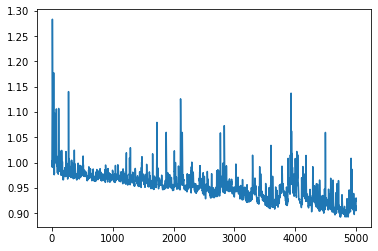

In [45]:
plt.plot(history.history['loss'])

In [46]:
preds = model.predict(xtrain_sc)
final = pd.DataFrame(preds,columns=['preds'])
final['y'] = scalerY.inverse_transform(ytrain_sc)
final['profit'] = final['preds']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

In [47]:
final.profit.mean()*np.sqrt(252)/final.profit.std()

2.196449597766798

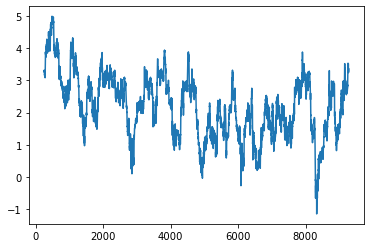

In [48]:
final.rolling_sharpe.plot()

In [ ]:
# Looks pretty good!

# Try LSTM

In [49]:
def lstm_data_transform(x_data, y_data, num_steps=10):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [50]:
num_steps = 30

xtrain_transformed, ytrain_transformed = lstm_data_transform(xtrain_sc, ytrain_sc, num_steps=num_steps)
xtest_transformed, ytest_transformed = lstm_data_transform(xtest_sc, ytest_sc, num_steps=num_steps)

In [51]:
# first test in sample

In [52]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, xtest_sc.shape[1])),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1,activation='tanh')
])
model.compile(loss=customLoss2, optimizer=tf.optimizers.Adam(learning_rate=.001))

In [53]:
xtrain_transformed.shape

(9244, 30, 7)

In [54]:
len(xtrain_transformed)

9244

In [55]:
history = model.fit(xtrain_transformed, ytrain_transformed, epochs=1000, batch_size=int(len(xtrain_transformed)/5), verbose=2)

Epoch 1/1000
6/6 - 0s - loss: 1.1171
Epoch 2/1000
6/6 - 0s - loss: 1.0826
Epoch 3/1000
6/6 - 0s - loss: 1.0590
Epoch 4/1000
6/6 - 0s - loss: 1.0468
Epoch 5/1000
6/6 - 0s - loss: 1.0384
Epoch 6/1000
6/6 - 0s - loss: 1.0344
Epoch 7/1000
6/6 - 0s - loss: 1.0305
Epoch 8/1000
6/6 - 0s - loss: 1.0279
Epoch 9/1000
6/6 - 0s - loss: 1.0269
Epoch 10/1000
6/6 - 0s - loss: 1.0259
Epoch 11/1000
6/6 - 0s - loss: 1.0236
Epoch 12/1000
6/6 - 0s - loss: 1.0227
Epoch 13/1000
6/6 - 0s - loss: 1.0222
Epoch 14/1000
6/6 - 0s - loss: 1.0226
Epoch 15/1000
6/6 - 0s - loss: 1.0221
Epoch 16/1000
6/6 - 0s - loss: 1.0211
Epoch 17/1000
6/6 - 0s - loss: 1.0197
Epoch 18/1000
6/6 - 0s - loss: 1.0192
Epoch 19/1000
6/6 - 0s - loss: 1.0180
Epoch 20/1000
6/6 - 0s - loss: 1.0174
Epoch 21/1000
6/6 - 0s - loss: 1.0191
Epoch 22/1000
6/6 - 0s - loss: 1.0211
Epoch 23/1000
6/6 - 0s - loss: 1.0213
Epoch 24/1000
6/6 - 0s - loss: 1.0195
Epoch 25/1000
6/6 - 0s - loss: 1.0164
Epoch 26/1000
6/6 - 0s - loss: 1.0163
Epoch 27/1000
6/6 - 0

Epoch 214/1000
6/6 - 0s - loss: 0.9800
Epoch 215/1000
6/6 - 0s - loss: 0.9798
Epoch 216/1000
6/6 - 0s - loss: 0.9798
Epoch 217/1000
6/6 - 0s - loss: 0.9802
Epoch 218/1000
6/6 - 0s - loss: 0.9805
Epoch 219/1000
6/6 - 0s - loss: 0.9802
Epoch 220/1000
6/6 - 0s - loss: 0.9802
Epoch 221/1000
6/6 - 0s - loss: 0.9802
Epoch 222/1000
6/6 - 0s - loss: 0.9799
Epoch 223/1000
6/6 - 0s - loss: 0.9800
Epoch 224/1000
6/6 - 0s - loss: 0.9801
Epoch 225/1000
6/6 - 0s - loss: 0.9809
Epoch 226/1000
6/6 - 0s - loss: 0.9815
Epoch 227/1000
6/6 - 0s - loss: 0.9816
Epoch 228/1000
6/6 - 0s - loss: 0.9817
Epoch 229/1000
6/6 - 0s - loss: 0.9811
Epoch 230/1000
6/6 - 0s - loss: 0.9843
Epoch 231/1000
6/6 - 0s - loss: 0.9857
Epoch 232/1000
6/6 - 0s - loss: 0.9858
Epoch 233/1000
6/6 - 0s - loss: 0.9848
Epoch 234/1000
6/6 - 0s - loss: 0.9814
Epoch 235/1000
6/6 - 0s - loss: 0.9802
Epoch 236/1000
6/6 - 0s - loss: 0.9802
Epoch 237/1000
6/6 - 0s - loss: 0.9813
Epoch 238/1000
6/6 - 0s - loss: 0.9814
Epoch 239/1000
6/6 - 0s -

6/6 - 0s - loss: 0.9739
Epoch 425/1000
6/6 - 0s - loss: 0.9723
Epoch 426/1000
6/6 - 0s - loss: 0.9718
Epoch 427/1000
6/6 - 0s - loss: 0.9760
Epoch 428/1000
6/6 - 0s - loss: 0.9830
Epoch 429/1000
6/6 - 0s - loss: 0.9838
Epoch 430/1000
6/6 - 0s - loss: 0.9839
Epoch 431/1000
6/6 - 0s - loss: 0.9837
Epoch 432/1000
6/6 - 0s - loss: 0.9826
Epoch 433/1000
6/6 - 0s - loss: 0.9814
Epoch 434/1000
6/6 - 0s - loss: 0.9798
Epoch 435/1000
6/6 - 0s - loss: 0.9781
Epoch 436/1000
6/6 - 0s - loss: 0.9773
Epoch 437/1000
6/6 - 0s - loss: 0.9764
Epoch 438/1000
6/6 - 0s - loss: 0.9784
Epoch 439/1000
6/6 - 0s - loss: 0.9811
Epoch 440/1000
6/6 - 0s - loss: 0.9821
Epoch 441/1000
6/6 - 0s - loss: 0.9825
Epoch 442/1000
6/6 - 0s - loss: 0.9819
Epoch 443/1000
6/6 - 0s - loss: 0.9809
Epoch 444/1000
6/6 - 0s - loss: 0.9802
Epoch 445/1000
6/6 - 0s - loss: 0.9796
Epoch 446/1000
6/6 - 0s - loss: 0.9799
Epoch 447/1000
6/6 - 0s - loss: 0.9800
Epoch 448/1000
6/6 - 0s - loss: 0.9789
Epoch 449/1000
6/6 - 0s - loss: 0.9770
E

Epoch 635/1000
6/6 - 0s - loss: 0.9757
Epoch 636/1000
6/6 - 0s - loss: 0.9765
Epoch 637/1000
6/6 - 0s - loss: 0.9758
Epoch 638/1000
6/6 - 0s - loss: 0.9737
Epoch 639/1000
6/6 - 0s - loss: 0.9741
Epoch 640/1000
6/6 - 0s - loss: 0.9761
Epoch 641/1000
6/6 - 0s - loss: 0.9770
Epoch 642/1000
6/6 - 0s - loss: 0.9772
Epoch 643/1000
6/6 - 0s - loss: 0.9770
Epoch 644/1000
6/6 - 0s - loss: 0.9745
Epoch 645/1000
6/6 - 0s - loss: 0.9714
Epoch 646/1000
6/6 - 0s - loss: 0.9707
Epoch 647/1000
6/6 - 0s - loss: 0.9701
Epoch 648/1000
6/6 - 0s - loss: 0.9697
Epoch 649/1000
6/6 - 0s - loss: 0.9697
Epoch 650/1000
6/6 - 0s - loss: 0.9704
Epoch 651/1000
6/6 - 0s - loss: 0.9742
Epoch 652/1000
6/6 - 0s - loss: 0.9791
Epoch 653/1000
6/6 - 0s - loss: 0.9826
Epoch 654/1000
6/6 - 0s - loss: 0.9842
Epoch 655/1000
6/6 - 0s - loss: 0.9841
Epoch 656/1000
6/6 - 0s - loss: 0.9838
Epoch 657/1000
6/6 - 0s - loss: 0.9840
Epoch 658/1000
6/6 - 0s - loss: 0.9824
Epoch 659/1000
6/6 - 0s - loss: 0.9805
Epoch 660/1000
6/6 - 0s -

6/6 - 0s - loss: 0.9775
Epoch 846/1000
6/6 - 0s - loss: 0.9778
Epoch 847/1000
6/6 - 0s - loss: 0.9775
Epoch 848/1000
6/6 - 0s - loss: 0.9760
Epoch 849/1000
6/6 - 0s - loss: 0.9741
Epoch 850/1000
6/6 - 0s - loss: 0.9731
Epoch 851/1000
6/6 - 0s - loss: 0.9737
Epoch 852/1000
6/6 - 0s - loss: 0.9742
Epoch 853/1000
6/6 - 0s - loss: 0.9738
Epoch 854/1000
6/6 - 0s - loss: 0.9729
Epoch 855/1000
6/6 - 0s - loss: 0.9712
Epoch 856/1000
6/6 - 0s - loss: 0.9689
Epoch 857/1000
6/6 - 0s - loss: 0.9673
Epoch 858/1000
6/6 - 0s - loss: 0.9664
Epoch 859/1000
6/6 - 0s - loss: 0.9652
Epoch 860/1000
6/6 - 0s - loss: 0.9644
Epoch 861/1000
6/6 - 0s - loss: 0.9672
Epoch 862/1000
6/6 - 0s - loss: 0.9753
Epoch 863/1000
6/6 - 0s - loss: 0.9816
Epoch 864/1000
6/6 - 0s - loss: 0.9839
Epoch 865/1000
6/6 - 0s - loss: 0.9833
Epoch 866/1000
6/6 - 0s - loss: 0.9819
Epoch 867/1000
6/6 - 0s - loss: 0.9825
Epoch 868/1000
6/6 - 0s - loss: 0.9839
Epoch 869/1000
6/6 - 0s - loss: 0.9840
Epoch 870/1000
6/6 - 0s - loss: 0.9841
E

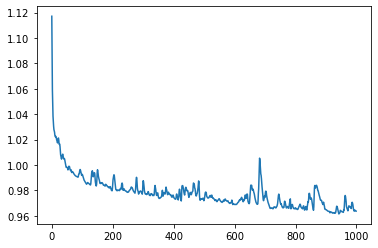

In [60]:
plt.plot(history.history['loss'])

In [61]:
# preds = model.predict(xtest_transformed)
preds = model.predict(xtrain_transformed)

avg return: 0.04202702393481264
total sharpe: 1.675940805201624


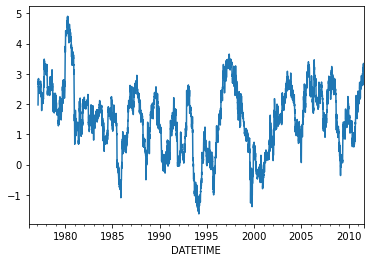

In [62]:
final = pd.DataFrame(preds,columns=['preds'],index=ytrain.iloc[num_steps:].index)
final['y'] = scalerY.inverse_transform(ytrain_sc[num_steps:])
final['profit'] = final['preds']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

print('avg return: {}'.format(final.profit.mean()*np.sqrt(252)))
print('total sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
final.rolling_sharpe.plot()

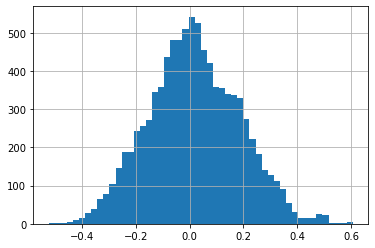

In [63]:
final.preds.hist(bins=50)

In [64]:
# out of sample

avg return: 0.00020259575586601002
total sharpe: 0.009829362845829743


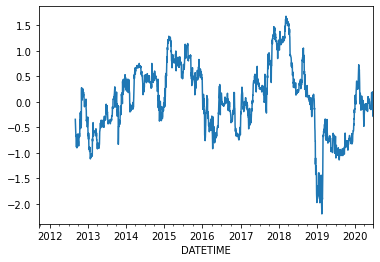

In [65]:
preds = model.predict(xtest_transformed)
final = pd.DataFrame(preds,columns=['preds'],index=ytest.iloc[num_steps:].index)
final['y'] = scalerY.inverse_transform(ytest_sc[num_steps:])
final['profit'] = final['preds']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

print('avg return: {}'.format(final.profit.mean()*np.sqrt(252)))
print('total sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
final.rolling_sharpe.plot()

# Advanced Loss

In [ ]:
# could try max sharpe of portfolio with multiple assets

In [17]:
def batchLoss(yTrue,yPred):
    return -K.mean(yPred*yTrue)/(K.std(yPred*yTrue))

def batchLossTargetVol(yTrue,yPred):
    return -K.mean(yPred*yTrue)/(K.std(yPred*yTrue)*(1+100*K.std(yPred*yTrue)-.01))

In [18]:
batchLoss(tr,pr)

<tf.Tensor: shape=(), dtype=float32, numpy=7.139993>

In [19]:
batchLossTargetVol(tr,pr)

<tf.Tensor: shape=(), dtype=float32, numpy=0.18481195>

In [20]:
##### in sample force fit

In [82]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'tanh')
])

model.compile(loss=batchLoss, optimizer=tf.optimizers.Adam(learning_rate=.00001))

In [83]:
history = model.fit(xtrain_sc[:1000], ytrain_sc[:1000], epochs=3000,verbose=2,batch_size=100)

Epoch 1/3000
10/10 - 0s - loss: 0.0497
Epoch 2/3000
10/10 - 0s - loss: 0.0301
Epoch 3/3000
10/10 - 0s - loss: 0.0220
Epoch 4/3000
10/10 - 0s - loss: 0.0239
Epoch 5/3000
10/10 - 0s - loss: 0.0378
Epoch 6/3000
10/10 - 0s - loss: 0.0238
Epoch 7/3000
10/10 - 0s - loss: 0.0088
Epoch 8/3000
10/10 - 0s - loss: 0.0137
Epoch 9/3000
10/10 - 0s - loss: 0.0134
Epoch 10/3000
10/10 - 0s - loss: 0.0100
Epoch 11/3000
10/10 - 0s - loss: 0.0039
Epoch 12/3000
10/10 - 0s - loss: -4.5955e-03
Epoch 13/3000
10/10 - 0s - loss: 0.0019
Epoch 14/3000
10/10 - 0s - loss: -8.6854e-03
Epoch 15/3000
10/10 - 0s - loss: -4.5162e-03
Epoch 16/3000
10/10 - 0s - loss: -8.1928e-04
Epoch 17/3000
10/10 - 0s - loss: -1.5433e-03
Epoch 18/3000
10/10 - 0s - loss: 0.0031
Epoch 19/3000
10/10 - 0s - loss: -8.7711e-03
Epoch 20/3000
10/10 - 0s - loss: -2.4907e-02
Epoch 21/3000
10/10 - 0s - loss: -2.1522e-02
Epoch 22/3000
10/10 - 0s - loss: -1.6422e-02
Epoch 23/3000
10/10 - 0s - loss: -3.2250e-03
Epoch 24/3000
10/10 - 0s - loss: -1.901

Epoch 183/3000
10/10 - 0s - loss: -7.1571e-02
Epoch 184/3000
10/10 - 0s - loss: -7.5986e-02
Epoch 185/3000
10/10 - 0s - loss: -7.7583e-02
Epoch 186/3000
10/10 - 0s - loss: -6.9205e-02
Epoch 187/3000
10/10 - 0s - loss: -8.1726e-02
Epoch 188/3000
10/10 - 0s - loss: -7.4090e-02
Epoch 189/3000
10/10 - 0s - loss: -8.0022e-02
Epoch 190/3000
10/10 - 0s - loss: -7.0285e-02
Epoch 191/3000
10/10 - 0s - loss: -7.5063e-02
Epoch 192/3000
10/10 - 0s - loss: -8.0920e-02
Epoch 193/3000
10/10 - 0s - loss: -7.9071e-02
Epoch 194/3000
10/10 - 0s - loss: -7.1032e-02
Epoch 195/3000
10/10 - 0s - loss: -8.1742e-02
Epoch 196/3000
10/10 - 0s - loss: -7.4127e-02
Epoch 197/3000
10/10 - 0s - loss: -7.7429e-02
Epoch 198/3000
10/10 - 0s - loss: -8.0250e-02
Epoch 199/3000
10/10 - 0s - loss: -7.9837e-02
Epoch 200/3000
10/10 - 0s - loss: -7.8812e-02
Epoch 201/3000
10/10 - 0s - loss: -7.6753e-02
Epoch 202/3000
10/10 - 0s - loss: -8.6225e-02
Epoch 203/3000
10/10 - 0s - loss: -8.6138e-02
Epoch 204/3000
10/10 - 0s - loss: 

Epoch 362/3000
10/10 - 0s - loss: -1.1073e-01
Epoch 363/3000
10/10 - 0s - loss: -1.1507e-01
Epoch 364/3000
10/10 - 0s - loss: -1.2404e-01
Epoch 365/3000
10/10 - 0s - loss: -1.1289e-01
Epoch 366/3000
10/10 - 0s - loss: -1.1337e-01
Epoch 367/3000
10/10 - 0s - loss: -1.2178e-01
Epoch 368/3000
10/10 - 0s - loss: -1.0932e-01
Epoch 369/3000
10/10 - 0s - loss: -1.1471e-01
Epoch 370/3000
10/10 - 0s - loss: -1.2070e-01
Epoch 371/3000
10/10 - 0s - loss: -1.1152e-01
Epoch 372/3000
10/10 - 0s - loss: -1.0771e-01
Epoch 373/3000
10/10 - 0s - loss: -1.1871e-01
Epoch 374/3000
10/10 - 0s - loss: -1.2482e-01
Epoch 375/3000
10/10 - 0s - loss: -1.2794e-01
Epoch 376/3000
10/10 - 0s - loss: -1.1507e-01
Epoch 377/3000
10/10 - 0s - loss: -1.2405e-01
Epoch 378/3000
10/10 - 0s - loss: -1.1815e-01
Epoch 379/3000
10/10 - 0s - loss: -1.2150e-01
Epoch 380/3000
10/10 - 0s - loss: -1.2088e-01
Epoch 381/3000
10/10 - 0s - loss: -1.2056e-01
Epoch 382/3000
10/10 - 0s - loss: -1.2026e-01
Epoch 383/3000
10/10 - 0s - loss: 

10/10 - 0s - loss: -1.6787e-01
Epoch 541/3000
10/10 - 0s - loss: -1.6577e-01
Epoch 542/3000
10/10 - 0s - loss: -1.5686e-01
Epoch 543/3000
10/10 - 0s - loss: -1.5904e-01
Epoch 544/3000
10/10 - 0s - loss: -1.6934e-01
Epoch 545/3000
10/10 - 0s - loss: -1.7218e-01
Epoch 546/3000
10/10 - 0s - loss: -1.6774e-01
Epoch 547/3000
10/10 - 0s - loss: -1.6667e-01
Epoch 548/3000
10/10 - 0s - loss: -1.6977e-01
Epoch 549/3000
10/10 - 0s - loss: -1.6661e-01
Epoch 550/3000
10/10 - 0s - loss: -1.6430e-01
Epoch 551/3000
10/10 - 0s - loss: -1.6217e-01
Epoch 552/3000
10/10 - 0s - loss: -1.7317e-01
Epoch 553/3000
10/10 - 0s - loss: -1.5609e-01
Epoch 554/3000
10/10 - 0s - loss: -1.7649e-01
Epoch 555/3000
10/10 - 0s - loss: -1.7286e-01
Epoch 556/3000
10/10 - 0s - loss: -1.7085e-01
Epoch 557/3000
10/10 - 0s - loss: -1.6639e-01
Epoch 558/3000
10/10 - 0s - loss: -1.7137e-01
Epoch 559/3000
10/10 - 0s - loss: -1.7289e-01
Epoch 560/3000
10/10 - 0s - loss: -1.6824e-01
Epoch 561/3000
10/10 - 0s - loss: -1.7098e-01
Epo

Epoch 719/3000
10/10 - 0s - loss: -2.2468e-01
Epoch 720/3000
10/10 - 0s - loss: -2.3278e-01
Epoch 721/3000
10/10 - 0s - loss: -2.3491e-01
Epoch 722/3000
10/10 - 0s - loss: -2.2676e-01
Epoch 723/3000
10/10 - 0s - loss: -2.2650e-01
Epoch 724/3000
10/10 - 0s - loss: -2.3019e-01
Epoch 725/3000
10/10 - 0s - loss: -2.2853e-01
Epoch 726/3000
10/10 - 0s - loss: -2.3153e-01
Epoch 727/3000
10/10 - 0s - loss: -2.2602e-01
Epoch 728/3000
10/10 - 0s - loss: -2.3324e-01
Epoch 729/3000
10/10 - 0s - loss: -2.2688e-01
Epoch 730/3000
10/10 - 0s - loss: -2.3817e-01
Epoch 731/3000
10/10 - 0s - loss: -2.3235e-01
Epoch 732/3000
10/10 - 0s - loss: -2.2494e-01
Epoch 733/3000
10/10 - 0s - loss: -2.2607e-01
Epoch 734/3000
10/10 - 0s - loss: -2.4634e-01
Epoch 735/3000
10/10 - 0s - loss: -2.4010e-01
Epoch 736/3000
10/10 - 0s - loss: -2.2487e-01
Epoch 737/3000
10/10 - 0s - loss: -2.3808e-01
Epoch 738/3000
10/10 - 0s - loss: -2.4162e-01
Epoch 739/3000
10/10 - 0s - loss: -2.3968e-01
Epoch 740/3000
10/10 - 0s - loss: 

Epoch 898/3000
10/10 - 0s - loss: -2.7992e-01
Epoch 899/3000
10/10 - 0s - loss: -2.7867e-01
Epoch 900/3000
10/10 - 0s - loss: -2.7630e-01
Epoch 901/3000
10/10 - 0s - loss: -2.7601e-01
Epoch 902/3000
10/10 - 0s - loss: -2.7425e-01
Epoch 903/3000
10/10 - 0s - loss: -2.7697e-01
Epoch 904/3000
10/10 - 0s - loss: -2.7640e-01
Epoch 905/3000
10/10 - 0s - loss: -2.7431e-01
Epoch 906/3000
10/10 - 0s - loss: -2.7022e-01
Epoch 907/3000
10/10 - 0s - loss: -2.7560e-01
Epoch 908/3000
10/10 - 0s - loss: -2.7023e-01
Epoch 909/3000
10/10 - 0s - loss: -2.7943e-01
Epoch 910/3000
10/10 - 0s - loss: -2.7272e-01
Epoch 911/3000
10/10 - 0s - loss: -2.7498e-01
Epoch 912/3000
10/10 - 0s - loss: -2.7398e-01
Epoch 913/3000
10/10 - 0s - loss: -2.7385e-01
Epoch 914/3000
10/10 - 0s - loss: -2.7921e-01
Epoch 915/3000
10/10 - 0s - loss: -2.7256e-01
Epoch 916/3000
10/10 - 0s - loss: -2.8072e-01
Epoch 917/3000
10/10 - 0s - loss: -2.7146e-01
Epoch 918/3000
10/10 - 0s - loss: -2.7063e-01
Epoch 919/3000
10/10 - 0s - loss: 

Epoch 1075/3000
10/10 - 0s - loss: -3.1938e-01
Epoch 1076/3000
10/10 - 0s - loss: -3.1176e-01
Epoch 1077/3000
10/10 - 0s - loss: -3.1590e-01
Epoch 1078/3000
10/10 - 0s - loss: -3.1181e-01
Epoch 1079/3000
10/10 - 0s - loss: -3.1196e-01
Epoch 1080/3000
10/10 - 0s - loss: -3.1797e-01
Epoch 1081/3000
10/10 - 0s - loss: -3.1218e-01
Epoch 1082/3000
10/10 - 0s - loss: -3.2161e-01
Epoch 1083/3000
10/10 - 0s - loss: -3.1871e-01
Epoch 1084/3000
10/10 - 0s - loss: -3.2299e-01
Epoch 1085/3000
10/10 - 0s - loss: -3.1808e-01
Epoch 1086/3000
10/10 - 0s - loss: -3.2064e-01
Epoch 1087/3000
10/10 - 0s - loss: -3.1174e-01
Epoch 1088/3000
10/10 - 0s - loss: -3.1759e-01
Epoch 1089/3000
10/10 - 0s - loss: -3.1831e-01
Epoch 1090/3000
10/10 - 0s - loss: -3.1765e-01
Epoch 1091/3000
10/10 - 0s - loss: -3.2231e-01
Epoch 1092/3000
10/10 - 0s - loss: -3.1737e-01
Epoch 1093/3000
10/10 - 0s - loss: -3.1985e-01
Epoch 1094/3000
10/10 - 0s - loss: -3.2280e-01
Epoch 1095/3000
10/10 - 0s - loss: -3.1952e-01
Epoch 1096/30

Epoch 1250/3000
10/10 - 0s - loss: -3.4776e-01
Epoch 1251/3000
10/10 - 0s - loss: -3.5316e-01
Epoch 1252/3000
10/10 - 0s - loss: -3.5216e-01
Epoch 1253/3000
10/10 - 0s - loss: -3.5188e-01
Epoch 1254/3000
10/10 - 0s - loss: -3.5311e-01
Epoch 1255/3000
10/10 - 0s - loss: -3.5055e-01
Epoch 1256/3000
10/10 - 0s - loss: -3.4859e-01
Epoch 1257/3000
10/10 - 0s - loss: -3.5014e-01
Epoch 1258/3000
10/10 - 0s - loss: -3.4959e-01
Epoch 1259/3000
10/10 - 0s - loss: -3.5645e-01
Epoch 1260/3000
10/10 - 0s - loss: -3.5361e-01
Epoch 1261/3000
10/10 - 0s - loss: -3.4857e-01
Epoch 1262/3000
10/10 - 0s - loss: -3.5267e-01
Epoch 1263/3000
10/10 - 0s - loss: -3.5307e-01
Epoch 1264/3000
10/10 - 0s - loss: -3.5261e-01
Epoch 1265/3000
10/10 - 0s - loss: -3.5448e-01
Epoch 1266/3000
10/10 - 0s - loss: -3.5087e-01
Epoch 1267/3000
10/10 - 0s - loss: -3.5831e-01
Epoch 1268/3000
10/10 - 0s - loss: -3.5564e-01
Epoch 1269/3000
10/10 - 0s - loss: -3.4945e-01
Epoch 1270/3000
10/10 - 0s - loss: -3.5150e-01
Epoch 1271/30

Epoch 1425/3000
10/10 - 0s - loss: -3.8293e-01
Epoch 1426/3000
10/10 - 0s - loss: -3.7724e-01
Epoch 1427/3000
10/10 - 0s - loss: -3.7742e-01
Epoch 1428/3000
10/10 - 0s - loss: -3.7622e-01
Epoch 1429/3000
10/10 - 0s - loss: -3.7174e-01
Epoch 1430/3000
10/10 - 0s - loss: -3.8241e-01
Epoch 1431/3000
10/10 - 0s - loss: -3.7916e-01
Epoch 1432/3000
10/10 - 0s - loss: -3.7640e-01
Epoch 1433/3000
10/10 - 0s - loss: -3.7576e-01
Epoch 1434/3000
10/10 - 0s - loss: -3.7993e-01
Epoch 1435/3000
10/10 - 0s - loss: -3.8372e-01
Epoch 1436/3000
10/10 - 0s - loss: -3.7873e-01
Epoch 1437/3000
10/10 - 0s - loss: -3.7646e-01
Epoch 1438/3000
10/10 - 0s - loss: -3.7075e-01
Epoch 1439/3000
10/10 - 0s - loss: -3.7563e-01
Epoch 1440/3000
10/10 - 0s - loss: -3.7843e-01
Epoch 1441/3000
10/10 - 0s - loss: -3.7991e-01
Epoch 1442/3000
10/10 - 0s - loss: -3.8033e-01
Epoch 1443/3000
10/10 - 0s - loss: -3.7834e-01
Epoch 1444/3000
10/10 - 0s - loss: -3.8145e-01
Epoch 1445/3000
10/10 - 0s - loss: -3.8126e-01
Epoch 1446/30

Epoch 1600/3000
10/10 - 0s - loss: -4.0437e-01
Epoch 1601/3000
10/10 - 0s - loss: -4.0111e-01
Epoch 1602/3000
10/10 - 0s - loss: -3.9878e-01
Epoch 1603/3000
10/10 - 0s - loss: -4.0677e-01
Epoch 1604/3000
10/10 - 0s - loss: -3.9894e-01
Epoch 1605/3000
10/10 - 0s - loss: -4.0009e-01
Epoch 1606/3000
10/10 - 0s - loss: -3.9751e-01
Epoch 1607/3000
10/10 - 0s - loss: -4.0080e-01
Epoch 1608/3000
10/10 - 0s - loss: -4.0213e-01
Epoch 1609/3000
10/10 - 0s - loss: -4.0024e-01
Epoch 1610/3000
10/10 - 0s - loss: -4.0230e-01
Epoch 1611/3000
10/10 - 0s - loss: -4.0344e-01
Epoch 1612/3000
10/10 - 0s - loss: -3.9715e-01
Epoch 1613/3000
10/10 - 0s - loss: -4.0370e-01
Epoch 1614/3000
10/10 - 0s - loss: -4.0219e-01
Epoch 1615/3000
10/10 - 0s - loss: -4.0668e-01
Epoch 1616/3000
10/10 - 0s - loss: -4.0390e-01
Epoch 1617/3000
10/10 - 0s - loss: -4.0556e-01
Epoch 1618/3000
10/10 - 0s - loss: -4.0374e-01
Epoch 1619/3000
10/10 - 0s - loss: -4.0316e-01
Epoch 1620/3000
10/10 - 0s - loss: -4.0486e-01
Epoch 1621/30

Epoch 1775/3000
10/10 - 0s - loss: -4.2046e-01
Epoch 1776/3000
10/10 - 0s - loss: -4.2838e-01
Epoch 1777/3000
10/10 - 0s - loss: -4.2042e-01
Epoch 1778/3000
10/10 - 0s - loss: -4.2256e-01
Epoch 1779/3000
10/10 - 0s - loss: -4.1860e-01
Epoch 1780/3000
10/10 - 0s - loss: -4.2256e-01
Epoch 1781/3000
10/10 - 0s - loss: -4.2479e-01
Epoch 1782/3000
10/10 - 0s - loss: -4.2111e-01
Epoch 1783/3000
10/10 - 0s - loss: -4.2165e-01
Epoch 1784/3000
10/10 - 0s - loss: -4.2332e-01
Epoch 1785/3000
10/10 - 0s - loss: -4.2444e-01
Epoch 1786/3000
10/10 - 0s - loss: -4.1785e-01
Epoch 1787/3000
10/10 - 0s - loss: -4.2532e-01
Epoch 1788/3000
10/10 - 0s - loss: -4.2148e-01
Epoch 1789/3000
10/10 - 0s - loss: -4.2550e-01
Epoch 1790/3000
10/10 - 0s - loss: -4.1873e-01
Epoch 1791/3000
10/10 - 0s - loss: -4.2087e-01
Epoch 1792/3000
10/10 - 0s - loss: -4.1947e-01
Epoch 1793/3000
10/10 - 0s - loss: -4.1775e-01
Epoch 1794/3000
10/10 - 0s - loss: -4.2625e-01
Epoch 1795/3000
10/10 - 0s - loss: -4.2319e-01
Epoch 1796/30

Epoch 1950/3000
10/10 - 0s - loss: -4.3717e-01
Epoch 1951/3000
10/10 - 0s - loss: -4.4334e-01
Epoch 1952/3000
10/10 - 0s - loss: -4.4738e-01
Epoch 1953/3000
10/10 - 0s - loss: -4.4043e-01
Epoch 1954/3000
10/10 - 0s - loss: -4.4246e-01
Epoch 1955/3000
10/10 - 0s - loss: -4.4461e-01
Epoch 1956/3000
10/10 - 0s - loss: -4.4816e-01
Epoch 1957/3000
10/10 - 0s - loss: -4.4176e-01
Epoch 1958/3000
10/10 - 0s - loss: -4.3737e-01
Epoch 1959/3000
10/10 - 0s - loss: -4.4007e-01
Epoch 1960/3000
10/10 - 0s - loss: -4.3698e-01
Epoch 1961/3000
10/10 - 0s - loss: -4.4133e-01
Epoch 1962/3000
10/10 - 0s - loss: -4.3855e-01
Epoch 1963/3000
10/10 - 0s - loss: -4.4069e-01
Epoch 1964/3000
10/10 - 0s - loss: -4.4620e-01
Epoch 1965/3000
10/10 - 0s - loss: -4.4397e-01
Epoch 1966/3000
10/10 - 0s - loss: -4.4300e-01
Epoch 1967/3000
10/10 - 0s - loss: -4.4034e-01
Epoch 1968/3000
10/10 - 0s - loss: -4.3860e-01
Epoch 1969/3000
10/10 - 0s - loss: -4.3500e-01
Epoch 1970/3000
10/10 - 0s - loss: -4.3682e-01
Epoch 1971/30

Epoch 2125/3000
10/10 - 0s - loss: -4.5543e-01
Epoch 2126/3000
10/10 - 0s - loss: -4.5732e-01
Epoch 2127/3000
10/10 - 0s - loss: -4.5999e-01
Epoch 2128/3000
10/10 - 0s - loss: -4.5884e-01
Epoch 2129/3000
10/10 - 0s - loss: -4.6020e-01
Epoch 2130/3000
10/10 - 0s - loss: -4.6148e-01
Epoch 2131/3000
10/10 - 0s - loss: -4.5559e-01
Epoch 2132/3000
10/10 - 0s - loss: -4.5634e-01
Epoch 2133/3000
10/10 - 0s - loss: -4.5920e-01
Epoch 2134/3000
10/10 - 0s - loss: -4.5505e-01
Epoch 2135/3000
10/10 - 0s - loss: -4.5869e-01
Epoch 2136/3000
10/10 - 0s - loss: -4.6026e-01
Epoch 2137/3000
10/10 - 0s - loss: -4.5766e-01
Epoch 2138/3000
10/10 - 0s - loss: -4.5945e-01
Epoch 2139/3000
10/10 - 0s - loss: -4.5950e-01
Epoch 2140/3000
10/10 - 0s - loss: -4.5468e-01
Epoch 2141/3000
10/10 - 0s - loss: -4.5308e-01
Epoch 2142/3000
10/10 - 0s - loss: -4.5782e-01
Epoch 2143/3000
10/10 - 0s - loss: -4.6295e-01
Epoch 2144/3000
10/10 - 0s - loss: -4.5726e-01
Epoch 2145/3000
10/10 - 0s - loss: -4.6002e-01
Epoch 2146/30

Epoch 2300/3000
10/10 - 0s - loss: -4.7468e-01
Epoch 2301/3000
10/10 - 0s - loss: -4.7481e-01
Epoch 2302/3000
10/10 - 0s - loss: -4.7580e-01
Epoch 2303/3000
10/10 - 0s - loss: -4.7615e-01
Epoch 2304/3000
10/10 - 0s - loss: -4.7431e-01
Epoch 2305/3000
10/10 - 0s - loss: -4.7475e-01
Epoch 2306/3000
10/10 - 0s - loss: -4.7473e-01
Epoch 2307/3000
10/10 - 0s - loss: -4.7616e-01
Epoch 2308/3000
10/10 - 0s - loss: -4.7082e-01
Epoch 2309/3000
10/10 - 0s - loss: -4.7327e-01
Epoch 2310/3000
10/10 - 0s - loss: -4.7270e-01
Epoch 2311/3000
10/10 - 0s - loss: -4.7526e-01
Epoch 2312/3000
10/10 - 0s - loss: -4.7672e-01
Epoch 2313/3000
10/10 - 0s - loss: -4.7521e-01
Epoch 2314/3000
10/10 - 0s - loss: -4.8116e-01
Epoch 2315/3000
10/10 - 0s - loss: -4.7517e-01
Epoch 2316/3000
10/10 - 0s - loss: -4.7595e-01
Epoch 2317/3000
10/10 - 0s - loss: -4.7725e-01
Epoch 2318/3000
10/10 - 0s - loss: -4.7314e-01
Epoch 2319/3000
10/10 - 0s - loss: -4.7359e-01
Epoch 2320/3000
10/10 - 0s - loss: -4.7736e-01
Epoch 2321/30

Epoch 2475/3000
10/10 - 0s - loss: -4.9108e-01
Epoch 2476/3000
10/10 - 0s - loss: -4.9587e-01
Epoch 2477/3000
10/10 - 0s - loss: -4.9425e-01
Epoch 2478/3000
10/10 - 0s - loss: -4.8597e-01
Epoch 2479/3000
10/10 - 0s - loss: -4.9692e-01
Epoch 2480/3000
10/10 - 0s - loss: -4.9431e-01
Epoch 2481/3000
10/10 - 0s - loss: -4.9340e-01
Epoch 2482/3000
10/10 - 0s - loss: -4.8749e-01
Epoch 2483/3000
10/10 - 0s - loss: -4.9399e-01
Epoch 2484/3000
10/10 - 0s - loss: -4.9449e-01
Epoch 2485/3000
10/10 - 0s - loss: -4.9321e-01
Epoch 2486/3000
10/10 - 0s - loss: -4.9869e-01
Epoch 2487/3000
10/10 - 0s - loss: -4.9347e-01
Epoch 2488/3000
10/10 - 0s - loss: -4.9174e-01
Epoch 2489/3000
10/10 - 0s - loss: -4.9351e-01
Epoch 2490/3000
10/10 - 0s - loss: -4.9553e-01
Epoch 2491/3000
10/10 - 0s - loss: -4.9636e-01
Epoch 2492/3000
10/10 - 0s - loss: -4.9274e-01
Epoch 2493/3000
10/10 - 0s - loss: -4.9425e-01
Epoch 2494/3000
10/10 - 0s - loss: -4.9576e-01
Epoch 2495/3000
10/10 - 0s - loss: -4.9579e-01
Epoch 2496/30

Epoch 2650/3000
10/10 - 0s - loss: -5.0778e-01
Epoch 2651/3000
10/10 - 0s - loss: -5.1195e-01
Epoch 2652/3000
10/10 - 0s - loss: -5.1289e-01
Epoch 2653/3000
10/10 - 0s - loss: -5.0716e-01
Epoch 2654/3000
10/10 - 0s - loss: -5.0403e-01
Epoch 2655/3000
10/10 - 0s - loss: -5.1078e-01
Epoch 2656/3000
10/10 - 0s - loss: -5.0857e-01
Epoch 2657/3000
10/10 - 0s - loss: -5.0519e-01
Epoch 2658/3000
10/10 - 0s - loss: -5.0520e-01
Epoch 2659/3000
10/10 - 0s - loss: -5.0545e-01
Epoch 2660/3000
10/10 - 0s - loss: -5.1347e-01
Epoch 2661/3000
10/10 - 0s - loss: -5.1165e-01
Epoch 2662/3000
10/10 - 0s - loss: -5.0787e-01
Epoch 2663/3000
10/10 - 0s - loss: -5.1122e-01
Epoch 2664/3000
10/10 - 0s - loss: -5.1024e-01
Epoch 2665/3000
10/10 - 0s - loss: -5.1041e-01
Epoch 2666/3000
10/10 - 0s - loss: -5.1350e-01
Epoch 2667/3000
10/10 - 0s - loss: -5.0898e-01
Epoch 2668/3000
10/10 - 0s - loss: -5.1362e-01
Epoch 2669/3000
10/10 - 0s - loss: -5.1051e-01
Epoch 2670/3000
10/10 - 0s - loss: -5.1114e-01
Epoch 2671/30

Epoch 2825/3000
10/10 - 0s - loss: -5.2443e-01
Epoch 2826/3000
10/10 - 0s - loss: -5.2775e-01
Epoch 2827/3000
10/10 - 0s - loss: -5.2298e-01
Epoch 2828/3000
10/10 - 0s - loss: -5.2334e-01
Epoch 2829/3000
10/10 - 0s - loss: -5.2458e-01
Epoch 2830/3000
10/10 - 0s - loss: -5.2085e-01
Epoch 2831/3000
10/10 - 0s - loss: -5.1764e-01
Epoch 2832/3000
10/10 - 0s - loss: -5.1975e-01
Epoch 2833/3000
10/10 - 0s - loss: -5.2106e-01
Epoch 2834/3000
10/10 - 0s - loss: -5.2119e-01
Epoch 2835/3000
10/10 - 0s - loss: -5.2615e-01
Epoch 2836/3000
10/10 - 0s - loss: -5.2694e-01
Epoch 2837/3000
10/10 - 0s - loss: -5.2215e-01
Epoch 2838/3000
10/10 - 0s - loss: -5.2160e-01
Epoch 2839/3000
10/10 - 0s - loss: -5.2816e-01
Epoch 2840/3000
10/10 - 0s - loss: -5.2840e-01
Epoch 2841/3000
10/10 - 0s - loss: -5.2417e-01
Epoch 2842/3000
10/10 - 0s - loss: -5.2404e-01
Epoch 2843/3000
10/10 - 0s - loss: -5.2450e-01
Epoch 2844/3000
10/10 - 0s - loss: -5.2721e-01
Epoch 2845/3000
10/10 - 0s - loss: -5.2673e-01
Epoch 2846/30

Epoch 3000/3000
10/10 - 0s - loss: -5.3385e-01


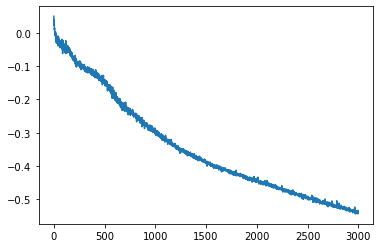

In [84]:
plt.plot(history.history['loss'])

In [85]:
preds = model.predict(xtrain_sc[:1000])

In [86]:
(preds*ytrain_sc[:1000]).mean()/(preds*ytrain_sc[:1000]).std()

0.5399214990146886

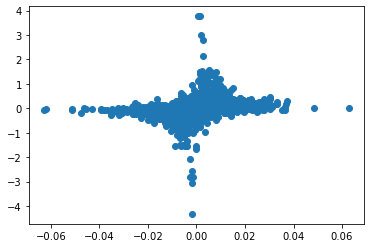

In [87]:
plt.scatter(preds,ytrain_sc[:1000])

In [88]:
(preds*ytrain_sc[:1000]).std()*np.sqrt(252)

0.04482834416902802

In [89]:
preds.max()

0.06268243

In [90]:
np.abs(ytrain_sc[:1000]).min()

0.003172192330810376

In [ ]:
###### Sortino

In [178]:
pr = tf.random.uniform(minval=1, maxval=2, shape=(10, 1), dtype=tf.float32)
tr = tf.random.uniform(minval=1, maxval=2, shape=(10, 1), dtype=tf.float32)

In [179]:
def batchLossSortino(yTrue,yPred):
    ix = (yTrue*yPred)<0
    y = yTrue*yPred
    down = K.std(y[ix])
    return -K.mean(y)/down

def batchLossSortinoTargetVol(yTrue,yPred):
    ix = (yTrue*yPred)<0
    y = yTrue*yPred
    down = K.std(y[ix])*(1+1*K.square(K.std(y)-.5))
    return -K.mean(y)/down

In [180]:
def Sortino(yTrue,yPred):
    ix = (yTrue*yPred)<0
    y = yTrue*yPred
    down = np.std(y[ix])
    return np.mean(y)/down

In [181]:
batchLossSortino(tr,pr)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [182]:
batchLossSortinoTargetVol(tr,pr)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [97]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(100,activation = 'relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

model.compile(loss=batchLossSortino, optimizer=tf.optimizers.Adam(learning_rate=.0001))

In [98]:
history = model.fit(xtrain_sc[:100], ytrain_sc[:100], epochs=2000,verbose=2,batch_size=100)

Epoch 1/2000
1/1 - 0s - loss: -5.4081e-02
Epoch 2/2000
1/1 - 0s - loss: -8.7957e-02
Epoch 3/2000
1/1 - 0s - loss: -1.3323e-01
Epoch 4/2000
1/1 - 0s - loss: -1.8692e-01
Epoch 5/2000
1/1 - 0s - loss: -2.5497e-01
Epoch 6/2000
1/1 - 0s - loss: -3.0948e-01
Epoch 7/2000
1/1 - 0s - loss: -3.3790e-01
Epoch 8/2000
1/1 - 0s - loss: -3.3319e-01
Epoch 9/2000
1/1 - 0s - loss: -3.3010e-01
Epoch 10/2000
1/1 - 0s - loss: -3.2840e-01
Epoch 11/2000
1/1 - 0s - loss: -3.3519e-01
Epoch 12/2000
1/1 - 0s - loss: -3.4734e-01
Epoch 13/2000
1/1 - 0s - loss: -3.6295e-01
Epoch 14/2000
1/1 - 0s - loss: -3.7948e-01
Epoch 15/2000
1/1 - 0s - loss: -3.9707e-01
Epoch 16/2000
1/1 - 0s - loss: -4.1608e-01
Epoch 17/2000
1/1 - 0s - loss: -4.1598e-01
Epoch 18/2000
1/1 - 0s - loss: -4.1809e-01
Epoch 19/2000
1/1 - 0s - loss: -4.1122e-01
Epoch 20/2000
1/1 - 0s - loss: -4.1057e-01
Epoch 21/2000
1/1 - 0s - loss: -4.1434e-01
Epoch 22/2000
1/1 - 0s - loss: -4.2236e-01
Epoch 23/2000
1/1 - 0s - loss: -4.3176e-01
Epoch 24/2000
1/1 - 

Epoch 190/2000
1/1 - 0s - loss: -3.7812e+00
Epoch 191/2000
1/1 - 0s - loss: -4.0987e+00
Epoch 192/2000
1/1 - 0s - loss: -4.0231e+00
Epoch 193/2000
1/1 - 0s - loss: -3.6911e+00
Epoch 194/2000
1/1 - 0s - loss: -4.2045e+00
Epoch 195/2000
1/1 - 0s - loss: -4.7205e+00
Epoch 196/2000
1/1 - 0s - loss: -3.1672e+00
Epoch 197/2000
1/1 - 0s - loss: -3.5423e+00
Epoch 198/2000
1/1 - 0s - loss: -4.4833e+00
Epoch 199/2000
1/1 - 0s - loss: -2.1591e+00
Epoch 200/2000
1/1 - 0s - loss: -1.5162e+00
Epoch 201/2000
1/1 - 0s - loss: -1.4397e+00
Epoch 202/2000
1/1 - 0s - loss: -1.5478e+00
Epoch 203/2000
1/1 - 0s - loss: -1.8878e+00
Epoch 204/2000
1/1 - 0s - loss: -2.5520e+00
Epoch 205/2000
1/1 - 0s - loss: -2.1274e+00
Epoch 206/2000
1/1 - 0s - loss: -1.9626e+00
Epoch 207/2000
1/1 - 0s - loss: -1.9542e+00
Epoch 208/2000
1/1 - 0s - loss: -2.1308e+00
Epoch 209/2000
1/1 - 0s - loss: -2.7814e+00
Epoch 210/2000
1/1 - 0s - loss: -4.4192e+00
Epoch 211/2000
1/1 - 0s - loss: -4.8262e+00
Epoch 212/2000
1/1 - 0s - loss: 

Epoch 377/2000
1/1 - 0s - loss: -8.4160e-02
Epoch 378/2000
1/1 - 0s - loss: -8.4901e-02
Epoch 379/2000
1/1 - 0s - loss: -8.5652e-02
Epoch 380/2000
1/1 - 0s - loss: -8.6413e-02
Epoch 381/2000
1/1 - 0s - loss: -8.7183e-02
Epoch 382/2000
1/1 - 0s - loss: -8.7961e-02
Epoch 383/2000
1/1 - 0s - loss: -8.8749e-02
Epoch 384/2000
1/1 - 0s - loss: -8.9547e-02
Epoch 385/2000
1/1 - 0s - loss: -9.0354e-02
Epoch 386/2000
1/1 - 0s - loss: -9.1167e-02
Epoch 387/2000
1/1 - 0s - loss: -9.1988e-02
Epoch 388/2000
1/1 - 0s - loss: -9.2820e-02
Epoch 389/2000
1/1 - 0s - loss: -9.3661e-02
Epoch 390/2000
1/1 - 0s - loss: -9.4497e-02
Epoch 391/2000
1/1 - 0s - loss: -9.5343e-02
Epoch 392/2000
1/1 - 0s - loss: -9.6203e-02
Epoch 393/2000
1/1 - 0s - loss: -9.7074e-02
Epoch 394/2000
1/1 - 0s - loss: -9.7957e-02
Epoch 395/2000
1/1 - 0s - loss: -9.8850e-02
Epoch 396/2000
1/1 - 0s - loss: -9.9755e-02
Epoch 397/2000
1/1 - 0s - loss: -1.0067e-01
Epoch 398/2000
1/1 - 0s - loss: -1.0160e-01
Epoch 399/2000
1/1 - 0s - loss: 

Epoch 564/2000
1/1 - 0s - loss: -3.3285e+00
Epoch 565/2000
1/1 - 0s - loss: -4.7801e+00
Epoch 566/2000
1/1 - 0s - loss: -3.6490e+00
Epoch 567/2000
1/1 - 0s - loss: -3.4715e+00
Epoch 568/2000
1/1 - 0s - loss: -5.9343e+00
Epoch 569/2000
1/1 - 0s - loss: -1.7972e+00
Epoch 570/2000
1/1 - 0s - loss: -8.1688e-01
Epoch 571/2000
1/1 - 0s - loss: -4.8994e-01
Epoch 572/2000
1/1 - 0s - loss: -3.4713e-01
Epoch 573/2000
1/1 - 0s - loss: -2.6784e-01
Epoch 574/2000
1/1 - 0s - loss: -2.1818e-01
Epoch 575/2000
1/1 - 0s - loss: -1.8410e-01
Epoch 576/2000
1/1 - 0s - loss: -1.5932e-01
Epoch 577/2000
1/1 - 0s - loss: -1.4098e-01
Epoch 578/2000
1/1 - 0s - loss: -1.2674e-01
Epoch 579/2000
1/1 - 0s - loss: -1.1554e-01
Epoch 580/2000
1/1 - 0s - loss: -1.0659e-01
Epoch 581/2000
1/1 - 0s - loss: -9.9377e-02
Epoch 582/2000
1/1 - 0s - loss: -9.3516e-02
Epoch 583/2000
1/1 - 0s - loss: -8.8736e-02
Epoch 584/2000
1/1 - 0s - loss: -8.4836e-02
Epoch 585/2000
1/1 - 0s - loss: -8.1655e-02
Epoch 586/2000
1/1 - 0s - loss: 

Epoch 751/2000
1/1 - 0s - loss: -4.2196e-01
Epoch 752/2000
1/1 - 0s - loss: -4.5539e-01
Epoch 753/2000
1/1 - 0s - loss: -4.9633e-01
Epoch 754/2000
1/1 - 0s - loss: -5.4789e-01
Epoch 755/2000
1/1 - 0s - loss: -6.1416e-01
Epoch 756/2000
1/1 - 0s - loss: -7.0402e-01
Epoch 757/2000
1/1 - 0s - loss: -8.3264e-01
Epoch 758/2000
1/1 - 0s - loss: -1.0257e+00
Epoch 759/2000
1/1 - 0s - loss: -1.3271e+00
Epoch 760/2000
1/1 - 0s - loss: -1.9004e+00
Epoch 761/2000
1/1 - 0s - loss: -3.0851e+00
Epoch 762/2000
1/1 - 0s - loss: -2.8845e+00
Epoch 763/2000
1/1 - 0s - loss: -2.0124e+00
Epoch 764/2000
1/1 - 0s - loss: -2.8304e+00
Epoch 765/2000
1/1 - 0s - loss: -5.1846e+00
Epoch 766/2000
1/1 - 0s - loss: -5.9072e+00
Epoch 767/2000
1/1 - 0s - loss: -2.6008e+00
Epoch 768/2000
1/1 - 0s - loss: -1.4243e+00
Epoch 769/2000
1/1 - 0s - loss: -1.0690e+00
Epoch 770/2000
1/1 - 0s - loss: -9.5794e-01
Epoch 771/2000
1/1 - 0s - loss: -9.3639e-01
Epoch 772/2000
1/1 - 0s - loss: -9.3650e-01
Epoch 773/2000
1/1 - 0s - loss: 

Epoch 938/2000
1/1 - 0s - loss: -5.2481e-01
Epoch 939/2000
1/1 - 0s - loss: -5.3837e-01
Epoch 940/2000
1/1 - 0s - loss: -5.5297e-01
Epoch 941/2000
1/1 - 0s - loss: -5.6875e-01
Epoch 942/2000
1/1 - 0s - loss: -5.8586e-01
Epoch 943/2000
1/1 - 0s - loss: -6.0439e-01
Epoch 944/2000
1/1 - 0s - loss: -6.2580e-01
Epoch 945/2000
1/1 - 0s - loss: -6.4872e-01
Epoch 946/2000
1/1 - 0s - loss: -6.7392e-01
Epoch 947/2000
1/1 - 0s - loss: -7.0240e-01
Epoch 948/2000
1/1 - 0s - loss: -7.3701e-01
Epoch 949/2000
1/1 - 0s - loss: -7.7720e-01
Epoch 950/2000
1/1 - 0s - loss: -8.2416e-01
Epoch 951/2000
1/1 - 0s - loss: -8.7577e-01
Epoch 952/2000
1/1 - 0s - loss: -9.3660e-01
Epoch 953/2000
1/1 - 0s - loss: -1.0162e+00
Epoch 954/2000
1/1 - 0s - loss: -1.1001e+00
Epoch 955/2000
1/1 - 0s - loss: -1.2099e+00
Epoch 956/2000
1/1 - 0s - loss: -1.3386e+00
Epoch 957/2000
1/1 - 0s - loss: -1.5280e+00
Epoch 958/2000
1/1 - 0s - loss: -1.7707e+00
Epoch 959/2000
1/1 - 0s - loss: -2.1687e+00
Epoch 960/2000
1/1 - 0s - loss: 

Epoch 1122/2000
1/1 - 0s - loss: -2.2750e-01
Epoch 1123/2000
1/1 - 0s - loss: -2.1828e-01
Epoch 1124/2000
1/1 - 0s - loss: -2.1078e-01
Epoch 1125/2000
1/1 - 0s - loss: -2.0460e-01
Epoch 1126/2000
1/1 - 0s - loss: -1.9951e-01
Epoch 1127/2000
1/1 - 0s - loss: -1.9526e-01
Epoch 1128/2000
1/1 - 0s - loss: -1.9173e-01
Epoch 1129/2000
1/1 - 0s - loss: -1.8879e-01
Epoch 1130/2000
1/1 - 0s - loss: -1.8633e-01
Epoch 1131/2000
1/1 - 0s - loss: -1.8426e-01
Epoch 1132/2000
1/1 - 0s - loss: -1.8253e-01
Epoch 1133/2000
1/1 - 0s - loss: -1.8111e-01
Epoch 1134/2000
1/1 - 0s - loss: -1.7993e-01
Epoch 1135/2000
1/1 - 0s - loss: -1.7897e-01
Epoch 1136/2000
1/1 - 0s - loss: -1.7820e-01
Epoch 1137/2000
1/1 - 0s - loss: -1.7760e-01
Epoch 1138/2000
1/1 - 0s - loss: -1.7715e-01
Epoch 1139/2000
1/1 - 0s - loss: -1.7683e-01
Epoch 1140/2000
1/1 - 0s - loss: -1.7662e-01
Epoch 1141/2000
1/1 - 0s - loss: -1.7652e-01
Epoch 1142/2000
1/1 - 0s - loss: -1.7651e-01
Epoch 1143/2000
1/1 - 0s - loss: -1.7658e-01
Epoch 1144

Epoch 1305/2000
1/1 - 0s - loss: -1.3816e+00
Epoch 1306/2000
1/1 - 0s - loss: -1.3283e+00
Epoch 1307/2000
1/1 - 0s - loss: -1.3379e+00
Epoch 1308/2000
1/1 - 0s - loss: -1.4045e+00
Epoch 1309/2000
1/1 - 0s - loss: -1.5361e+00
Epoch 1310/2000
1/1 - 0s - loss: -1.7379e+00
Epoch 1311/2000
1/1 - 0s - loss: -2.0614e+00
Epoch 1312/2000
1/1 - 0s - loss: -2.9323e+00
Epoch 1313/2000
1/1 - 0s - loss: -4.3168e+00
Epoch 1314/2000
1/1 - 0s - loss: -2.8154e+00
Epoch 1315/2000
1/1 - 0s - loss: -2.3162e+00
Epoch 1316/2000
1/1 - 0s - loss: -2.6579e+00
Epoch 1317/2000
1/1 - 0s - loss: -4.4970e+00
Epoch 1318/2000
1/1 - 0s - loss: -4.2723e+00
Epoch 1319/2000
1/1 - 0s - loss: -3.1474e+00
Epoch 1320/2000
1/1 - 0s - loss: -3.3589e+00
Epoch 1321/2000
1/1 - 0s - loss: -5.9401e+00
Epoch 1322/2000
1/1 - 0s - loss: -3.2505e+00
Epoch 1323/2000
1/1 - 0s - loss: -1.6913e+00
Epoch 1324/2000
1/1 - 0s - loss: -1.2658e+00
Epoch 1325/2000
1/1 - 0s - loss: -1.0866e+00
Epoch 1326/2000
1/1 - 0s - loss: -9.9588e-01
Epoch 1327

Epoch 1488/2000
1/1 - 0s - loss: -8.8443e+00
Epoch 1489/2000
1/1 - 0s - loss: -8.9310e+00
Epoch 1490/2000
1/1 - 0s - loss: -3.0125e+00
Epoch 1491/2000
1/1 - 0s - loss: -1.7639e+00
Epoch 1492/2000
1/1 - 0s - loss: -1.3268e+00
Epoch 1493/2000
1/1 - 0s - loss: -1.1059e+00
Epoch 1494/2000
1/1 - 0s - loss: -9.7805e-01
Epoch 1495/2000
1/1 - 0s - loss: -8.9861e-01
Epoch 1496/2000
1/1 - 0s - loss: -8.4743e-01
Epoch 1497/2000
1/1 - 0s - loss: -8.1334e-01
Epoch 1498/2000
1/1 - 0s - loss: -7.9277e-01
Epoch 1499/2000
1/1 - 0s - loss: -7.8123e-01
Epoch 1500/2000
1/1 - 0s - loss: -7.8016e-01
Epoch 1501/2000
1/1 - 0s - loss: -7.8673e-01
Epoch 1502/2000
1/1 - 0s - loss: -7.9813e-01
Epoch 1503/2000
1/1 - 0s - loss: -8.1923e-01
Epoch 1504/2000
1/1 - 0s - loss: -8.5069e-01
Epoch 1505/2000
1/1 - 0s - loss: -8.9102e-01
Epoch 1506/2000
1/1 - 0s - loss: -9.4264e-01
Epoch 1507/2000
1/1 - 0s - loss: -1.0111e+00
Epoch 1508/2000
1/1 - 0s - loss: -1.1034e+00
Epoch 1509/2000
1/1 - 0s - loss: -1.2328e+00
Epoch 1510

Epoch 1671/2000
1/1 - 0s - loss: -1.7583e-01
Epoch 1672/2000
1/1 - 0s - loss: -1.7609e-01
Epoch 1673/2000
1/1 - 0s - loss: -1.7635e-01
Epoch 1674/2000
1/1 - 0s - loss: -1.7662e-01
Epoch 1675/2000
1/1 - 0s - loss: -1.7688e-01
Epoch 1676/2000
1/1 - 0s - loss: -1.7715e-01
Epoch 1677/2000
1/1 - 0s - loss: -1.7742e-01
Epoch 1678/2000
1/1 - 0s - loss: -1.7769e-01
Epoch 1679/2000
1/1 - 0s - loss: -1.7796e-01
Epoch 1680/2000
1/1 - 0s - loss: -1.7823e-01
Epoch 1681/2000
1/1 - 0s - loss: -1.7851e-01
Epoch 1682/2000
1/1 - 0s - loss: -1.7878e-01
Epoch 1683/2000
1/1 - 0s - loss: -1.7906e-01
Epoch 1684/2000
1/1 - 0s - loss: -1.7933e-01
Epoch 1685/2000
1/1 - 0s - loss: -1.7961e-01
Epoch 1686/2000
1/1 - 0s - loss: -1.7989e-01
Epoch 1687/2000
1/1 - 0s - loss: -1.8018e-01
Epoch 1688/2000
1/1 - 0s - loss: -1.8046e-01
Epoch 1689/2000
1/1 - 0s - loss: -1.8075e-01
Epoch 1690/2000
1/1 - 0s - loss: -1.8103e-01
Epoch 1691/2000
1/1 - 0s - loss: -1.8132e-01
Epoch 1692/2000
1/1 - 0s - loss: -1.8161e-01
Epoch 1693

Epoch 1854/2000
1/1 - 0s - loss: -2.7228e-01
Epoch 1855/2000
1/1 - 0s - loss: -2.7341e-01
Epoch 1856/2000
1/1 - 0s - loss: -2.7455e-01
Epoch 1857/2000
1/1 - 0s - loss: -2.7571e-01
Epoch 1858/2000
1/1 - 0s - loss: -2.7689e-01
Epoch 1859/2000
1/1 - 0s - loss: -2.7808e-01
Epoch 1860/2000
1/1 - 0s - loss: -2.7929e-01
Epoch 1861/2000
1/1 - 0s - loss: -2.8051e-01
Epoch 1862/2000
1/1 - 0s - loss: -2.8176e-01
Epoch 1863/2000
1/1 - 0s - loss: -2.8302e-01
Epoch 1864/2000
1/1 - 0s - loss: -2.8430e-01
Epoch 1865/2000
1/1 - 0s - loss: -2.8560e-01
Epoch 1866/2000
1/1 - 0s - loss: -2.8692e-01
Epoch 1867/2000
1/1 - 0s - loss: -2.8826e-01
Epoch 1868/2000
1/1 - 0s - loss: -2.8962e-01
Epoch 1869/2000
1/1 - 0s - loss: -2.9101e-01
Epoch 1870/2000
1/1 - 0s - loss: -2.9242e-01
Epoch 1871/2000
1/1 - 0s - loss: -2.9385e-01
Epoch 1872/2000
1/1 - 0s - loss: -2.9531e-01
Epoch 1873/2000
1/1 - 0s - loss: -2.9679e-01
Epoch 1874/2000
1/1 - 0s - loss: -2.9830e-01
Epoch 1875/2000
1/1 - 0s - loss: -2.9983e-01
Epoch 1876

-0.8232284784317017


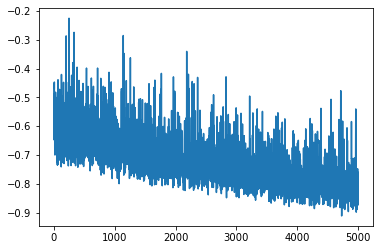

In [288]:
plt.plot(history.history['loss'])
print(history.history['loss'][-1])

In [100]:
preds = model.predict(xtrain_sc[:100])

In [101]:
print(Sortino(ytrain_sc[:100],preds))
(preds*ytrain_sc[:100]).mean()/(preds*ytrain_sc[:100]).std()

7.099747919296685


0.23620268300933608

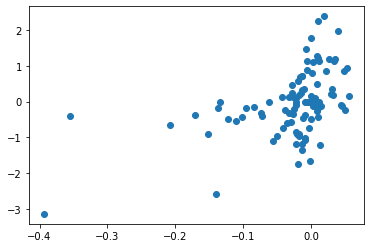

In [102]:
plt.scatter(preds,ytrain_sc[:100])

In [103]:
(preds*ytrain_sc[:100]).std()

0.12883654528370203

In [114]:
ytrain_sc

array([[-0.23024617],
       [ 0.93313522],
       [ 1.18659966],
       ...,
       [-0.64529022],
       [-0.63762024],
       [ 3.28183839]])

In [ ]:
##### extened to full dataset

In [183]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(7)),
    tf.keras.layers.Dense(250,activation = 'tanh'),
    tf.keras.layers.Dense(100,activation = 'relu'),
    tf.keras.layers.Dense(1,activation='tanh')
])

model.compile(loss=batchLossSortino, optimizer=tf.optimizers.Adam(learning_rate=.0001))

In [184]:
history = model.fit(xtrain_sc, ytrain_sc, epochs=2000,verbose=2,batch_size=2300)
# history = model.fit(xtrain_sc[:100], ytrain_sc[:100], epochs=2000,verbose=2,batch_size=2300)

Epoch 1/2000
5/5 - 0s - loss: -5.5792e-02
Epoch 2/2000
5/5 - 0s - loss: -7.1403e-02
Epoch 3/2000
5/5 - 0s - loss: -7.0067e-02
Epoch 4/2000
5/5 - 0s - loss: -7.2571e-02
Epoch 5/2000
5/5 - 0s - loss: -7.4418e-02
Epoch 6/2000
5/5 - 0s - loss: -7.5396e-02
Epoch 7/2000
5/5 - 0s - loss: -7.7351e-02
Epoch 8/2000
5/5 - 0s - loss: -7.6765e-02
Epoch 9/2000
5/5 - 0s - loss: -7.8089e-02
Epoch 10/2000
5/5 - 0s - loss: -7.8768e-02
Epoch 11/2000
5/5 - 0s - loss: -7.9724e-02
Epoch 12/2000
5/5 - 0s - loss: -8.1179e-02
Epoch 13/2000
5/5 - 0s - loss: -8.2083e-02
Epoch 14/2000
5/5 - 0s - loss: -8.4326e-02
Epoch 15/2000
5/5 - 0s - loss: -8.5588e-02
Epoch 16/2000
5/5 - 0s - loss: -8.4573e-02
Epoch 17/2000
5/5 - 0s - loss: -8.6984e-02
Epoch 18/2000
5/5 - 0s - loss: -8.5897e-02
Epoch 19/2000
5/5 - 0s - loss: -8.6675e-02
Epoch 20/2000
5/5 - 0s - loss: -8.8468e-02
Epoch 21/2000
5/5 - 0s - loss: -8.9813e-02
Epoch 22/2000
5/5 - 0s - loss: -9.1421e-02
Epoch 23/2000
5/5 - 0s - loss: -9.2570e-02
Epoch 24/2000
5/5 - 

Epoch 190/2000
5/5 - 0s - loss: -1.2922e-01
Epoch 191/2000
5/5 - 0s - loss: -1.4116e-01
Epoch 192/2000
5/5 - 0s - loss: -1.5078e-01
Epoch 193/2000
5/5 - 0s - loss: -1.5303e-01
Epoch 194/2000
5/5 - 0s - loss: -1.4913e-01
Epoch 195/2000
5/5 - 0s - loss: -1.4772e-01
Epoch 196/2000
5/5 - 0s - loss: -1.5024e-01
Epoch 197/2000
5/5 - 0s - loss: -1.5671e-01
Epoch 198/2000
5/5 - 0s - loss: -1.5847e-01
Epoch 199/2000
5/5 - 0s - loss: -1.6321e-01
Epoch 200/2000
5/5 - 0s - loss: -1.5344e-01
Epoch 201/2000
5/5 - 0s - loss: -1.4115e-01
Epoch 202/2000
5/5 - 0s - loss: -1.5736e-01
Epoch 203/2000
5/5 - 0s - loss: -1.5330e-01
Epoch 204/2000
5/5 - 0s - loss: -1.3843e-01
Epoch 205/2000
5/5 - 0s - loss: -1.2705e-01
Epoch 206/2000
5/5 - 0s - loss: -1.2691e-01
Epoch 207/2000
5/5 - 0s - loss: -1.3279e-01
Epoch 208/2000
5/5 - 0s - loss: -1.4596e-01
Epoch 209/2000
5/5 - 0s - loss: -1.6149e-01
Epoch 210/2000
5/5 - 0s - loss: -1.6177e-01
Epoch 211/2000
5/5 - 0s - loss: -1.5773e-01
Epoch 212/2000
5/5 - 0s - loss: 

Epoch 377/2000
5/5 - 0s - loss: -1.7026e-01
Epoch 378/2000
5/5 - 0s - loss: -1.9355e-01
Epoch 379/2000
5/5 - 0s - loss: -1.8168e-01
Epoch 380/2000
5/5 - 0s - loss: -1.8136e-01
Epoch 381/2000
5/5 - 0s - loss: -1.9076e-01
Epoch 382/2000
5/5 - 0s - loss: -2.0226e-01
Epoch 383/2000
5/5 - 0s - loss: -2.1121e-01
Epoch 384/2000
5/5 - 0s - loss: -2.0284e-01
Epoch 385/2000
5/5 - 0s - loss: -1.9142e-01
Epoch 386/2000
5/5 - 0s - loss: -1.9322e-01
Epoch 387/2000
5/5 - 0s - loss: -2.0637e-01
Epoch 388/2000
5/5 - 0s - loss: -2.0860e-01
Epoch 389/2000
5/5 - 0s - loss: -2.1289e-01
Epoch 390/2000
5/5 - 0s - loss: -2.1585e-01
Epoch 391/2000
5/5 - 0s - loss: -2.1164e-01
Epoch 392/2000
5/5 - 0s - loss: -2.0925e-01
Epoch 393/2000
5/5 - 0s - loss: -2.0321e-01
Epoch 394/2000
5/5 - 0s - loss: -2.0822e-01
Epoch 395/2000
5/5 - 0s - loss: -2.1199e-01
Epoch 396/2000
5/5 - 0s - loss: -2.1489e-01
Epoch 397/2000
5/5 - 0s - loss: -2.1270e-01
Epoch 398/2000
5/5 - 0s - loss: -2.0545e-01
Epoch 399/2000
5/5 - 0s - loss: 

Epoch 564/2000
5/5 - 0s - loss: -2.6120e-01
Epoch 565/2000
5/5 - 0s - loss: -2.5581e-01
Epoch 566/2000
5/5 - 0s - loss: -2.6246e-01
Epoch 567/2000
5/5 - 0s - loss: -2.3580e-01
Epoch 568/2000
5/5 - 0s - loss: -2.5486e-01
Epoch 569/2000
5/5 - 0s - loss: -2.5431e-01
Epoch 570/2000
5/5 - 0s - loss: -2.7091e-01
Epoch 571/2000
5/5 - 0s - loss: -2.7522e-01
Epoch 572/2000
5/5 - 0s - loss: -2.9302e-01
Epoch 573/2000
5/5 - 0s - loss: -1.8601e-01
Epoch 574/2000
5/5 - 0s - loss: -1.1918e-01
Epoch 575/2000
5/5 - 0s - loss: -1.0836e-01
Epoch 576/2000
5/5 - 0s - loss: -1.0788e-01
Epoch 577/2000
5/5 - 0s - loss: -1.1980e-01
Epoch 578/2000
5/5 - 0s - loss: -1.2992e-01
Epoch 579/2000
5/5 - 0s - loss: -1.4099e-01
Epoch 580/2000
5/5 - 0s - loss: -1.5184e-01
Epoch 581/2000
5/5 - 0s - loss: -1.6182e-01
Epoch 582/2000
5/5 - 0s - loss: -1.8063e-01
Epoch 583/2000
5/5 - 0s - loss: -2.0408e-01
Epoch 584/2000
5/5 - 0s - loss: -1.9584e-01
Epoch 585/2000
5/5 - 0s - loss: -2.0089e-01
Epoch 586/2000
5/5 - 0s - loss: 

Epoch 937/2000
5/5 - 0s - loss: -3.6151e-01
Epoch 938/2000
5/5 - 0s - loss: -3.7655e-01
Epoch 939/2000
5/5 - 0s - loss: -3.2872e-01
Epoch 940/2000
5/5 - 0s - loss: -3.2776e-01
Epoch 941/2000
5/5 - 0s - loss: -2.4819e-01
Epoch 942/2000
5/5 - 0s - loss: -2.1811e-01
Epoch 943/2000
5/5 - 0s - loss: -2.4551e-01
Epoch 944/2000
5/5 - 0s - loss: -2.8188e-01
Epoch 945/2000
5/5 - 0s - loss: -3.2102e-01
Epoch 946/2000
5/5 - 0s - loss: -2.8024e-01
Epoch 947/2000
5/5 - 0s - loss: -2.2955e-01
Epoch 948/2000
5/5 - 0s - loss: -1.6639e-01
Epoch 949/2000
5/5 - 0s - loss: -1.5218e-01
Epoch 950/2000
5/5 - 0s - loss: -1.4907e-01
Epoch 951/2000
5/5 - 0s - loss: -1.5699e-01
Epoch 952/2000
5/5 - 0s - loss: -1.6479e-01
Epoch 953/2000
5/5 - 0s - loss: -1.7825e-01
Epoch 954/2000
5/5 - 0s - loss: -1.9673e-01
Epoch 955/2000
5/5 - 0s - loss: -2.3497e-01
Epoch 956/2000
5/5 - 0s - loss: -3.1530e-01
Epoch 957/2000
5/5 - 0s - loss: -3.0995e-01
Epoch 958/2000
5/5 - 0s - loss: -2.7827e-01
Epoch 959/2000
5/5 - 0s - loss: 

Epoch 1121/2000
5/5 - 0s - loss: -1.0970e-01
Epoch 1122/2000
5/5 - 0s - loss: -1.0882e-01
Epoch 1123/2000
5/5 - 0s - loss: -1.0915e-01
Epoch 1124/2000
5/5 - 0s - loss: -1.1081e-01
Epoch 1125/2000
5/5 - 0s - loss: -1.1338e-01
Epoch 1126/2000
5/5 - 0s - loss: -1.1889e-01
Epoch 1127/2000
5/5 - 0s - loss: -1.2862e-01
Epoch 1128/2000
5/5 - 0s - loss: -1.2675e-01
Epoch 1129/2000
5/5 - 0s - loss: -1.3259e-01
Epoch 1130/2000
5/5 - 0s - loss: -1.3456e-01
Epoch 1131/2000
5/5 - 0s - loss: -1.3910e-01
Epoch 1132/2000
5/5 - 0s - loss: -1.4693e-01
Epoch 1133/2000
5/5 - 0s - loss: -1.5504e-01
Epoch 1134/2000
5/5 - 0s - loss: -1.6447e-01
Epoch 1135/2000
5/5 - 0s - loss: -1.7644e-01
Epoch 1136/2000
5/5 - 0s - loss: -1.9312e-01
Epoch 1137/2000
5/5 - 0s - loss: -2.1165e-01
Epoch 1138/2000
5/5 - 0s - loss: -2.3948e-01
Epoch 1139/2000
5/5 - 0s - loss: -2.6306e-01
Epoch 1140/2000
5/5 - 0s - loss: -2.9096e-01
Epoch 1141/2000
5/5 - 0s - loss: -3.1358e-01
Epoch 1142/2000
5/5 - 0s - loss: -3.4388e-01
Epoch 1143

Epoch 1306/2000
5/5 - 0s - loss: -1.4166e-01
Epoch 1307/2000
5/5 - 0s - loss: -1.4698e-01
Epoch 1308/2000
5/5 - 0s - loss: -1.6173e-01
Epoch 1309/2000
5/5 - 0s - loss: -1.7849e-01
Epoch 1310/2000
5/5 - 0s - loss: -2.1231e-01
Epoch 1311/2000
5/5 - 0s - loss: -2.7169e-01
Epoch 1312/2000
5/5 - 0s - loss: -3.0619e-01
Epoch 1313/2000
5/5 - 0s - loss: -2.9180e-01
Epoch 1314/2000
5/5 - 0s - loss: -3.1343e-01
Epoch 1315/2000
5/5 - 0s - loss: -3.4949e-01
Epoch 1316/2000
5/5 - 0s - loss: -3.3837e-01
Epoch 1317/2000
5/5 - 0s - loss: -3.7816e-01
Epoch 1318/2000
5/5 - 0s - loss: -3.8899e-01
Epoch 1319/2000
5/5 - 0s - loss: -3.4065e-01
Epoch 1320/2000
5/5 - 0s - loss: -3.3160e-01
Epoch 1321/2000
5/5 - 0s - loss: -2.5259e-01
Epoch 1322/2000
5/5 - 0s - loss: -1.4223e-01
Epoch 1323/2000
5/5 - 0s - loss: -1.5335e-01
Epoch 1324/2000
5/5 - 0s - loss: -2.1903e-01
Epoch 1325/2000
5/5 - 0s - loss: -2.9656e-01
Epoch 1326/2000
5/5 - 0s - loss: -3.1663e-01
Epoch 1327/2000
5/5 - 0s - loss: -3.4351e-01
Epoch 1328

Epoch 1489/2000
5/5 - 0s - loss: -1.8419e-01
Epoch 1490/2000
5/5 - 0s - loss: -1.9876e-01
Epoch 1491/2000
5/5 - 0s - loss: -2.2097e-01
Epoch 1492/2000
5/5 - 0s - loss: -2.4908e-01
Epoch 1493/2000
5/5 - 0s - loss: -2.6362e-01
Epoch 1494/2000
5/5 - 0s - loss: -2.8411e-01
Epoch 1495/2000
5/5 - 0s - loss: -2.8194e-01
Epoch 1496/2000
5/5 - 0s - loss: -2.9891e-01
Epoch 1497/2000
5/5 - 0s - loss: -3.3014e-01
Epoch 1498/2000
5/5 - 0s - loss: -3.4626e-01
Epoch 1499/2000
5/5 - 0s - loss: -3.7478e-01
Epoch 1500/2000
5/5 - 0s - loss: -3.3396e-01
Epoch 1501/2000
5/5 - 0s - loss: -3.6148e-01
Epoch 1502/2000
5/5 - 0s - loss: -3.9155e-01
Epoch 1503/2000
5/5 - 0s - loss: -3.7009e-01
Epoch 1504/2000
5/5 - 0s - loss: -3.9690e-01
Epoch 1505/2000
5/5 - 0s - loss: -4.0442e-01
Epoch 1506/2000
5/5 - 0s - loss: -2.3371e-01
Epoch 1507/2000
5/5 - 0s - loss: -1.2575e-01
Epoch 1508/2000
5/5 - 0s - loss: -1.0623e-01
Epoch 1509/2000
5/5 - 0s - loss: -1.0094e-01
Epoch 1510/2000
5/5 - 0s - loss: -1.0042e-01
Epoch 1511

Epoch 1672/2000
5/5 - 0s - loss: -4.0367e-01
Epoch 1673/2000
5/5 - 0s - loss: -4.1236e-01
Epoch 1674/2000
5/5 - 0s - loss: -4.2736e-01
Epoch 1675/2000
5/5 - 0s - loss: -4.0995e-01
Epoch 1676/2000
5/5 - 0s - loss: -3.9671e-01
Epoch 1677/2000
5/5 - 0s - loss: -4.2259e-01
Epoch 1678/2000
5/5 - 0s - loss: -4.2963e-01
Epoch 1679/2000
5/5 - 0s - loss: -4.6434e-01
Epoch 1680/2000
5/5 - 0s - loss: -4.5506e-01
Epoch 1681/2000
5/5 - 0s - loss: -4.2295e-01
Epoch 1682/2000
5/5 - 0s - loss: -4.3770e-01
Epoch 1683/2000
5/5 - 0s - loss: -4.5382e-01
Epoch 1684/2000
5/5 - 0s - loss: -4.3654e-01
Epoch 1685/2000
5/5 - 0s - loss: -4.5692e-01
Epoch 1686/2000
5/5 - 0s - loss: -4.3717e-01
Epoch 1687/2000
5/5 - 0s - loss: -4.4727e-01
Epoch 1688/2000
5/5 - 0s - loss: -4.4606e-01
Epoch 1689/2000
5/5 - 0s - loss: -4.6264e-01
Epoch 1690/2000
5/5 - 0s - loss: -4.7470e-01
Epoch 1691/2000
5/5 - 0s - loss: -4.6226e-01
Epoch 1692/2000
5/5 - 0s - loss: -4.6051e-01
Epoch 1693/2000
5/5 - 0s - loss: -4.7098e-01
Epoch 1694

Epoch 1855/2000
5/5 - 0s - loss: -3.9328e-01
Epoch 1856/2000
5/5 - 0s - loss: -3.6482e-01
Epoch 1857/2000
5/5 - 0s - loss: -4.0169e-01
Epoch 1858/2000
5/5 - 0s - loss: -3.9388e-01
Epoch 1859/2000
5/5 - 0s - loss: -3.9885e-01
Epoch 1860/2000
5/5 - 0s - loss: -3.4241e-01
Epoch 1861/2000
5/5 - 0s - loss: -4.1569e-01
Epoch 1862/2000
5/5 - 0s - loss: -4.4405e-01
Epoch 1863/2000
5/5 - 0s - loss: -4.0706e-01
Epoch 1864/2000
5/5 - 0s - loss: -3.7119e-01
Epoch 1865/2000
5/5 - 0s - loss: -4.2768e-01
Epoch 1866/2000
5/5 - 0s - loss: -2.5293e-01
Epoch 1867/2000
5/5 - 0s - loss: -7.7406e-02
Epoch 1868/2000
5/5 - 0s - loss: -6.7708e-02
Epoch 1869/2000
5/5 - 0s - loss: -7.8993e-02
Epoch 1870/2000
5/5 - 0s - loss: -1.0907e-01
Epoch 1871/2000
5/5 - 0s - loss: -1.4989e-01
Epoch 1872/2000
5/5 - 0s - loss: -2.0755e-01
Epoch 1873/2000
5/5 - 0s - loss: -2.7883e-01
Epoch 1874/2000
5/5 - 0s - loss: -3.5070e-01
Epoch 1875/2000
5/5 - 0s - loss: -3.7611e-01
Epoch 1876/2000
5/5 - 0s - loss: -4.1293e-01
Epoch 1877

In [193]:
xtrain_sc.shape

(9274, 7)

-0.4950404167175293


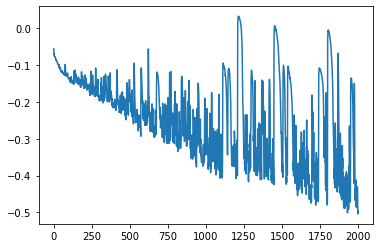

In [194]:
plt.plot(history.history['loss'])
print(history.history['loss'][-1])

In [195]:
preds = model.predict(xtrain_sc)
print(Sortino(ytrain_sc,preds))
print((preds*ytrain_sc).mean()/(preds*ytrain_sc).std())

0.4394527794719651
0.21484705408395155


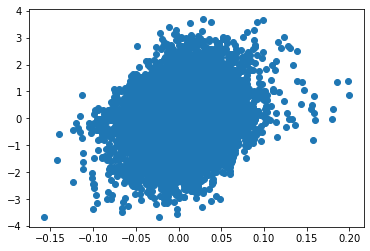

In [196]:
plt.scatter(preds,ytrain_sc)

sharpe: 0.03769890269982499
std: 0.006022925847650235
sortino: 0.04468030787114011


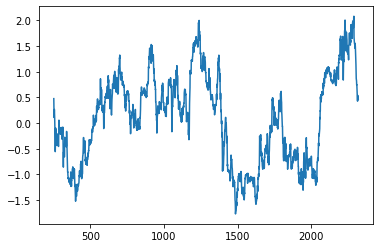

In [206]:
preds = model.predict(xtest_sc)
final = pd.DataFrame(preds,columns=['preds'])
final['y'] = scalerY.inverse_transform(ytest_sc)
final['profit'] = final['preds']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()
final.rolling_sharpe.plot()
print('sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
print('std: {}'.format(final.profit.std()*np.sqrt(252)))
print('sortino: {}'.format(Sortino(final.y,final.preds)*np.sqrt(252)))

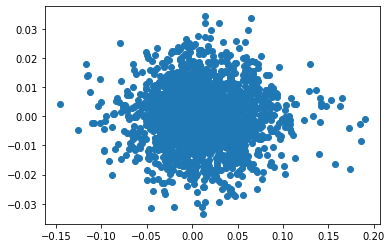

In [198]:
plt.scatter(final.preds,final.y)

In [199]:
np.abs(final.preds).mean()

0.03114943951368332

In [132]:
ytest_sc.shape

(2319, 1)

In [200]:
preds.shape

(2319, 1)

In [205]:
d = df2.iloc[-2319:]['dif']

In [202]:
p = d.to_numpy().reshape(-1,1)*preds

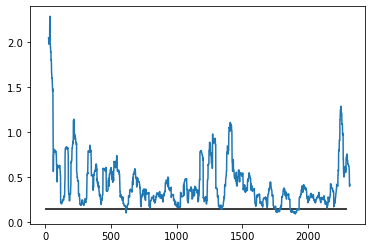

In [203]:
pd.Series(p.ravel()).rolling(25).std().plot()
plt.hlines(.15,0,2300)

In [159]:
p.ravel().shape

(2319,)

In [ ]:
# switch to forecasting returns, not positions

In [230]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, xtest_sc.shape[1])),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')

In [231]:
history = model.fit(xtrain_transformed, ytrain_transformed, epochs=50, batch_size=460, verbose=2)

Epoch 1/50
21/21 - 0s - loss: 1.0237
Epoch 2/50
21/21 - 0s - loss: 1.0087
Epoch 3/50
21/21 - 0s - loss: 1.0032
Epoch 4/50
21/21 - 0s - loss: 1.0006
Epoch 5/50
21/21 - 0s - loss: 0.9990
Epoch 6/50
21/21 - 0s - loss: 0.9980
Epoch 7/50
21/21 - 0s - loss: 0.9971
Epoch 8/50
21/21 - 0s - loss: 0.9964
Epoch 9/50
21/21 - 0s - loss: 0.9959
Epoch 10/50
21/21 - 0s - loss: 0.9951
Epoch 11/50
21/21 - 0s - loss: 0.9950
Epoch 12/50
21/21 - 0s - loss: 0.9952
Epoch 13/50
21/21 - 0s - loss: 0.9951
Epoch 14/50
21/21 - 0s - loss: 0.9945
Epoch 15/50
21/21 - 0s - loss: 0.9942
Epoch 16/50
21/21 - 0s - loss: 0.9933
Epoch 17/50
21/21 - 0s - loss: 0.9933
Epoch 18/50
21/21 - 0s - loss: 0.9935
Epoch 19/50
21/21 - 0s - loss: 0.9928
Epoch 20/50
21/21 - 0s - loss: 0.9923
Epoch 21/50
21/21 - 0s - loss: 0.9930
Epoch 22/50
21/21 - 0s - loss: 0.9924
Epoch 23/50
21/21 - 0s - loss: 0.9919
Epoch 24/50
21/21 - 0s - loss: 0.9917
Epoch 25/50
21/21 - 0s - loss: 0.9911
Epoch 26/50
21/21 - 0s - loss: 0.9910
Epoch 27/50
21/21 - 0

total sharpe: -0.29277722622580366


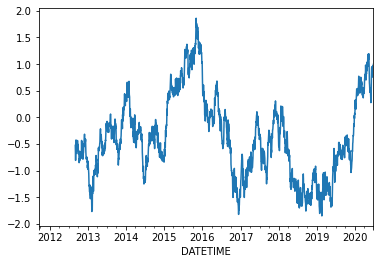

In [232]:
preds = model.predict(xtest_transformed)
final = pd.DataFrame(scalerY.inverse_transform(preds),columns=['preds'],index=ytest.iloc[num_steps:].index)
final['pos'] = final.preds.apply(lambda x: 1 if (x >= 0) else -1)
final['y'] = scalerY.inverse_transform(ytest_sc[num_steps:])
final['profit'] = final['pos']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

print('total sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
final.rolling_sharpe.plot()

In [237]:
final.profit.std()*np.sqrt(252)

0.1502348406327907

In [ ]:
# punish losses more than linear

In [91]:
def customLoss2K(yTrue,yPred):
    coef = 1
    ix = (yPred*yTrue)<0
    n = K.abs(yPred - yTrue)
    y = coef*yTrue**2 + K.abs(yPred-yTrue)
    out = tf.where(ix,x=y,y=n)
    return out

In [ ]:
t = tf.random.uniform(minval=-1, maxval=1, shape=(5, 1), dtype=tf.float32)
p = tf.random.uniform(minval=-1, maxval=1, shape=(5, 1), dtype=tf.float32)

In [ ]:
customLoss2K(t,p)

In [ ]:
batchsize = 1
epochs = 10

model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, xtest_sc.shape[1]),batch_size=batchsize),
    tf.keras.layers.LSTM(20,stateful=True),
    tf.keras.layers.Dense(1)
])
model.compile(loss=customLoss2K, optimizer='adam')

In [ ]:
model.summary()

In [ ]:
for i in range(epochs):
    model.fit(xtrain_transformed, ytrain_transformed,epochs=1, batch_size=batchsize,verbose=2,shuffle=False)
    model.reset_states()

In [ ]:
preds = model.predict(xtest_transformed,batch_size=batchsize)
final = pd.DataFrame(scalerY.inverse_transform(preds),columns=['preds'],index=ytest.iloc[num_steps:].index)
final['pos'] = final.preds.apply(lambda x: 1 if (x >= 0) else -1)
final['y'] = scalerY.inverse_transform(ytest_sc[num_steps:])
final['profit'] = final['pos']*final['y']
final['rolling_sharpe'] = final.profit.rolling(252).mean()*np.sqrt(252)/final.profit.rolling(252).std()

print('total sharpe: {}'.format(final.profit.mean()*np.sqrt(252)/final.profit.std()))
final.rolling_sharpe.plot()

In [ ]:
final.preds.hist()

In [ ]:
plt.scatter(final.preds,final.y)

In [ ]:
final['bucket'] = pd.qcut(final.preds,6)

In [ ]:
final.groupby('bucket').mean()

In [ ]:
xtrain_transformed.shape

In [ ]:
xtrain_transformed[-1].shape